In [1]:
# from IPython.core.display import display, HTML
# display(HTML(d|ata="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

# #width for some images
# im_width = 11

In [2]:
alldata = dict()

In [3]:
# %matplotlib nbagg
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patch
from matplotlib.patches import Polygon

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

import pandas as pd

import numpy as np
import scipy as sp
# import scipy.optimize 
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.misc import face
from scipy import interpolate

import glob
import csv
import re
import sys 
import os
import copy
import time
import h5py
import skimage.feature
import skimage.filters
import skimage.measure
import socket  
import itertools
from tqdm.notebook import tqdm as tqdm

from skimage import filters


from IPython.display import display, clear_output, Markdown
from PIL import Image, ImageOps

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

import cv2

udir = '/cds/home/d/diegotur/UED/'

if udir not in sys.path:
    sys.path.append(udir)

import ued_dt3 as ued_dt
try:
    import pyFAI, pyFAI.detectors
    from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
except:
    print('No pyFAI library found. If you want to do azimuthal integrations - install it!')

import dt_functions as dt
import I_UED_dt


import lmfit
from lmfit import Model, Parameters

import imp

In [4]:
import pickle

In [5]:

# And here is how I would load it
with open('./lattice_expansion_data/dif_big_dataset_lattice_expansion.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [6]:
dif = loaded_dict

# Debye Waller Factor Analysis

In [7]:
dif.debye_waller = dif.Static()

## Load and plot Jakub's and Pablo's DW factors

In [8]:
q_25_00_00=np.asarray([2.5, 0, 0]) #rlu
dw_25_00_00 = pd.read_csv(
    '/cds/home/d/diegotur/UED/FePt/ext_data/DWF_2-5_0-0_0-0.out',
delimiter='   ',)
data_25_00_00=dict()
data_25_00_00['data'] = dw_25_00_00
data_25_00_00['q'] = q_25_00_00


data_dict = dict()
data_dict[0] = data_25_00_00


/cds/home/d/diegotur/.conda/envs/diego_test_py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


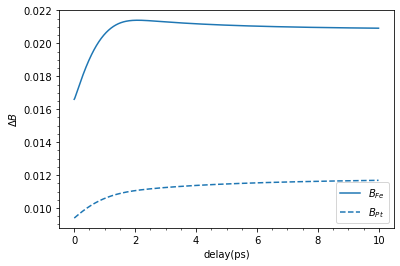

In [9]:
plt.figure(facecolor = 'white')

i=0
plt.plot(np.arange(1000)/100,
         data_dict[i]['data']['Unnamed: 3']/np.linalg.norm(data_dict[i]['q'])**2 , 
         c=f'C{i}', ls='-', label = r'$B_{Fe}$')
plt.plot( np.arange(1000)/100,
         data_dict[i]['data']['Unnamed: 5']/np.linalg.norm(data_dict[i]['q'])**2 ,
         c=f'C{i}', ls='--', label = '$B_{Pt}$')
plt.xlabel('delay(ps)')
plt.ylabel(r'$\Delta B$')
plt.legend()

In [10]:
print(r'$ B_{Fe}(t0) = $' + str((data_dict[i]['data']['Unnamed: 3']/np.linalg.norm(data_dict[i]['q'])**2)[0]))
print(r'$ B_{Pt}(t0) = $' + str((data_dict[i]['data']['Unnamed: 5']/np.linalg.norm(data_dict[i]['q'])**2)[0]))

$ B_{Fe}(t0) = $0.016604622907447054
$ B_{Pt}(t0) = $0.009399430338440899


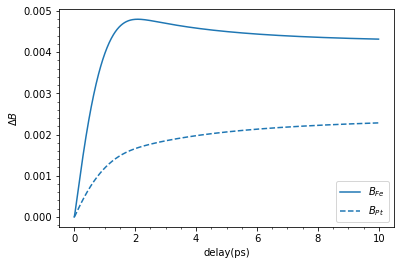

In [11]:
plt.figure(facecolor = 'white')

i=0
plt.plot(np.arange(1000)/100,
         data_dict[i]['data']['Unnamed: 3']/np.linalg.norm(data_dict[i]['q'])**2 - (data_dict[i]['data']['Unnamed: 3']/np.linalg.norm(data_dict[i]['q'])**2)[0], 
         c=f'C{i}', ls='-', label = r'$B_{Fe}$')
plt.plot( np.arange(1000)/100,
         data_dict[i]['data']['Unnamed: 5']/np.linalg.norm(data_dict[i]['q'])**2 - (data_dict[i]['data']['Unnamed: 5']/np.linalg.norm(data_dict[i]['q'])**2)[0],
         c=f'C{i}', ls='--', label = '$B_{Pt}$')
plt.xlabel('delay(ps)')
plt.ylabel(r'$\Delta B$')
plt.legend()

In [12]:
print((data_dict[0]['data']['Unnamed: 3']/np.linalg.norm(data_dict[0]['q'])**2)[0],
(data_dict[0]['data']['Unnamed: 5']/np.linalg.norm(data_dict[0]['q'])**2)[0])

0.016604622907447054 0.009399430338440899


## Use the "Warren method" to get B factors by fitting slopes

In [13]:
dif.dw_Warren_vary_B = pd.DataFrame()

dif.dw_Warren_vary_B['a1_t'] = np.zeros(35)
dif.dw_Warren_vary_B['a2_t'] = np.zeros(35)

dif.dw_Warren_vary_B['b1_t'] = np.zeros(35)
dif.dw_Warren_vary_B['b2_t'] = np.zeros(35)

for i in np.arange(35):
    
#     amps_t0 = dif.compact[:,i,0]*dif.areas_symmetrised_compact[:,i]
    amps_t0       = dif.volumes_symmetrised_compact[:,i]
    amps_t0_error = dif.volumes_symmetrised_compact_errors[:,i]
#     amps_t0_error = dif.compact_errors[:,i,0]
#     print(compact_errors[:,i,0].shape)
# 
#     amps_t0 = As2[:,i] # with integrated intensities over the whole bragg peak
#     amps_t0_error = As2_errors[:,i]
    
#     amps_t0 = As[:,i] # with integrated intensities over the whole bragg peak
#     amps_t0_error = As_errors[:,i]

    q_vecs_t0 = dif.q_symmetrised_compact[:,i]
    q_vecs_t0_error = dif.q_symmetrised_compact_errors[:,i]
    
#     amps_t_corrected = (np.sqrt(amps_t0 + azimuthal_vals_bkg_intrp(q_vecs_t0)) - sqrt_azimuthal_vals_bkg_intrp(q_vecs_t0))**2
    amps_t_corrected = amps_t0

#     amps_t_corrected_sqrt = amps_t_corrected#np.sqrt(amps_t_corrected)
#     amps_t_corrected_sqrt_errors = amps_t0_error#amps_t_corrected_sqrt * np.sqrt((amps_t0_error/(2*amps_t_corrected))**2)
    amps_t_corrected_sqrt = np.sqrt(amps_t_corrected)
    amps_t_corrected_sqrt_errors = amps_t_corrected_sqrt * np.sqrt((amps_t0_error/(2*amps_t_corrected))**2)
    
    sel_even = np.sum(np.asarray(dif.compact_hkl), axis = 1) %2 == 0
    sel_odd =  np.sum(np.asarray(dif.compact_hkl), axis = 1) %2 == 1

    sel_even_not_nan = ~np.isnan(np.sqrt(amps_t_corrected[sel_even]))&(amps_t_corrected[sel_even]  >0 )
    sel_odd_not_nan =  ~np.isnan(np.sqrt(amps_t_corrected[sel_odd ]))&(amps_t_corrected[sel_odd]  >0 )

    test_q_array = np.arange(np.min(q_vecs_t0), np.max(q_vecs_t0), 0.1)
    even_sorted_args = np.argsort(q_vecs_t0[sel_even][sel_even_not_nan])
    odd_sorted_args  = np.argsort(q_vecs_t0[sel_odd ][sel_odd_not_nan ])

    
    spl_Warren_Q_even = interpolate.splrep(q_vecs_t0[sel_even][sel_even_not_nan][even_sorted_args], 
                                           amps_t_corrected_sqrt[sel_even][sel_even_not_nan][even_sorted_args], 
                                           k =2 )
    spl_Warren_Q_even_high = interpolate.splrep(q_vecs_t0[sel_even][sel_even_not_nan][even_sorted_args], 
                                           (amps_t_corrected_sqrt+amps_t_corrected_sqrt_errors)[sel_even][sel_even_not_nan][even_sorted_args], 
                                           k =2 )
    spl_Warren_Q_even_low = interpolate.splrep(q_vecs_t0[sel_even][sel_even_not_nan][even_sorted_args], 
                                           (amps_t_corrected_sqrt-amps_t_corrected_sqrt_errors)[sel_even][sel_even_not_nan][even_sorted_args], 
                                           k =2 )    
    
    
    
    
    spl_Warren_Q_odd =  interpolate.splrep(q_vecs_t0[sel_odd][sel_odd_not_nan][odd_sorted_args], 
                                           amps_t_corrected_sqrt[sel_odd][sel_odd_not_nan][odd_sorted_args],
                                           k =2 )
    spl_Warren_Q_odd_high =  interpolate.splrep(q_vecs_t0[sel_odd][sel_odd_not_nan][odd_sorted_args], 
                                           (amps_t_corrected_sqrt+amps_t_corrected_sqrt_errors)[sel_odd][sel_odd_not_nan][odd_sorted_args],
                                           k =2 )
    spl_Warren_Q_odd_low =  interpolate.splrep(q_vecs_t0[sel_odd][sel_odd_not_nan][odd_sorted_args], 
                                           (amps_t_corrected_sqrt-amps_t_corrected_sqrt_errors)[sel_odd][sel_odd_not_nan][odd_sorted_args],
                                           k =2 )
    
    print((amps_t_corrected_sqrt-amps_t_corrected_sqrt_errors)[sel_odd][sel_odd_not_nan][odd_sorted_args])
    Warren_Q_even = interpolate.splev(test_q_array, spl_Warren_Q_even)
    Warren_Q_even_high = interpolate.splev(test_q_array, spl_Warren_Q_even_high)
    Warren_Q_even_low = interpolate.splev(test_q_array, spl_Warren_Q_even_low)

    Warren_Q_odd  = interpolate.splev(test_q_array, spl_Warren_Q_odd)
    Warren_Q_odd_high  = interpolate.splev(test_q_array, spl_Warren_Q_odd_high)
    Warren_Q_odd_low  = interpolate.splev(test_q_array, spl_Warren_Q_odd_low)

    
    Warren_Q_even_plot = interpolate.splev(q_vecs_t0, spl_Warren_Q_even)
    Warren_Q_odd_plot  = interpolate.splev(q_vecs_t0, spl_Warren_Q_odd)
    
    Warren_Q_even_plot_high = interpolate.splev(q_vecs_t0, spl_Warren_Q_even_high)
    Warren_Q_odd_plot_high  = interpolate.splev(q_vecs_t0, spl_Warren_Q_odd_high)
    Warren_Q_even_plot_low = interpolate.splev(q_vecs_t0, spl_Warren_Q_even_low)
    Warren_Q_odd_plot_low  = interpolate.splev(q_vecs_t0, spl_Warren_Q_odd_low)
    
    
    
    
    Warren_f_Fe = dt.electron_form_factor(test_q_array, element = 'Fe') # I am too tired for being considering error on q ...
    Warren_f_Pt = dt.electron_form_factor(test_q_array, element = 'Pt') # I am too tired for being considering error on q ...
    Warren_f_Fe_errors = np.zeros_like(Warren_f_Fe)
    Warren_f_Pt_errors = np.zeros_like(Warren_f_Pt)
    
    Warren_f_Fe_plot = dt.electron_form_factor(q_vecs_t0, element = 'Fe')
    Warren_f_Pt_plot = dt.electron_form_factor(q_vecs_t0, element = 'Pt') 
    Warren_f_Fe_plot_errors = np.zeros_like(Warren_f_Fe_plot) 
    Warren_f_Pt_plot_errors = np.zeros_like(Warren_f_Pt_plot)    
    
    warren_sum = np.log((Warren_Q_even + Warren_Q_odd)/(2*Warren_f_Pt))
    warren_dif = np.log(np.abs(Warren_Q_even - Warren_Q_odd)/(2*Warren_f_Fe) )
    Warren_Q_even_errors = (Warren_Q_even_high - Warren_Q_odd_low)/2
    Warren_Q_odd_errors  =( Warren_Q_odd_high - Warren_Q_odd_low)/2
    
    warren_sum_plot = np.log((Warren_Q_even_plot + Warren_Q_odd_plot)/(2*Warren_f_Pt_plot))
    warren_dif_plot = np.log(np.abs(Warren_Q_even_plot - Warren_Q_odd_plot)/(2*Warren_f_Fe_plot) )
    Warren_Q_even_errors_plot = (Warren_Q_even_plot_high - Warren_Q_odd_plot_low)/2
    Warren_Q_odd_errors_plot  =( Warren_Q_odd_plot_high - Warren_Q_odd_plot_low)/2
    
    
    #############################################################################
    ## Calulate error the Sum and difference from both                       ####
    #############################################################################
    dw_sum__dfpt = -1/Warren_f_Pt
    dw_dif__dffe = -1/Warren_f_Fe
    dw_sum__dQeven = 1/(Warren_Q_even + Warren_Q_odd)
    dw_dif__dQeven = 1/(Warren_Q_even - Warren_Q_odd)
    dw_sum__dQodd = 1/(Warren_Q_even + Warren_Q_odd)
    dw_dif__dQodd = -1/(Warren_Q_even - Warren_Q_odd)
    
    warren_sum_errors = np.sqrt( dw_sum__dfpt**2 *Warren_f_Pt_errors**2 + 
                                dw_sum__dQeven**2 *Warren_Q_even_errors**2 + 
                                dw_sum__dQodd**2  *Warren_Q_odd_errors**2 )
    
    warren_dif_errors = np.sqrt( dw_dif__dffe**2 *Warren_f_Fe_errors**2 + 
                                dw_dif__dQeven**2 *Warren_Q_even_errors**2 + 
                                dw_dif__dQodd**2  *Warren_Q_odd_errors**2 )
    
    
    #############################################################################
    ## Now we check the same for the plotting warren difference / sum         ###
    #############################################################################
    dw_sum__dfpt_plot = -1/Warren_f_Pt_plot
    dw_dif__dffe_plot = -1/Warren_f_Fe_plot 
    dw_sum__dQeven_plot = 1/(Warren_Q_even_plot + Warren_Q_odd_plot)
    dw_dif__dQeven_plot = 1/(Warren_Q_even_plot - Warren_Q_odd_plot)
    dw_sum__dQodd_plot = 1/(Warren_Q_even_plot + Warren_Q_odd_plot)
    dw_dif__dQodd_plot = -1/(Warren_Q_even_plot - Warren_Q_odd_plot)
    
    warren_sum_errors_plot = np.sqrt( dw_sum__dfpt_plot**2 *Warren_f_Pt_plot_errors**2 + 
                                dw_sum__dQeven_plot**2 *Warren_Q_even_errors_plot**2 + 
                                dw_sum__dQodd_plot**2  *Warren_Q_odd_errors_plot**2 )
    
    warren_dif_errors_plot = np.sqrt( dw_dif__dffe_plot**2 *Warren_f_Fe_plot_errors**2 + 
                                dw_dif__dQeven_plot**2 *Warren_Q_even_errors_plot**2 + 
                                dw_dif__dQodd_plot**2  *Warren_Q_odd_errors_plot**2 )
    
    #################
    ##   Fitting   ##
    #################
    
    
#     max_q = 50#This one was on before... 
#     max_q = 100#

#     max_q = 80#
#     min_q = 40

    dif.min_q = 0.9*np.min(q_vecs_t0)**2   
#     dif.max_q = 50#
    dif.max_q = 100 
    
#     dif.min_q = 30
    
#     max_q = 5**2#test for Hermann
#     max_q = 8**2 

#     sel_low_q = test_q_array**2 < max_q
    sel_low_q = (test_q_array**2 < dif.max_q)&(test_q_array**2 > dif.min_q )
    
    a1, b1 = np.polyfit((test_q_array**2)[sel_low_q] ,  warren_sum[sel_low_q], 1)
    a2, b2 = np.polyfit((test_q_array**2)[sel_low_q] ,  warren_dif[sel_low_q], 1)
    
    dif.dw_Warren_vary_B.a1_t[i] = a1 
    dif.dw_Warren_vary_B.a2_t[i] = a2 
    
    dif.dw_Warren_vary_B.b1_t[i] = b1 
    dif.dw_Warren_vary_B.b2_t[i] = b2 
    

[10.53581918  4.9167151   3.58038784  2.8887035   2.57933051  2.11114463]
[10.53437014  4.91352616  3.57877684  2.89315316  2.57996027  2.11376497]
[10.53520729  4.91697273  3.58081673  2.89422283  2.58189171  2.10789429]
[10.56736487  4.92997196  3.58982111  2.89626322  2.58407449  2.11252493]
[10.55501989  4.92883318  3.5864608   2.89937563  2.58645189  2.10927199]
[10.56157935  4.9268883   3.5863526   2.89746775  2.58268254  2.11809689]
[10.56831534  4.93322879  3.58610974  2.89763561  2.58362701  2.11486789]
[10.55597862  4.92678584  3.5848515   2.89286971  2.57466082  2.10191554]
[10.57638579  4.93684803  3.58623326  2.89201992  2.57211242  2.09787787]
[10.56855302  4.93135589  3.58235193  2.88591086  2.56150471  2.08273303]
[10.57808386  4.935161    3.57494604  2.87978487  2.55279775  2.06282998]
[10.59686053  4.94868232  3.57578009  2.87023986  2.54209773  2.04461406]
[10.61409505  4.95428366  3.57102409  2.86160075  2.52251946  2.02002279]
[10.61293807  4.95311055  3.564728    

Text(0, 0.5, 'Fitted Amplitdue (arb. units)')

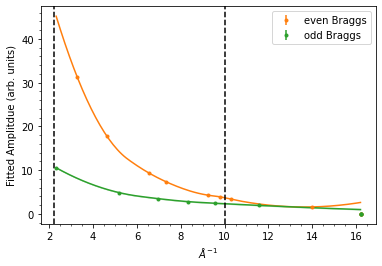

In [14]:
plt.figure()

plt.plot(test_q_array, Warren_Q_even, c='C1', )
plt.fill_between(test_q_array, Warren_Q_even_low, Warren_Q_even_high,color='C1', alpha = 0.2)
plt.errorbar(q_vecs_t0[sel_even], amps_t_corrected_sqrt[sel_even], yerr=amps_t_corrected_sqrt_errors[sel_even]  ,marker ='.', linestyle='', c='C1',  label = 'even Braggs')

plt.plot(test_q_array, Warren_Q_odd,c='C2',)
plt.fill_between(test_q_array, Warren_Q_odd_low, Warren_Q_odd_high,color='C2', alpha = 0.2)
plt.errorbar(q_vecs_t0[sel_odd], (amps_t_corrected_sqrt[sel_odd]), yerr=amps_t_corrected_sqrt_errors[sel_odd] , marker='.', linestyle='', c='C2', label = 'odd Braggs')

plt.axvline(np.sqrt(dif.max_q), c='k', ls='--')
plt.axvline(np.sqrt(dif.min_q), c='k', ls='--')
plt.legend()
plt.xlabel(r'$ \AA^{-1} $')
plt.ylabel('Fitted Amplitdue (arb. units)')
# plt.xlim(2,4)
# plt.ylim(12,12.1)

Coef factor (red line): 1.8256842431422173


Text(0, 0.5, '$ ln( \\frac{0(Q_{even} \\pm Q_{odd})}{2f} )$')

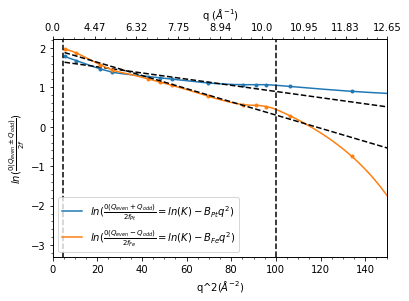

In [15]:
# plt.figure()
fig, ax = plt.subplots()

# ax.plot(test_q_array**2, np.log((Warren_Q_even + Warren_Q_odd)/(2*Warren_f_Pt) ), label = r'$ln(K) - B_{Pt} q^2 $' + f': $K = {np.round(b1_t[-1],3)} , BPt = {-np.round(a1_t[-1], 3)}$'  )
ax.plot(test_q_array**2, np.log((Warren_Q_even + Warren_Q_odd)/(2*Warren_f_Pt) ), label = r'$ ln( \frac{0(Q_{even} + Q_{odd})}{2f_{Pt}} = ln(K) - B_{Pt} q^2  )$')#+ f': $K = {np.round(b1_t[-1],3)} , BPt = {-np.round(a1_t[-1], 3)}$'  )

ax.plot(q_vecs_t0**2, np.log((Warren_Q_even_plot + Warren_Q_odd_plot)/(2*Warren_f_Pt_plot) ),'.', c='C0' )
ax.plot(test_q_array**2, dif.dw_Warren_vary_B.b1_t.values[-1] + dif.dw_Warren_vary_B.a1_t.values[-1]*test_q_array**2, '--', c='k', )

# ax.plot(test_q_array**2, np.log((Warren_Q_even - Warren_Q_odd)/(2*Warren_f_Fe) ), label = r'$ln(K) - B_{Fe} q^2 $' + f': $K = {np.round(b2_t[-1],3)} , BFe = {-np.round(a2_t[-1], 3)}$'  )
ax.plot(test_q_array**2, np.log((Warren_Q_even - Warren_Q_odd)/(2*Warren_f_Fe) ), label = r'$ ln( \frac{0(Q_{even} - Q_{odd})}{2f_{Fe}} = ln(K) - B_{Fe} q^2  )$' )#+ f': $K = {np.round(b2_t[-1],3)} , BFe = {-np.round(a2_t[-1], 3)}$'  )

ax.plot(q_vecs_t0**2, np.log((Warren_Q_even_plot - Warren_Q_odd_plot)/(2*Warren_f_Fe_plot) ),'.', c='C1' )
ax.plot(test_q_array**2, dif.dw_Warren_vary_B.b2_t.values[-1] + dif.dw_Warren_vary_B.a2_t.values[-1]*test_q_array**2, '--', c='k', )

# ax.axhline(0.5*(b1_t[-1] + b2_t[-1]), ls='--', color='r')
print(f'Coef factor (red line): {0.5*(dif.dw_Warren_vary_B.b1_t.values[-1] + dif.dw_Warren_vary_B.b2_t.values[-1])}')

ax.set_xlim(0,150)
# ax.set_ylim(-2,1.9)

# ax.set_xlim(0,300)
# ax.set_xlim(0,80)

# ax.set_ylim(-1.5,1.5)
ax.axvline(dif.max_q, c='k', ls='--')
ax.axvline(dif.min_q, c='k', ls='--')

ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks);
ax2.set_xticklabels(np.round(np.sqrt(ticks), 2))
ax2.set_xlabel('q ' + r'$(\AA^{-1}) $')
# ax2.plot(q_vecs_t0, np.zeros_like(q_vecs_t0), alpha = 0)
# ax2.set_xlim(0,np.sqrt(300) )

ax.legend()

ax.set_xlabel(r'q^2' + r'$ (\AA^{-2}) $')
ax.set_ylabel(r'$ ln( \frac{0(Q_{even} \pm Q_{odd})}{2f} )$')

Coef factor (red line): 1.8256842431422173


/cds/home/d/diegotur/.conda/envs/diego_test_py3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/cds/home/d/diegotur/.conda/envs/diego_test_py3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$ ln( \\frac{0(Q_{even} \\pm Q_{odd})}{2f} )$')

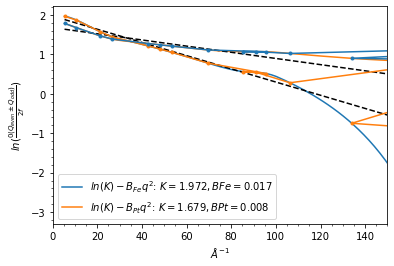

In [16]:
plt.figure()

plt.plot(test_q_array**2, np.log((Warren_Q_even - Warren_Q_odd)/(2*Warren_f_Fe) ), label = r'$ln(K) - B_{Fe} q^2 $' + f': $K = {np.round(dif.dw_Warren_vary_B.b2_t.values[-1],3)} , BFe = {-np.round(dif.dw_Warren_vary_B.a2_t.values[-1], 3)}$'  )
plt.errorbar(q_vecs_t0**2, np.log((Warren_Q_even_plot - Warren_Q_odd_plot)/(2*Warren_f_Fe_plot) ),yerr =warren_dif_errors_plot, marker= '.', color='C1' )
plt.plot(test_q_array**2, (dif.dw_Warren_vary_B.b2_t.values[-1]) + dif.dw_Warren_vary_B.a2_t.values[-1]*test_q_array**2, '--', c='k', )

plt.plot(test_q_array**2, np.log((Warren_Q_even + Warren_Q_odd)/(2*Warren_f_Pt) ), label = r'$ln(K) - B_{Pt} q^2 $' + f': $K = {np.round(dif.dw_Warren_vary_B.b1_t.values[-1],3)} , BPt = {-np.round(dif.dw_Warren_vary_B.a1_t.values[-1], 3)}$'  )
plt.errorbar(q_vecs_t0**2, np.log((Warren_Q_even_plot + Warren_Q_odd_plot)/(2*Warren_f_Pt_plot) ),yerr =warren_sum_errors_plot, marker= '.', color='C0' )
plt.plot(test_q_array**2, (dif.dw_Warren_vary_B.b1_t.values[-1]) + dif.dw_Warren_vary_B.a1_t.values[-1]*test_q_array**2, '--', c='k', )

print(f'Coef factor (red line): {0.5*(dif.dw_Warren_vary_B.b1_t.values[-1] + dif.dw_Warren_vary_B.b2_t.values[-1])}')

plt.xlim(0,300/2)
# plt.ylim(-2.,2) 
plt.legend()

plt.xlabel(r'$ \AA^{-1} $')
plt.ylabel(r'$ ln( \frac{0(Q_{even} \pm Q_{odd})}{2f} )$')

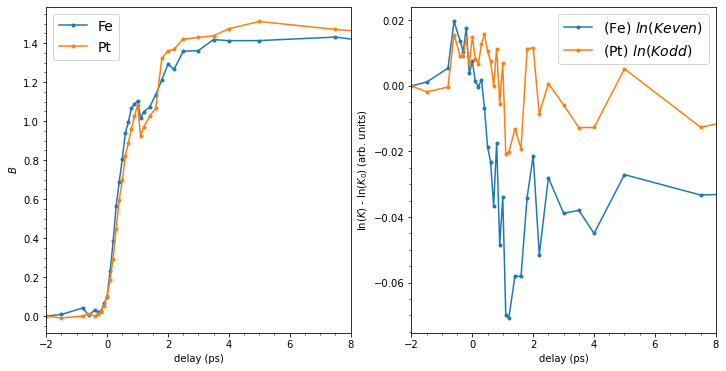

In [17]:
fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize =( 12,6))

ax1.plot(dif.bincenters, (-dif.dw_Warren_vary_B.a2_t.values + dif.dw_Warren_vary_B.a2_t.values[0])/(-dif.dw_Warren_vary_B.a2_t.values + dif.dw_Warren_vary_B.a2_t.values[0])[-1], '.-', label = 'Fe')
ax1.plot(dif.bincenters, (-dif.dw_Warren_vary_B.a1_t.values + dif.dw_Warren_vary_B.a1_t.values[0])/(-dif.dw_Warren_vary_B.a1_t.values + dif.dw_Warren_vary_B.a1_t.values[0])[-1], '.-', label = 'Pt')


ax1.set_ylabel(r'$B$')
ax1.set_xlabel('delay (ps)')
# ax1.set_xlim(-2, 15)
ax1.set_xlim(-2, 8)

ax1.legend(fontsize = 14)

ax2.plot(dif.bincenters, np.exp(dif.dw_Warren_vary_B.b2_t.values) - np.exp(dif.dw_Warren_vary_B.b2_t.values)[0]  , '.-', label =r'(Fe) $ ln(Keven) $')
ax2.plot(dif.bincenters, np.exp(dif.dw_Warren_vary_B.b1_t.values) - np.exp(dif.dw_Warren_vary_B.b1_t.values)[0]  , '.-', label = r'(Pt) $ ln(Kodd) $')

ax2.set_xlim(-2, 8)

# ax2.set_xlim(-2, 15)
ax2.set_xlabel('delay (ps)')
ax2.set_ylabel('ln($K$) - ln($K_0$) (arb. units)')
ax2.legend(fontsize = 14)

In [18]:
print((dif.dw_Warren_vary_B.b1_t.values[0:5]).mean())
print((dif.dw_Warren_vary_B.b2_t.values[0:5]).mean())

print('\n')

print(np.exp(dif.dw_Warren_vary_B.b1_t.values[0:5]).mean())
print(np.exp(dif.dw_Warren_vary_B.b2_t.values[0:5]).mean())

1.6811821463719228
1.9760372475066812


5.371906870652897
7.214102550126427


### Using Fitted values to create a scattering pattern to check quality of the Fit

In [19]:
dif.hk_idx_2 = np.asarray(dif.hk_idx)

In [20]:
#1 Recalculate Intensities with the DW factors
B_Fe = -dif.dw_Warren_vary_B.a2_t.values
B_Pt = -dif.dw_Warren_vary_B.a1_t.values
prop_factor_t = (np.exp(0.5*dif.dw_Warren_vary_B.b1_t.values + 0.5*dif.dw_Warren_vary_B.b2_t.values)**2)
amp_DW_Warren_method = np.zeros((dif.bincenters.shape[0], 120))
amp_DW_Warren_120idx = np.zeros((dif.bincenters.shape[0], 120))

b1_t_mean = dif.dw_Warren_vary_B.b1_t.values.mean()
b2_t_mean = dif.dw_Warren_vary_B.b2_t.values.mean()

for t_idx in np.arange(dif.bincenters.shape[0]):

#     q_vecs_tmp = coef*np.sqrt((bragg_fits_binned_delays[t_idx,:,1] - dif.centerpos_time[t_idx,0])**2 + (bragg_fits_binned_delays[t_idx,:,2] - dif.centerpos_time[t_idx,1])**2)
    q_vecs_t0 = dif.bragg_fits_simetrised_q[t_idx]
    
#     amp_DW_Warren_120idx[t_idx] = I_UED_dt.I_UED_f_warren_120idx(Bfe=B_Fe[t_idx], Bpt=B_Pt[t_idx]*1, K_odd = K1_avg, K_even = K2_avg,bragg_q=q_vecs_t0, allBragg_indices_2=allBragg_indices_2  ) #OG with avg times
    amp_DW_Warren_120idx[t_idx] = I_UED_dt.I_UED_f_warren_120idx(Bfe=B_Fe[t_idx], Bpt=B_Pt[t_idx], K_odd = np.exp(dif.dw_Warren_vary_B.b2_t.values)[t_idx], K_even = np.exp(dif.dw_Warren_vary_B.b1_t.values)[t_idx],bragg_q=q_vecs_t0, allBragg_indices_2=dif.allBragg_indices_2  ) #OG time dependent


In [21]:
igor_bragg_list = [
   [1,0,0],
   [1,1,0],
#    [2,0,0],
#    [2,1,0],
#    [2,2,0],
#    [3,0,0],
#     [3,1,0],
#     [3,2,0],
#     [4,0,0],
#     [4,1,0],
#     [3,3,0]
]

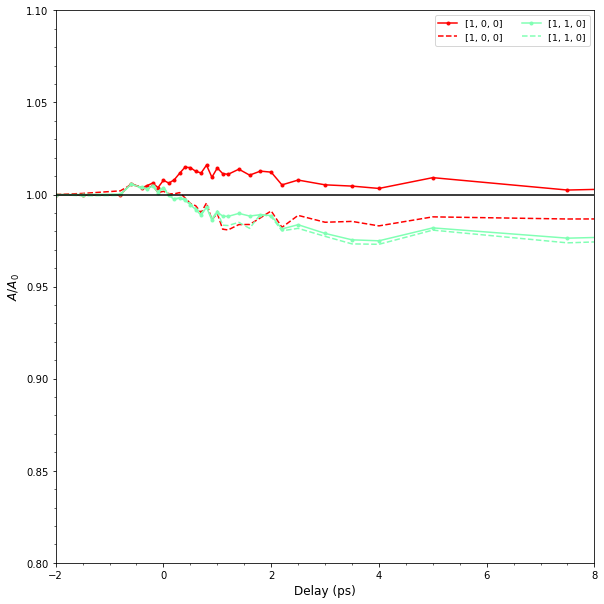

In [22]:
fig, ax1 = plt.subplots(nrows =1, figsize = (10.2/1.2, 10.2/1.2))
cmap = plt.get_cmap('rainbow')
for j, bragg in enumerate(igor_bragg_list):
    sel_bragg = (dif.allBragg_indices_2[:,0] == bragg[0])&(dif.allBragg_indices_2[:,1] == bragg[1])
    fits = dif.bragg_fits_binned_delays[:,sel_bragg,:]
#     fits = bragg_fits_simetrised[:,sel_bragg,:]

#     amps_t0 = bragg_fits_simetrised[i,:,0]

#     q = coef*np.sqrt((fits[:,0,1] - dif.centerpos[0])**2 + (fits[:,0,2] - dif.centerpos[1])**2)
    q = dif.bragg_fits_simetrised_q[:,sel_bragg]
    q.shape= len(q)
    
    color = cmap((len(igor_bragg_list) - float(j))/len(igor_bragg_list))
    
#     amp_corrected = (np.sqrt(fits[:,0,0] + azimuthal_vals_bkg_intrp(q)) - sqrt_azimuthal_vals_bkg_intrp(q))**2
    amp_corrected = (np.sqrt(dif.bragg_fits_simetrised[:,sel_bragg,:][:,0,0] + dif.static.background.azimuthal_vals_bkg_intrp(q)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q))**2

    ax1.plot(dif.bincenters, amp_corrected/amp_corrected[0], '.-', color = color, label = bragg)
#     ax1.plot(dif.bincenters, amp_DW_Warren_method[:, sel_bragg] / amp_DW_Warren_method[0, sel_bragg], '--', color = color, label = bragg)
    ax1.plot(dif.bincenters, amp_DW_Warren_120idx[:, sel_bragg] / amp_DW_Warren_120idx[0, sel_bragg], '--', color = color, label = bragg)


    
ax1.set_xlabel('Delay (ps)', fontsize = 12)
ax1.set_ylabel('$A/A_0$', fontsize = 12)
ax1.set_xlim(-2,8)
ax1.set_ylim(0.8,1.1)

# ax1.set_xlim(-2,20)


ax1.legend(ncol = 2, fontsize = 9.5)
ax1.axhline(1, c='k')
plt.tight_layout()


Text(0.5, 139.16666666666669, 'Delay (ps)')

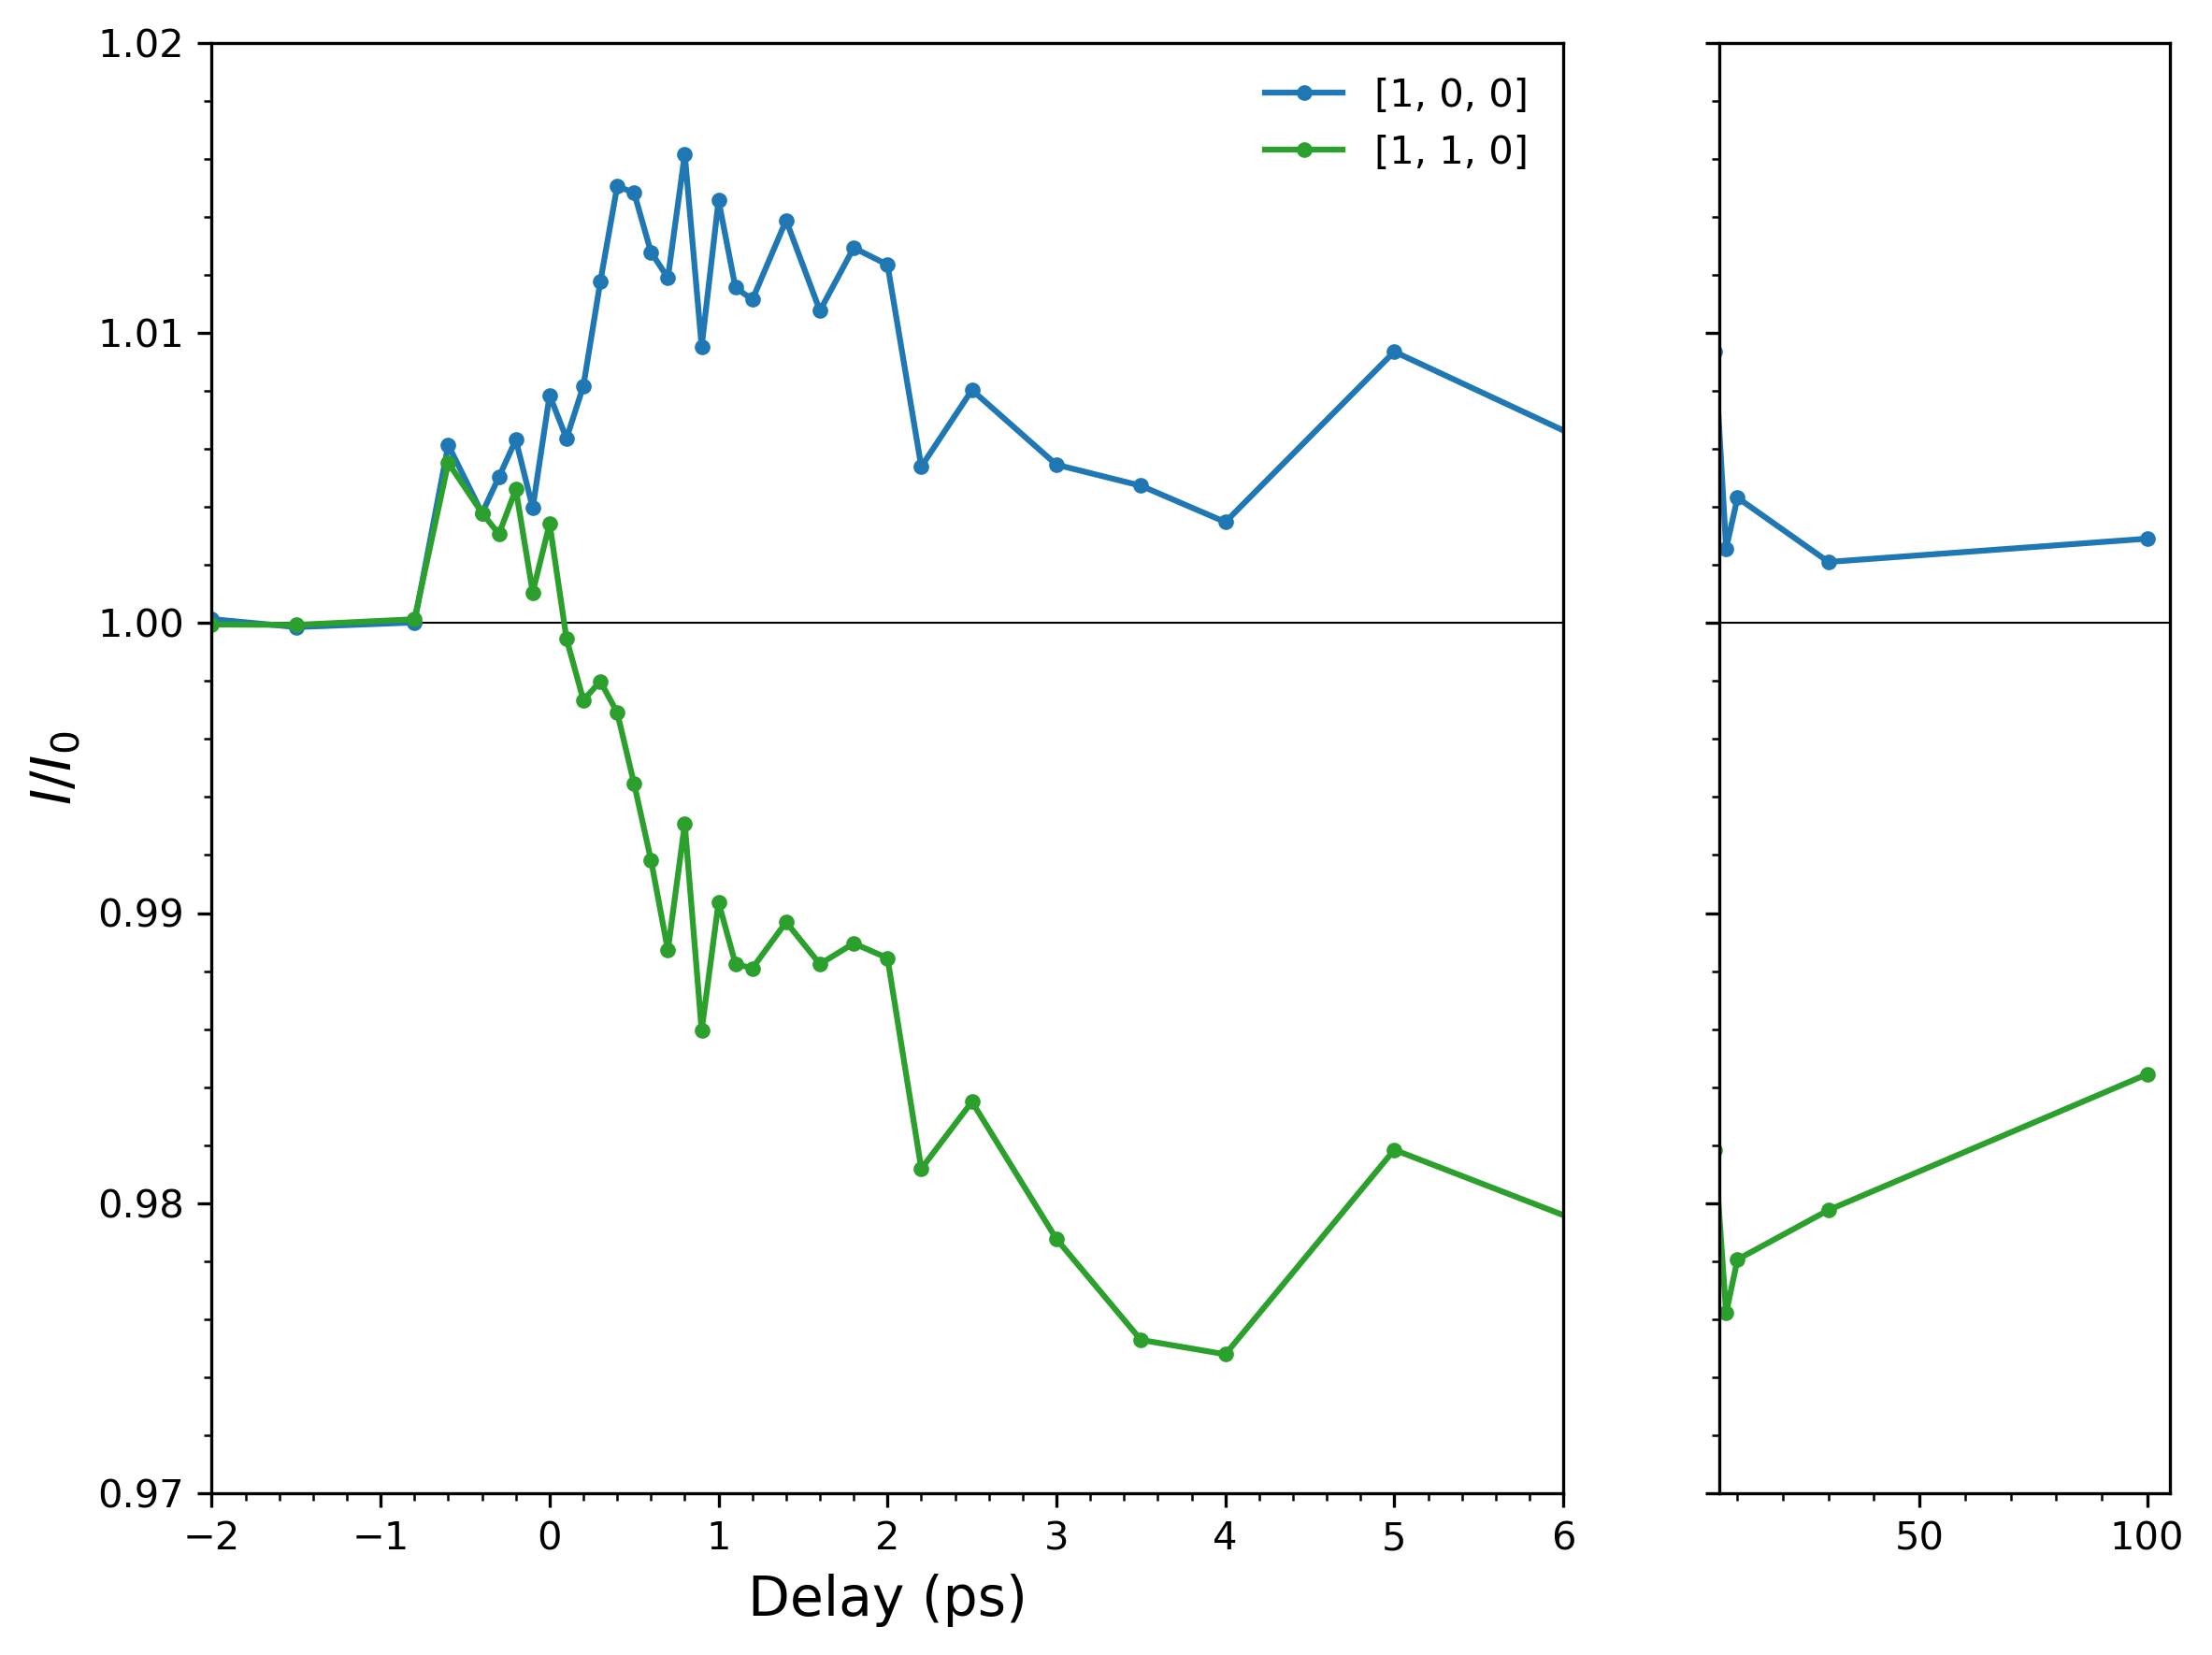

In [23]:
fig, [ax1,ax2] = plt.subplots(ncols=2,nrows=1, gridspec_kw={'width_ratios': [3, 1]}, figsize = (8,6),dpi=300)# sharex=True)

fig.subplots_adjust(hspace=.05)
fig.subplots_adjust(wspace=.05)
# fig.tight_layout()

ax1.axhline(1, lw=0.5, c='k')
ax2.axhline(1, lw=0.5, c='k')

cmap = plt.get_cmap('rainbow')
for j, bragg in enumerate(igor_bragg_list):
    sel_bragg_sym = (dif.compact_hkl[:,0] == bragg[0])&(dif.compact_hkl[:,1] == bragg[1])
    amp_corrected = dif.volumes_symmetrised_compact[np.where(sel_bragg_sym)[0][0]]
    amp_corrected_error =dif.volumes_symmetrised_compact_errors[np.where(sel_bragg_sym)[0][0]]
    
    I_tmp = amp_corrected
#     I_tmp_error = fit_errors[:,0,0]




    
    sel_bragg = (dif.allBragg_indices_2[:,0] == bragg[0])&(dif.allBragg_indices_2[:,1] == bragg[1])
    fits = dif.bragg_fits_binned_delays[:,sel_bragg,:]
#     fits = bragg_fits_simetrised[:,sel_bragg,:]

#     amps_t0 = bragg_fits_simetrised[i,:,0]

#     q = coef*np.sqrt((fits[:,0,1] - dif.centerpos[0])**2 + (fits[:,0,2] - dif.centerpos[1])**2)
    q = dif.bragg_fits_simetrised_q[:,sel_bragg]
    q.shape= len(q)
    
    color = cmap((len(igor_bragg_list) - float(j))/len(igor_bragg_list))
    color = f'C{j*2}'
    amp_corrected = (np.sqrt(dif.bragg_fits_simetrised[:,sel_bragg,:][:,0,0] + dif.static.background.azimuthal_vals_bkg_intrp(q)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q))**2
# dif.volumes_symmetrised_compact = dif.volumes_symmetrised_compact[1:]
# dif.volumes_symmetrised_compact_errors = dif.volumes_symmetrised_compact_errors[1:]
    ax1.plot(dif.bincenters, I_tmp/I_tmp[0:3].mean(), '.-', color = color, label = bragg)
    ax2.plot(dif.bincenters, I_tmp/I_tmp[0:3].mean(), '.-', color = color, label = bragg)



    
ax1.set_xlabel('Delay (ps)', fontsize = 14)
ax1.set_ylabel('$I/I_0$', fontsize = 14)
# ax1.set_xlim(-2,6)
# ax1.set_ylim(0.8,1.1)
ax1.set_ylim(0.97,1.02)
ax2.set_ylim(0.97,1.02)

# ax1.set_xlim(-2,20)


# ax1.legend(ncol = 2, fontsize = 12)
ax1.legend(ncol = 1, fontsize = 12, frameon = False)

# ax1.axhline(1, c='k')
plt.tight_layout()


# ax1.set_ylabel('$q/q_0$', fontsize = 14)
ax1.legend(fontsize = 10, frameon=False)
ax1.set_xlim(-2,6)
ax2.set_xlim(6,105)
ax2.set_yticklabels([]);
ax1.set_xlabel('Delay (ps)', fontsize = 14)



### previous method doesn't seem so good. Fit with a fixef K1 and K2, the Bfactors change

In [24]:
print((b1_t_mean))
print((b2_t_mean))

1.6804664007314176
1.9718964111856596


In [25]:
def fixed_linear_k1(x,a1):
    constant1 = b1_t_mean
#     k1 = np.log(K1_avg)
#     k1 = np.log(0.5*K2_avg+ 0.5*K1_avg)

    
    return a1*x + constant1

def fixed_linear_k2(x,a2):

#     k2 = np.log(K2_avg)
    constant2 = b2_t_mean
#     k2 = np.log(0.5*K2_avg+ 0.5*K1_avg)

    return a2*x + constant2

In [26]:
dif.dw_Warren_fixed_k = pd.DataFrame()

dif.dw_Warren_fixed_k['a1_t_kfixed'] = np.zeros(35)
dif.dw_Warren_fixed_k['a2_t_kfixed'] = np.zeros(35)

dif.dw_Warren_fixed_k['a1_t_kfixed_cov'] = np.zeros(35)
dif.dw_Warren_fixed_k['a2_t_kfixed_cov'] = np.zeros(35)

# a1_t_kfixed = np.zeros(35)
# a2_t_kfixed = np.zeros(35)

# a1_t_kfixed_cov = np.zeros(35)
# a2_t_kfixed_cov = np.zeros(35)

for i in np.arange(35):
    
#     amps_t0 = dif.compact[:,i,0]*dif.compact[:,i,3]*dif.compact[:,i,4]
    amps_t0 = dif.volumes_symmetrised_compact[:,i]

    q_vecs_t0 = dif.q_symmetrised_compact[:,i]
    
#     amps_t_corrected = (np.sqrt(amps_t0 + dif.static.background.azimuthal_vals_bkg_intrp(q_vecs_t0)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q_vecs_t0))**2
    amps_t_corrected = amps_t0



#     sel_even = np.sum(np.asarray(dif.compact_hkl), axis = 1) %2 ==0
#     sel_odd =  np.sum(np.asarray(dif.compact_hkl), axis = 1) %2 ==1
    
    sel_even = np.sum(np.asarray(dif.compact_hkl), axis = 1) %2 == 0
    sel_odd =  np.sum(np.asarray(dif.compact_hkl), axis = 1) %2 == 1

    sel_even_not_nan = ~np.isnan(np.sqrt(amps_t_corrected[sel_even]))&(amps_t_corrected[sel_even]  >0 )
    sel_odd_not_nan =  ~np.isnan(np.sqrt(amps_t_corrected[sel_odd ]))&(amps_t_corrected[sel_odd]  >0 )
    
    
    test_q_array = np.arange(np.min(q_vecs_t0), np.max(q_vecs_t0), 0.1)

    even_sorted_args = np.argsort(q_vecs_t0[sel_even][sel_even_not_nan])
    odd_sorted_args = np.argsort(q_vecs_t0[sel_odd][sel_odd_not_nan])

    spl_Warren_Q_even = interpolate.splrep(q_vecs_t0[sel_even][sel_even_not_nan][even_sorted_args], 
                                           np.sqrt(amps_t_corrected[sel_even][sel_even_not_nan][even_sorted_args]), 
                                           k =2)
    spl_Warren_Q_odd =  interpolate.splrep(q_vecs_t0[sel_odd][sel_odd_not_nan][odd_sorted_args], 
                                           np.sqrt(amps_t_corrected[sel_odd][sel_odd_not_nan][odd_sorted_args]) 
                                          )
    print(np.sqrt(amps_t_corrected[sel_odd][sel_odd_not_nan][odd_sorted_args]))
    print(amps_t_corrected[sel_odd][sel_odd_not_nan][odd_sorted_args])

    # Warren Q : interpolated energy dependence for odd/even peaks separatedly
    Warren_Q_even2 = interpolate.splev(test_q_array, spl_Warren_Q_even)
    Warren_Q_odd2  = interpolate.splev(test_q_array, spl_Warren_Q_odd)
    Warren_Q_even_plot = interpolate.splev(q_vecs_t0, spl_Warren_Q_even)
    Warren_Q_odd_plot  = interpolate.splev(q_vecs_t0, spl_Warren_Q_odd)
    
    Warren_f_Fe = dt.electron_form_factor(test_q_array, element = 'Fe')
    Warren_f_Pt = dt.electron_form_factor(test_q_array, element = 'Pt')
    Warren_f_Fe_plot = dt.electron_form_factor(q_vecs_t0, element = 'Fe')
    Warren_f_Pt_plot = dt.electron_form_factor(q_vecs_t0, element = 'Pt')

    sel_low_q =( test_q_array**2 < dif.max_q)&(test_q_array**2 > dif.min_q)

#     
        # the good one I think 

    sum_warren_kfixed = (Warren_Q_even2 + Warren_Q_odd2)
    diff_warren_kfixed = (Warren_Q_even2 - Warren_Q_odd2)
    skip_odd_mask = np.where(diff_warren_kfixed[sel_low_q] > 0)
    
#     print(Warren_Q_even2)
#     print(Warren_Q_odd2)
#     print(sum_warren_kfixed)
#     print(np.log(sum_warren_kfixed/(2*Warren_f_Pt) )[sel_low_q])
    
    a1, a1_cov = opt.curve_fit(fixed_linear_k1, (test_q_array**2)[sel_low_q], np.log(sum_warren_kfixed/(2*Warren_f_Pt) )[sel_low_q], p0=[-0.013356657435999895])
    a2, a2_cov = opt.curve_fit(fixed_linear_k2, (test_q_array**2)[sel_low_q][skip_odd_mask], np.log(diff_warren_kfixed[sel_low_q][skip_odd_mask]/(2*Warren_f_Fe[sel_low_q][skip_odd_mask]) ), p0=[-0.02124717939977886])

    dif.dw_Warren_fixed_k.a1_t_kfixed[i] = a1 
    dif.dw_Warren_fixed_k.a2_t_kfixed[i] = a2 
    
    dif.dw_Warren_fixed_k.a1_t_kfixed_cov[i] = a1_cov 
    dif.dw_Warren_fixed_k.a2_t_kfixed_cov[i] = a2_cov 


[10.53602303  4.91688534  3.58079331  2.88908676  2.5797895   2.11218636]
[111.00778125  24.17576143  12.82208071   8.34682233   6.65531386
   4.46133123]
[10.53457481  4.91369429  3.57914821  2.89356236  2.5804397   2.11478973]
[110.9772664   24.14439161  12.81030189   8.37270316   6.65866902
   4.47233561]
[10.53541128  4.91713992  3.58121696  2.89458682  2.58238244  2.10890844]
[110.99489088  24.17826497  12.82511491   8.37863288   6.66869907
   4.44749482]
[10.56756941  4.93014103  3.59018006  2.8966766   2.58460632  2.11363192]
[111.67352331  24.30629054  12.8893929    8.39073532   6.68018983
   4.46743991]
[10.55522507  4.92900135  3.58683561  2.89975134  2.58692504  2.11070354]
[111.41277633  24.29505427  12.86538968   8.40855782   6.69218114
   4.45506945]
[10.56178417  4.92705801  3.58673762  2.89787029  2.58308203  2.1190571 ]
[111.55128481  24.27590061  12.86468679   8.39765224   6.67231276
   4.49040299]
[10.56851893  4.93339427  3.58647283  2.89806137  2.58410824  2.115947

/cds/home/d/diegotur/.conda/envs/diego_test_py3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in log


[10.62009351  4.94980021  3.55246364  2.83073474  2.48012377  1.96052669]
[112.78638609  24.5005221   12.61999793   8.01305918   6.15101394
   3.84366491]
[10.58538422  4.93617781  3.53003611  2.81900238  2.45930641  1.94605763]
[112.05035905  24.36585137  12.46115493   7.94677441   6.04818802
   3.78714029]
[10.61176171  4.9410952   3.53308762  2.814088    2.45680194  1.94121187]
[112.60948667  24.41442174  12.48270816   7.91909127   6.03587577
   3.76830354]
[10.59604813  4.9347291   3.52296883  2.80879965  2.44525871  1.92467707]
[112.27623602  24.35155127  12.41130937   7.88935548   5.97929016
   3.70438181]
[10.59384984  4.93068593  3.52385822  2.80756031  2.4370637   1.92216793]
[112.22965434  24.31166374  12.41757673   7.88239488   5.93927945
   3.69472954]
[10.6081621   4.92725106  3.5177161   2.79854521  2.4315578   1.90852489]
[112.53310313  24.27780296  12.37432657   7.83185527   5.91247335
   3.64246726]
[10.59185635  4.91440701  3.51051795  2.79072561  2.42607676  1.903256

/cds/home/d/diegotur/.conda/envs/diego_test_py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Text(0, 0.5, '$ ln( \\frac{0(Q_{even} \\pm Q_{odd})}{2f} )$')

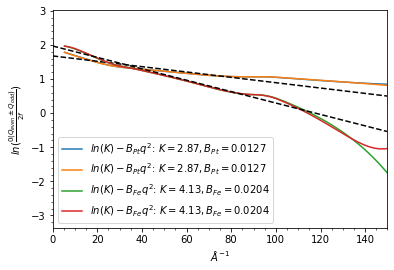

In [27]:
plt.figure()

plt.plot(test_q_array**2, np.log((Warren_Q_even + Warren_Q_odd)/(2*Warren_f_Pt) ), label = r'$ln(K) - B_{Pt} q^2 $' + r': $K = 2.87 , B_{Pt} = 0.0127$'  )
plt.plot(test_q_array**2, np.log((Warren_Q_even2 + Warren_Q_odd2)/(2*Warren_f_Pt) ), label = r'$ln(K) - B_{Pt} q^2 $' + r': $K = 2.87 , B_{Pt} = 0.0127$'  )

plt.plot(np.arange(0,17, .1)**2, fixed_linear_k1(np.arange(0,17, .1)**2,dif.dw_Warren_fixed_k.a1_t_kfixed.values[-1] ), '--', c='k', )

plt.plot(test_q_array**2, np.log((Warren_Q_even - Warren_Q_odd)/(2*Warren_f_Fe) ), label = r'$ln(K) - B_{Fe} q^2 $' + r': $K = 4.13 , B_{Fe} = 0.0204$'  )
plt.plot(test_q_array**2, np.log((Warren_Q_even2 - Warren_Q_odd2)/(2*Warren_f_Fe) ), label = r'$ln(K) - B_{Fe} q^2 $' + r': $K = 4.13 , B_{Fe} = 0.0204$'  )

plt.plot(np.arange(0,17, .1)**2, fixed_linear_k2(np.arange(0,17, .1)**2,dif.dw_Warren_fixed_k.a2_t_kfixed.values[-1] ), '--', c='k', )


plt.legend()

plt.xlim(0,150)

plt.xlabel(r'$ \AA^{-1} $')
plt.ylabel(r'$ ln( \frac{0(Q_{even} \pm Q_{odd})}{2f} )$')

In [28]:
print(-dif.dw_Warren_fixed_k.a1_t_kfixed.values[0])
print(-dif.dw_Warren_fixed_k.a2_t_kfixed.values[0])

0.007115877680317795
0.015543526657899527


In [29]:

print('BPt DFT: ' + str(0.009399430338440849)) # from Jakubs DFT 
print('BFe DFT: ' + str(0.01660462290744712 ))  # from Jakubs DFT


BPt DFT: 0.009399430338440849
BFe DFT: 0.01660462290744712


In [30]:
#1 Recalculate Intensities with the DW factors
B_Fe = -dif.dw_Warren_fixed_k.a2_t_kfixed.values
B_Pt = -dif.dw_Warren_fixed_k.a1_t_kfixed.values

prop_factor_t = (np.exp(0.5*dif.dw_Warren_vary_B.b1_t.values + 0.5*dif.dw_Warren_vary_B.b2_t.values)**2)
amp_DW_Warren_method_kfixed = np.zeros((dif.bincenters.shape[0], 120))

K1_avg = np.exp(dif.dw_Warren_vary_B.b1_t.values).mean()
K2_avg = np.exp(dif.dw_Warren_vary_B.b2_t.values).mean()


for t_idx in np.arange(dif.bincenters.shape[0]):
    q_vecs_t0 = dif.bragg_fits_simetrised_q[t_idx]    
    
#     amp_DW_Warren_method_kfixed[t_idx] = I_UED_dt.I_UED_f_warren_120idx(Bfe=B_Fe[t_idx], Bpt=B_Pt[t_idx], K_odd = K1_avg, K_even = K2_avg,bragg_q=q_vecs_t0, allBragg_indices_2=allBragg_indices_2  ) #OG with avg times
    amp_DW_Warren_method_kfixed[t_idx] = I_UED_dt.I_UED_f_warren_120idx(Bfe=B_Fe[t_idx], Bpt=B_Pt[t_idx], K_odd = 0.5*K1_avg+0.5*K2_avg, K_even = 0.5*K1_avg+0.5*K2_avg,bragg_q=q_vecs_t0, allBragg_indices_2=dif.allBragg_indices_2  ) #OG with avg times
#     amp_DW_Warren_method_kfixed[t_idx] = I_UED_dt.I_UED_f_warren_120idx(Bfe=B_Fe[t_idx], Bpt=B_Pt[t_idx], K_odd = np.exp(b2_t)[t_idx],   K_even = np.exp(b1_t)[t_idx],  bragg_q=q_vecs_tmp,allBragg_indices_2=allBragg_indices_2  ) #OG time dependent


#### Checked the quality of the fit and somehow it's worse than before

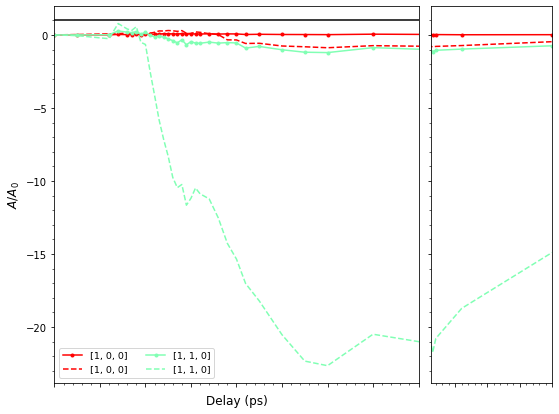

In [31]:
# fig, ax1 = plt.subplots(nrows =1, figsize = (10.2/1.2, 10.2/1.2))
fig, [ax1, ax2] = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [3, 1]}, figsize = (8,12/2))#,dpi=300)# sharex=True)

cmap = plt.get_cmap('rainbow')
for j, bragg in enumerate(igor_bragg_list):
    sel_bragg = (dif.allBragg_indices_2[:,0] == bragg[0])&(dif.allBragg_indices_2[:,1] == bragg[1])
    fits = dif.bragg_fits_binned_delays[:,sel_bragg,:]
    q = dif.bragg_fits_simetrised_q[:,sel_bragg]
    q.shape= len(q)
    
    color = cmap((len(igor_bragg_list) - float(j))/len(igor_bragg_list))
    
    amp_corrected = (np.sqrt(dif.bragg_fits_simetrised[:,sel_bragg,:][:,0,0] + dif.static.background.azimuthal_vals_bkg_intrp(q)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q))**2
     
    ax1.plot(dif.bincenters, amp_corrected-amp_corrected[0], '.-', color = color, label = bragg)
    ax1.plot(dif.bincenters, amp_DW_Warren_method_kfixed[:, sel_bragg] - amp_DW_Warren_method_kfixed[0, sel_bragg], '--', color = color, label = bragg)

    ax2.plot(dif.bincenters, amp_corrected-amp_corrected[0], '.-', color = color, label = bragg)
    ax2.plot(dif.bincenters, amp_DW_Warren_method_kfixed[:, sel_bragg] - amp_DW_Warren_method_kfixed[0, sel_bragg], '--', color = color, label = bragg)

    
ax1.set_xlabel('Delay (ps)', fontsize = 12)
ax1.set_ylabel('$A/A_0$', fontsize = 12)
ax1.set_xlim(-2,6)

ax2.set_xlim(6,100)

ax1.legend(ncol = 2, fontsize = 9.5)
ax1.axhline(1, c='k')
plt.tight_layout()

fig.subplots_adjust(hspace=.05)
fig.subplots_adjust(wspace=.05)
ax2.set_yticklabels([]);

ax1.set_xticklabels([]);
ax2.set_xticklabels([]);

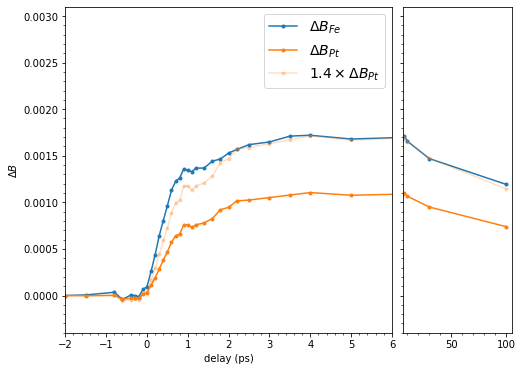

In [32]:
# fig, axs = plt.subplots(ncols=2, sharey=True,gridspec_kw={'width_ratios': [3, 1],'wspace': 0.05 }, figsize=(8/2,8/2), dpi=150)#,dpi=300)
fig, axs = plt.subplots(ncols=2, sharey=True,gridspec_kw={'width_ratios': [3, 1]}, figsize = (8,12/2))#, dpi=150)#,dpi=300)
fig.subplots_adjust(hspace=.05)
fig.subplots_adjust(wspace=.05)

axs[0].plot(dif.bincenters, (-dif.dw_Warren_fixed_k.a2_t_kfixed.values + dif.dw_Warren_fixed_k.a2_t_kfixed.values[0]), '.-', label = r'$\Delta B_{Fe}$')
axs[0].plot(dif.bincenters, 1.*(-dif.dw_Warren_fixed_k.a1_t_kfixed.values + dif.dw_Warren_fixed_k.a1_t_kfixed.values[0]), '.-', label = r'$\Delta B_{Pt}$')
axs[1].plot(dif.bincenters, (-dif.dw_Warren_fixed_k.a2_t_kfixed.values + dif.dw_Warren_fixed_k.a2_t_kfixed.values[0]), '.-', label = r'$\Delta B_{Fe}$')
axs[1].plot(dif.bincenters, 1.*(-dif.dw_Warren_fixed_k.a1_t_kfixed.values + dif.dw_Warren_fixed_k.a1_t_kfixed.values[0]), '.-', label = r'$\Delta B_{Pt}$')

axs[0].plot(dif.bincenters, 1.55*(-dif.dw_Warren_fixed_k.a1_t_kfixed.values + dif.dw_Warren_fixed_k.a1_t_kfixed.values[0]), '.-',c='C1', alpha = 0.25, label = r'$1.4 \times \Delta B_{Pt}$')
axs[1].plot(dif.bincenters, 1.55*(-dif.dw_Warren_fixed_k.a1_t_kfixed.values + dif.dw_Warren_fixed_k.a1_t_kfixed.values[0]), '.-',c='C1', alpha = 0.25, label = r'$1.4 \times \Delta B_{Pt}$')

axs[0].set_ylabel(r'$\Delta B$')
axs[0].set_xlabel('delay (ps)')
axs[0].set_xlim(-2,6)
axs[1].set_xlim(6,105)
axs[0].set_ylim((-0.0004,0.0031))
axs[1].set_ylim((-0.0004,0.0031))

axs[0].legend(fontsize = 14)

In [33]:
print(' B_Fe (t<0)' +' ' + str(-dif.dw_Warren_fixed_k.a2_t_kfixed.values[0]) )
print(' B_Pt (t<0)' +' ' + str(-dif.dw_Warren_fixed_k.a1_t_kfixed.values[0]) )

 B_Fe (t<0) 0.015543526657899527
 B_Pt (t<0) 0.007115877680317795


## Fitting Amp/Amp0 instead

In [34]:

# tmp_a0 = dif.compact[:,0,0]*dif.compact[:,0,3]*dif.compact[:,0,4] # keeps only amplitudes at t0 
# tmp_a0 = dif.volumes_symmetrised_compact[:,0:5].mean(axis = 1)
tmp_a0 = dif.volumes_symmetrised_compact[:,0]

good_bragg_fit_mask =( tmp_a0!= 0)&(~np.isnan(tmp_a0)) # this is boolean mask that indexes all braggs of interest 

# amps_tmp  = dif.compact[:,:,0]*dif.compact[:,:,3]*dif.compact[:,:,4] # keeps all time delays
amps_tmp = dif.volumes_symmetrised_compact
amps_tmp = amps_tmp[good_bragg_fit_mask,:]


q_vecs_tmp = dif.q_symmetrised_compact[:,0][good_bragg_fit_mask] # ! need to change this !!! 

print(dif.max_q)
#filter out q vetors higher than 10 A-1
# sel_low_q =  q_vecs_tmp**2 < dif.max_q
sel_low_q = (q_vecs_tmp**2 < dif.max_q)&(q_vecs_tmp**2 > dif.min_q )
# sel_low_q =  q_vecs_tmp**2 < 300
# sel_low_q =  q_vecs_tmp**2 < 50

q_vecs_tmp = q_vecs_tmp[sel_low_q]

amps_tmp = amps_tmp[sel_low_q, :]
good_bragg_fit_mask[np.where(good_bragg_fit_mask)[0][~sel_low_q]] = False

tmp_a0 = tmp_a0[good_bragg_fit_mask]  

amps_tmp = amps_tmp.T/tmp_a0

100


In [35]:
# a small name change to make it compatible with some old code
y_fit_all = amps_tmp

In [36]:
# to date, I haven't found a better way to define the function bellow....
test = ''
for i in np.arange(35):
    test = test + f'Bpt{i}, '
print(test)

Bpt0, Bpt1, Bpt2, Bpt3, Bpt4, Bpt5, Bpt6, Bpt7, Bpt8, Bpt9, Bpt10, Bpt11, Bpt12, Bpt13, Bpt14, Bpt15, Bpt16, Bpt17, Bpt18, Bpt19, Bpt20, Bpt21, Bpt22, Bpt23, Bpt24, Bpt25, Bpt26, Bpt27, Bpt28, Bpt29, Bpt30, Bpt31, Bpt32, Bpt33, Bpt34, 


In [37]:
# to date, I haven't found a better way to define the function bellow....
test = ''
for i in np.arange(35):
    test = test + f'Bfe{i}, '
print(test)

Bfe0, Bfe1, Bfe2, Bfe3, Bfe4, Bfe5, Bfe6, Bfe7, Bfe8, Bfe9, Bfe10, Bfe11, Bfe12, Bfe13, Bfe14, Bfe15, Bfe16, Bfe17, Bfe18, Bfe19, Bfe20, Bfe21, Bfe22, Bfe23, Bfe24, Bfe25, Bfe26, Bfe27, Bfe28, Bfe29, Bfe30, Bfe31, Bfe32, Bfe33, Bfe34, 


In [38]:
def DW_func_test(q,
                 Bpt0, Bpt1, Bpt2, Bpt3, Bpt4, Bpt5, Bpt6, Bpt7, Bpt8, Bpt9, Bpt10, Bpt11, Bpt12, Bpt13, Bpt14, Bpt15, Bpt16, Bpt17,
                 Bpt18, Bpt19, Bpt20, Bpt21, Bpt22, Bpt23, Bpt24, Bpt25, Bpt26, Bpt27, Bpt28, Bpt29, Bpt30, Bpt31, Bpt32, Bpt33, Bpt34, 
                 
                 Bfe0, Bfe1, Bfe2, Bfe3, Bfe4, Bfe5, Bfe6, Bfe7, Bfe8, Bfe9, Bfe10, Bfe11, Bfe12, Bfe13, Bfe14, Bfe15, Bfe16, Bfe17, Bfe18,
                 Bfe19, Bfe20, Bfe21, Bfe22, Bfe23, Bfe24, Bfe25, Bfe26, Bfe27, Bfe28, Bfe29, Bfe30, Bfe31, Bfe32, Bfe33, Bfe34, 
                 
                 BPT0, BFE0):
    '''
    '''
    
    y_out = np.asarray([])
    
    Bpt_list = [Bpt0, Bpt1, Bpt2, Bpt3, Bpt4, Bpt5, Bpt6, Bpt7, Bpt8, Bpt9, Bpt10, Bpt11, Bpt12, Bpt13, Bpt14, Bpt15, Bpt16, Bpt17,
                 Bpt18, Bpt19, Bpt20, Bpt21, Bpt22, Bpt23, Bpt24, Bpt25, Bpt26, Bpt27, Bpt28, Bpt29, Bpt30, Bpt31, Bpt32, Bpt33, Bpt34,]
    
    Bfe_list = [ Bfe0, Bfe1, Bfe2, Bfe3, Bfe4, Bfe5, Bfe6, Bfe7, Bfe8, Bfe9, Bfe10, Bfe11, Bfe12, Bfe13, Bfe14, Bfe15, Bfe16, Bfe17, Bfe18,
                 Bfe19, Bfe20, Bfe21, Bfe22, Bfe23, Bfe24, Bfe25, Bfe26, Bfe27, Bfe28, Bfe29, Bfe30, Bfe31, Bfe32, Bfe33, Bfe34,]
    for i in range(len(Bpt_list)):
        Bpt = Bpt_list[i]
        Bfe = Bfe_list[i]

        y_tmp = I_UED_dt.I_UED_f_warren_prop_norm2(Bfe, Bpt,BFE0, BPT0, q, dif.compact_hkl[good_bragg_fit_mask])
        y_out = np.append(y_out,y_tmp)

    return y_out



def DW_func_test2(q_arr,
                 Bpt0, Bpt1, Bpt2, Bpt3, Bpt4, Bpt5, Bpt6, Bpt7, Bpt8, Bpt9, Bpt10, Bpt11, Bpt12, Bpt13, Bpt14, Bpt15, Bpt16, Bpt17,
                 Bpt18, Bpt19, Bpt20, Bpt21, Bpt22, Bpt23, Bpt24, Bpt25, Bpt26, Bpt27, Bpt28, Bpt29, Bpt30, Bpt31, Bpt32, Bpt33, Bpt34, 
                 
                 Bfe0, Bfe1, Bfe2, Bfe3, Bfe4, Bfe5, Bfe6, Bfe7, Bfe8, Bfe9, Bfe10, Bfe11, Bfe12, Bfe13, Bfe14, Bfe15, Bfe16, Bfe17, Bfe18,
                 Bfe19, Bfe20, Bfe21, Bfe22, Bfe23, Bfe24, Bfe25, Bfe26, Bfe27, Bfe28, Bfe29, Bfe30, Bfe31, Bfe32, Bfe33, Bfe34, 
                 
                 BPT0, BFE0):
    '''
    '''
    q_arr2 = q_arr.reshape((good_bragg_fit_mask.sum(),35))
    y_out = np.asarray([])
    
    Bpt_list = [Bpt0, Bpt1, Bpt2, Bpt3, Bpt4, Bpt5, Bpt6, Bpt7, Bpt8, Bpt9, Bpt10, Bpt11, Bpt12, Bpt13, Bpt14, Bpt15, Bpt16, Bpt17,
                 Bpt18, Bpt19, Bpt20, Bpt21, Bpt22, Bpt23, Bpt24, Bpt25, Bpt26, Bpt27, Bpt28, Bpt29, Bpt30, Bpt31, Bpt32, Bpt33, Bpt34,]
    
    Bfe_list = [ Bfe0, Bfe1, Bfe2, Bfe3, Bfe4, Bfe5, Bfe6, Bfe7, Bfe8, Bfe9, Bfe10, Bfe11, Bfe12, Bfe13, Bfe14, Bfe15, Bfe16, Bfe17, Bfe18,
                 Bfe19, Bfe20, Bfe21, Bfe22, Bfe23, Bfe24, Bfe25, Bfe26, Bfe27, Bfe28, Bfe29, Bfe30, Bfe31, Bfe32, Bfe33, Bfe34,]
    for i in range(len(Bpt_list)):
        q = q_arr2[:,i]
        Bpt = Bpt_list[i]
        Bfe = Bfe_list[i]

        y_tmp = I_UED_dt.I_UED_f_warren_prop_norm2(Bfe, Bpt,BFE0, BPT0, q, dif.compact_hkl[good_bragg_fit_mask])
        y_out = np.append(y_out,y_tmp)

    return y_out



In [39]:
p0 = [ *(-dif.dw_Warren_fixed_k.a1_t_kfixed.values), *(-dif.dw_Warren_fixed_k.a2_t_kfixed.values),  
      (-dif.dw_Warren_fixed_k.a1_t_kfixed.values)[0], (-dif.dw_Warren_fixed_k.a2_t_kfixed.values)[0]]

In [ ]:
%%time
# popt, pcov = opt.curve_fit(DW_func_test,
# #                           q_vecs_t0[good_bragg_fit_mask],
#                            q_vecs_tmp,
#                            y_fit_all.ravel(),
#                            p0 = p0,
# #                            bounds = (0, np.inf)
#                           )


# %%time
popt, pcov = opt.curve_fit(DW_func_test2,
#                           q_vecs_t0[good_bragg_fit_mask],
                           dif.q_symmetrised_compact[:,:][good_bragg_fit_mask].ravel(), 
                           y_fit_all.ravel(),
                           p0 = p0,
#                            bounds = (0, np.inf)
                          )

In [ ]:
dif.Bpt_time_test_warren_glob = popt[:35]
dif.Bfe_time_test_warren_glob = popt[35:70]
dif.BPT0 = popt[-2]
dif.BFE0 = popt[-1]


perr = np.sqrt(np.diag(pcov))
dif.pcov_B_fit = copy.copy(pcov)

dif.Bpt_time_test_warren_glob_error = perr[:35]
dif.Bfe_time_test_warren_glob_error = perr[35:70]

dif.BPT0_err = perr[-2]
dif.BFE0_err = perr[-1]


In [ ]:

dif.B_fe_err_tmp = np.abs(dif.Bfe_time_test_warren_glob_error - dif.Bfe_time_test_warren_glob_error[0])
dif.B_pt_err_tmp = np.abs(dif.Bpt_time_test_warren_glob_error - dif.Bpt_time_test_warren_glob_error[0])

dif.B_fe_err_tmp2 = np.sqrt(np.abs(dif.Bfe_time_test_warren_glob_error**2 + dif.Bfe_time_test_warren_glob_error[0]**2 - 2*dif.pcov_B_fit[35:70, 35]))
dif.B_pt_err_tmp2 = np.sqrt(np.abs(dif.Bpt_time_test_warren_glob_error**2 + dif.Bpt_time_test_warren_glob_error[0]**2 - 2*dif.pcov_B_fit[0:35, 0]))



### fitting DW

In [ ]:
plt.figure()
plt.plot(dif.bincenters[0:], (dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0])[0:], '.-')
plt.plot(dif.bincenters[0:], (dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0])[0:], '.-')
plt.plot(dif.bincenters[0:], 2.5*(dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0])[0:], '.-', color = 'C1', alpha = 0.25)

plt.axhline(0, ls='--', c='k', alpha=0.25)

# plt.axhline(0.0055, ls='--', c='k', alpha=0.25)
# plt.axhline(0.0055/4, ls='--', c='k', alpha=0.25)

# plt.ylim(-0.001,0.01)
plt.xlim(-2,6)

In [ ]:
p0_DW = [0.0020, 0.3, 0.0010, 2.7, 0.0012, 25.5]

# dif.popt_Fe_DW, dif.pcov_Fe_DW = opt.curve_fit(dt.two_expssum_2_with_rec_tau , dif.bincenters[9:], (dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0])[9:],p0=p0_DW,sigma=dif.B_fe_err_tmp2[9:],  bounds = [-0.001, np.inf])#bounds =[[0,0,0, 0,-np.inf,0],[np.inf,np.inf,np.inf, np.inf,0.000001,np.inf ]])
# dif.popt_Pt_DW, dif.pcov_Pt_DW = opt.curve_fit(dt.two_expssum_2_with_rec_tau , dif.bincenters[9:], (dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0])[9:],p0=p0_DW,sigma=dif.B_pt_err_tmp2[9:],   bounds = [-0.001, np.inf] )#bounds =[[0,0,0, 0,-np.inf,0],[np.inf,np.inf,np.inf, np.inf,0.000001,np.inf ]])

dif.popt_Fe_DW, dif.pcov_Fe_DW = opt.curve_fit(dt.two_expssum_2_with_rec_tau , dif.bincenters[9:], (dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0])[9:],p0=p0_DW, bounds = [0, np.inf])#bounds =[[0,0,0, 0,-np.inf,0],[np.inf,np.inf,np.inf, np.inf,0.000001,np.inf ]])
dif.popt_Pt_DW, dif.pcov_Pt_DW = opt.curve_fit(dt.two_expssum_2_with_rec_tau , dif.bincenters[9:], (dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0])[9:],p0=p0_DW, bounds = [0, np.inf] )#bounds =[[0,0,0, 0,-np.inf,0],[np.inf,np.inf,np.inf, np.inf,0.000001,np.inf ]])


dif.perr_Fe_DW = np.sqrt(np.diag(dif.pcov_Fe_DW))
dif.perr_Pt_DW = np.sqrt(np.diag(dif.pcov_Pt_DW))


In [ ]:
popt1_Fe = np.zeros_like(dif.popt_Fe_DW)
popt2_Fe = np.zeros_like(dif.popt_Fe_DW)
popt23_Fe = np.zeros_like(dif.popt_Fe_DW)

popt1_Fe[[1,3,5]] = dif.popt_Fe_DW[[1,3,5]]
popt1_Fe[0:2] = dif.popt_Fe_DW[0:2]

popt2_Fe[[1,3,5]] = dif.popt_Fe_DW[[1,3,5]]
popt2_Fe[0+2:2+2] = dif.popt_Fe_DW[0+2:2+2]

popt23_Fe[[1,3,5]] = dif.popt_Fe_DW[[1,3,5]]
popt23_Fe[0+2:2+4] = dif.popt_Fe_DW[0+2:2+4]




popt1_Pt = np.zeros_like(dif.popt_Pt_DW)
popt2_Pt = np.zeros_like(dif.popt_Pt_DW)
popt23_Pt = np.zeros_like(dif.popt_Pt_DW)

popt1_Pt[[1,3,5]] = dif.popt_Pt_DW[[1,3,5]]
popt1_Pt[0:2] = dif.popt_Pt_DW[0:2]

popt2_Pt[[1,3,5]] = dif.popt_Pt_DW[[1,3,5]]
popt2_Pt[0+2:2+2] = dif.popt_Pt_DW[0+2:2+2]

popt23_Pt[[1,3,5]] = dif.popt_Pt_DW[[1,3,5]]
popt23_Pt[0+2:2+4] = dif.popt_Pt_DW[0+2:2+4]


In [ ]:
# plt.figure(figsize = (2,6))
plt.figure()
# 
# plt.plot(dif.bincenters, (Bfe_time_test_warren_glob- Bfe_time_test_warren_glob[0])/(Bfe_time_test_warren_glob- Bfe_time_test_warren_glob[0])[-1],'.-', label = 'BFe')
# plt.plot(dif.bincenters, (Bpt_time_test_warren_glob- Bpt_time_test_warren_glob[0])/(Bpt_time_test_warren_glob- Bpt_time_test_warren_glob[0])[-1] ,'.-', label = 'BPt')

# plt.errorbar(xval, yval, yerr=y_error_val, linestyle='', c=colour)

# plt.plot(    dif.bincenters, Bfe_time_test_warren_glob- Bfe_time_test_warren_glob[0],'.',c='C0', label = 'BFe')
# plt.plot(    dif.bincenters, Bpt_time_test_warren_glob- Bpt_time_test_warren_glob[0],'.', c='C1', label = 'BPt')
plt.errorbar(dif.bincenters, dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0], yerr =dif.B_fe_err_tmp2, c='C0',ls='', marker = '.')
plt.errorbar(dif.bincenters, dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0], yerr =dif.B_pt_err_tmp2, c='C1',ls ='', marker = '.')
# plt.errorbar(dif.bincenters, 7*(dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0]), yerr =dif.B_pt_err_tmp2, c='C1',ls ='-', marker = '.')

tmp_delay = np.arange(-2, 101, 0.1)
plt.plot(tmp_delay, dt.two_expssum_2_with_rec_tau(tmp_delay,*dif.popt_Fe_DW) ,'-', label = 'BFe Fit')
# plt.plot(tmp_delay, dt.two_expssum_2_with_rec_tau(tmp_delay,*popt1_Fe) ,'--',c='C0', label = '')
# plt.plot(tmp_delay, dt.two_expssum_2_with_rec_tau(tmp_delay,*popt2_Fe) ,'--',c='C0', label = '')

plt.plot(tmp_delay, dt.two_expssum_2_with_rec_tau(tmp_delay,*dif.popt_Pt_DW) ,'-',c='C1', label = 'BPt Fit')
# plt.plot(tmp_delay, dt.two_expssum_2_with_rec_tau(tmp_delay ,*popt1_Pt) ,'--',c='C1', label = '')
# plt.plot(dif.bincenters, dt.two_expssum_2_with_rec_tau(tmp_delay ,*popt2_Pt) ,'--',c='C1', label = '')
# 
# plt.plot(dif.bincenters[dif.bincenters > 1], popt_Pt_DW[0] + dt.two_expssum_2_with_rec_tau(dif.bincenters,*popt23_Pt)[dif.bincenters > 1] ,'--', c='C1',label = '')


plt.legend()
plt.xlim((-2,8))
plt.ylim(-0.005, 0.01)
# plt.xlim((8,100)) 



In [ ]:
print('Fe:')
print(dif.popt_Fe_DW)
print(dif.perr_Fe_DW)
print(' \nPt:')
print(dif.popt_Pt_DW)
print(dif.perr_Pt_DW)

#### Recalculate Intensities with the DW factors

In [ ]:

# t_idx = 0
# Bfe = B_Fe[t_idx]
# Bpt = B_Pt[t_idx]

# BFE0 = B_Fe[0:4].mean()
# BPT0 = B_Pt[0:4].mean()

# for i in np.arange(compact_hkl.shape[0]):
#     dif.compact_I_I0_symms[t_idx,i] = I_UED_dt.I_UED_f_warren_prop_norm2(
#         Bfe, Bpt,BFE0, BPT0, q_symmetrised_compact[i,t_idx], compact_hkl[i])
    
    

### Testing difference between a bragg peak change for $\Delta B $ from 0K or from our fitted wrong value

In [ ]:
B_Fe = dif.Bfe_time_test_warren_glob
B_Pt = dif.Bpt_time_test_warren_glob
# prop_factor_t = (np.exp(0.5*b1_t + 0.5*b2_t)**2)
# amp_DW_Warren_glob_test = np.zeros((dif.bincenters.shape[0], 120))
dif.compact_I_I0_symms = np.zeros((dif.bincenters.shape[0], dif.compact_hkl.shape[0]))
dif.compact_I_I0_symms_m_t0 = np.zeros((dif.bincenters.shape[0], dif.compact_hkl.shape[0]))


for t_idx in np.arange(dif.bincenters.shape[0]):
    Bfe = B_Fe[t_idx]
    Bpt = B_Pt[t_idx]

    BFe0 = B_Fe[0:4].mean()
    BPt0 = B_Pt[0:4].mean()
    
    dif.compact_I_I0_symms[t_idx,:] = I_UED_dt.I_UED_f_warren_prop_norm2(
        Bfe, Bpt,BFe0, BPt0, dif.q_symmetrised_compact[:,t_idx], dif.compact_hkl[:] )
    dif.compact_I_I0_symms_m_t0[t_idx,:] = I_UED_dt.I_UED_f_warren_prop_norm2(
        Bfe-BFe0, Bpt-BPt0,BFe0-BFe0, BPt0-BPt0, dif.q_symmetrised_compact[:,t_idx], dif.compact_hkl[:] )


In [ ]:
plt.figure()
plt.plot(dif.bincenters, dif.compact_I_I0_symms[:,-1], '.-', label = dif.compact_hkl[-1] )
plt.plot(dif.bincenters, dif.compact_I_I0_symms[:,-2], '.-', label = dif.compact_hkl[-2] )
plt.plot(dif.bincenters, dif.compact_I_I0_symms[:,-3], '.-', label = dif.compact_hkl[-3] )
plt.plot(dif.bincenters, dif.compact_I_I0_symms[:,-4], '.-', label = dif.compact_hkl[-4] )
plt.plot(dif.bincenters, dif.compact_I_I0_symms[:,-5], '.-', label = dif.compact_hkl[-5] )

plt.plot(dif.bincenters, dif.compact_I_I0_symms_m_t0[:,-1], '.--',c='C0', label = dif.compact_hkl[-1] )
plt.plot(dif.bincenters, dif.compact_I_I0_symms_m_t0[:,-2], '.--',c='C1', label = dif.compact_hkl[-2] )
plt.plot(dif.bincenters, dif.compact_I_I0_symms_m_t0[:,-3], '.--',c='C2', label = dif.compact_hkl[-3] )
plt.plot(dif.bincenters, dif.compact_I_I0_symms_m_t0[:,-4], '.--',c='C3', label = dif.compact_hkl[-4] )
plt.plot(dif.bincenters, dif.compact_I_I0_symms_m_t0[:,-5], '.--',c='C4', label = dif.compact_hkl[-5] )

plt.xlim(-2,6)
# plt.axhline(1, ls='--', c='k')
plt.legend()
# plt.ylim(0,1.1)

#### Checking if there is a real difference between using tabulated values, fixed q position or if the fit values are needed

In [ ]:

B_Fe = dif.Bfe_time_test_warren_glob
B_Pt = dif.Bpt_time_test_warren_glob
# prop_factor_t = (np.exp(0.5*b1_t + 0.5*b2_t)**2)
amp_DW_Warren_glob_test = np.zeros((dif.bincenters.shape[0], 120))


for t_idx in np.arange(dif.bincenters.shape[0]):
    Bfe = B_Fe[t_idx]
    Bpt = B_Pt[t_idx]

    
    for i in np.arange(120):

        h, k = dif.tmp_hk[i]
       
        idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
        p0 = copy.copy(dif.bragg_fits_binned_delays[t_idx,i])

#         amp_DW_Warren_method_kfixed[t_idx,i] = I_UED_f_warren_prop2(Bfe=Bfe, Bpt=Bpt, K_odd = K1_avg, K_even = K2_avg, bragg_pos=dif.bragg_pos, hk_idx=hk_idx, i=idx )
        amp_DW_Warren_glob_test[t_idx,i] = I_UED_dt.I_UED_f_warren_prop_norm(Bfe, Bpt, B_Fe[0], B_Pt[0], dif.bragg_pos, dif.hk_idx, i=idx )#i=idx_array_tmp.astype(int)  )
    

In [ ]:
igor_bragg_list = [
   [1,0,0],
   [1,1,0],
   [2,0,0],
   [2,1,0],
   [2,2,0],
   [3,0,0],
    [3,1,0],
    [3,2,0],
    [4,0,0],
    [4,1,0],
    [4,2,0],

    [3,3,0]
]

In [ ]:
fig, [[ax1,ax2], [ax3, ax4]] = plt.subplots(ncols=2,nrows=2, gridspec_kw={'width_ratios': [3, 1]}, figsize = (8,12))#,dpi=300)# sharex=True)

fig.subplots_adjust(hspace=.05)
fig.subplots_adjust(wspace=.05)
# fig.tight_layout()

ax1.axhline(1, lw=0.5, c='k')
ax2.axhline(1, lw=0.5, c='k')
cmap = plt.get_cmap('rainbow')
for j, bragg in enumerate(igor_bragg_list):
    
    sel_bragg = (dif.allBragg_indices_2[:,0] == bragg[0])&(dif.allBragg_indices_2[:,1] == bragg[1])
    sel_bragg_sym = (dif.compact_hkl[:,0] == bragg[0])&(dif.compact_hkl[:,1] == bragg[1])
    print(sel_bragg_sym)
    fits = dif.compact[sel_bragg_sym]
    fit_errors = dif.compact_errors[sel_bragg_sym]
    fits = np.swapaxes(fits,0,1)
    fit_errors = np.swapaxes(fit_errors,0,1)
    q = dif.q_symmetrised_compact[sel_bragg_sym][0]
    
#     amp_corrected = (np.sqrt(fits[:,0,0] + dif.static.background.azimuthal_vals_bkg_intrp(q)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q))**2
#     amp_corrected = fits[:,0,0] 
    amp_corrected = dif.volumes_symmetrised_compact[np.where(sel_bragg_sym)[0][0]]

    I_tmp = amp_corrected
    I_tmp_error = fit_errors[:,0,0]
    
    color = cmap((len(igor_bragg_list) - float(j)+0)/(len(igor_bragg_list)+0))
#     color = cmap((len(igor_bragg_list) - float(j)+0)/(len(igor_bragg_list)+5))

    ax1.plot(dif.bincenters, amp_corrected/amp_corrected[0], '.-', color = color, label = bragg)
    ax1.plot(dif.bincenters, amp_DW_Warren_glob_test[:, sel_bragg], '--', color = color)
#     ax1.plot(dif.bincenters, dif.compact_I_I0_symms[:, sel_bragg_sym], '--', color = color)
#     ax1.plot(dif.bincenters, dif.compact_I_I0_symms_m_t0[:, sel_bragg_sym], '--', color = color)

    ax2.plot(dif.bincenters, amp_corrected/amp_corrected[0], '.-', color = color, label = bragg)
#     ax2.plot(dif.bincenters, dif.compact_I_I0_symms[:, sel_bragg_sym], '--', color = color)
    

    ax2.plot(dif.bincenters, amp_DW_Warren_glob_test[:, sel_bragg], '--', color = color)
    
# ax1.set_xlabel('Delay (ps)', fontsize = 12)
ax1.set_ylabel('$I/I_0$', fontsize = 14)
ax1.legend(fontsize = 10, frameon=False)
ax1.set_xlim(-2,6)
ax2.set_xlim(6,105)

# ax1.set_ylim(0.88, 1.025)
# ax2.set_ylim(0.88, 1.025) 

# ax1.set_ylim(0.77, 1.025)
# ax2.set_ylim(0.77, 1.025) 

ax2.set_yticklabels([]);

ax1.set_xticklabels([]);
ax2.set_xticklabels([]);


ax3.errorbar(dif.bincenters, dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0], yerr =dif.B_fe_err_tmp2, c='C0',ls='-',marker = '.', label = r'$\Delta B_{Fe}$')
ax3.errorbar(dif.bincenters, dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0], yerr =dif.B_pt_err_tmp2, c='C1',ls ='-',marker = '.', label = r'$\Delta B_{Pt}$')


# ax3.errorbar(dif.bincenters,2.6*(Bpt_time_test_warren_glob- Bpt_time_test_warren_glob[0]), yerr =pt_err_tmp2, c='C1',alpha = 0.25, ls ='-.',marker = '.', label = r'$\Delta B_{Pt} \times 2.6$')


ax3.plot(dif.bincenters, dt.two_expssum_2_with_rec_tau(dif.bincenters,*dif.popt_Fe_DW) ,'--')
# ax3.plot(dif.bincenters, dt.two_expssum_2_with_rec_tau(dif.bincenters,*popt1_Fe) ,'--',c='C0')

ax3.plot(dif.bincenters, dt.two_expssum_2_with_rec_tau(dif.bincenters,*dif.popt_Pt_DW) ,'--',c='C1')
# ax3.plot(dif.bincenters, dt.two_expssum_2_with_rec_tau(dif.bincenters,*popt1_Pt) ,'--',c='C1')
ax3.errorbar(dif.bincenters, 2.5*(dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0]), yerr =dif.B_pt_err_tmp2, c='C1',alpha = 0.35, ls ='-.',marker = '.',)
# ax3.errorbar(dif.bincenters, 2.2*(Bpt_time_test_warren_glob- Bpt_time_test_warren_glob[0]), yerr =pt_err_tmp2, c='C1',alpha = 0.35, ls ='-.',marker = '.',)

ax3.set_xlim((-2,6))
ax3.set_ylim((-0.0004,0.0031))
# ax3.set_ylim((-0.0004,0.007))


ax4.errorbar(dif.bincenters, dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0], yerr =dif.B_fe_err_tmp2, c='C0', ls ='-',marker = '.', )
ax4.errorbar(dif.bincenters, dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0], yerr =dif.B_pt_err_tmp2, c='C1', ls ='-',marker = '.', )
ax4.errorbar(dif.bincenters, 2.5*(dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0]), yerr =dif.B_pt_err_tmp2, c='C1',alpha = 0.35, ls ='-.',marker = '.', )
# ax4.errorbar(dif.bincenters, 2.2*(Bpt_time_test_warren_glob- Bpt_time_test_warren_glob[0]), yerr =pt_err_tmp2, c='C1',alpha = 0.35, ls ='-.',marker = '.', )

ax4.plot(np.arange(-2,100,0.1), dt.two_expssum_2_with_rec_tau(np.arange(-2,100,0.1),*dif.popt_Fe_DW) ,'--', label = 'BFe Fit')
# ax4.plot(np.arange(-2,100,0.1), dt.two_expssum_2_with_rec_tau(np.arange(-2,100,0.1),*popt1_Fe) ,'--',c='C0', label = '')

ax4.plot(np.arange(-2,100,0.1), dt.two_expssum_2_with_rec_tau(np.arange(-2,100,0.1),*dif.popt_Pt_DW) ,'--',c='C1', label = 'BPt Fit')
# ax4.plot(np.arange(-2,100,0.1), dt.two_expssum_2_with_rec_tau(np.arange(-2,100,0.1),*popt1_Pt) ,'--',c='C1', label = '')

ax4.set_xlim((6, 105))
ax4.set_ylim((-0.0004,0.0031))
# ax4.set_ylim((-0.0004,0.007))

ax4.set_yticklabels([]);


ax3.set_ylabel('$\Delta B_s$', fontsize = 14)
ax3.set_xlabel('Delay (ps)', fontsize = 14)
ax3.legend(fontsize = 8*2, frameon=False, loc='upper left')



ax3.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)

# ax1.set_xticklabels(fontsize = 10*3);
# ax2.set_xticklabels(fontsize = 10*3);


## Test the fit: see how the peaks look like by only introducing the Fit 

### Paper figure 1

In [ ]:
fig, [[ax1,ax2], [ax3, ax4]] = plt.subplots(ncols=2,nrows=2, gridspec_kw={'width_ratios': [3, 1]}, figsize = (8,12))#,dpi=300)# sharex=True)

fig.subplots_adjust(hspace=.05)
fig.subplots_adjust(wspace=.05)
# fig.tight_layout()

ax1.axhline(1, lw=0.5, c='k')
ax2.axhline(1, lw=0.5, c='k')
cmap = plt.get_cmap('rainbow')
for j, bragg in enumerate(igor_bragg_list):
    
    sel_bragg = (dif.allBragg_indices_2[:,0] == bragg[0])&(dif.allBragg_indices_2[:,1] == bragg[1])
    sel_bragg_sym = (dif.compact_hkl[:,0] == bragg[0])&(dif.compact_hkl[:,1] == bragg[1])
    fits = dif.compact[sel_bragg_sym]
    fit_errors = dif.compact_errors[sel_bragg_sym]
    fits = np.swapaxes(fits,0,1)
    fit_errors = np.swapaxes(fit_errors,0,1)
    q = dif.q_symmetrised_compact[sel_bragg_sym][0]
    
#     amp_corrected = (np.sqrt(fits[:,0,0] + dif.static.background.azimuthal_vals_bkg_intrp(q)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q))**2
    amp_corrected = fits[:,0,0]
    amp_corrected = dif.volumes_symmetrised_compact[np.where(sel_bragg_sym)[0][0]]

    I_tmp = amp_corrected
#     I_tmp_error = fit_errors[:,0,0]
    I_tmp_error = dif.volumes_symmetrised_compact_errors[np.where(sel_bragg_sym)[0][0]]
    
    color = cmap((len(igor_bragg_list) - float(j)+0)/(len(igor_bragg_list)+0))
#     color = cmap((len(igor_bragg_list) - float(j)+0)/(len(igor_bragg_list)+5))

    ax1.plot(dif.bincenters, amp_corrected/amp_corrected[0], '.-', color = color, label = bragg)
    ax1.plot(dif.bincenters, amp_DW_Warren_glob_test[:, sel_bragg], '--', color = color)

    ax2.plot(dif.bincenters, amp_corrected/amp_corrected[0], '.-', color = color, label = bragg)
    ax2.plot(dif.bincenters, amp_DW_Warren_glob_test[:, sel_bragg], '--', color = color)
    
# ax1.set_xlabel('Delay (ps)', fontsize = 12)
ax1.set_ylabel('$I/I_0$', fontsize = 14)
ax1.legend(fontsize = 10, frameon=False)
ax1.set_xlim(-2,6)
ax2.set_xlim(6,105)

ax1.set_ylim(0.88, 1.025)
ax2.set_ylim(0.88, 1.025) 

# ax1.set_ylim(0.77, 1.025)
# ax2.set_ylim(0.77, 1.025) 

ax2.set_yticklabels([]);

ax1.set_xticklabels([]);
ax2.set_xticklabels([]);


ax3.errorbar(dif.bincenters, dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0], yerr =dif.B_fe_err_tmp2, c='C0',ls='-',marker = '.', label = r'$\Delta B_{Fe}$')
ax3.errorbar(dif.bincenters, dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0], yerr =dif.B_pt_err_tmp2, c='C1',ls ='-',marker = '.', label = r'$\Delta B_{Pt}$')


# ax3.errorbar(dif.bincenters,2.6*(Bpt_time_test_warren_glob- Bpt_time_test_warren_glob[0]), yerr =pt_err_tmp2, c='C1',alpha = 0.25, ls ='-.',marker = '.', label = r'$\Delta B_{Pt} \times 2.6$')


ax3.plot(dif.bincenters, dt.two_expssum_2_with_rec_tau(dif.bincenters,*dif.popt_Fe_DW) ,'--')
# ax3.plot(dif.bincenters, dt.two_expssum_2_with_rec_tau(dif.bincenters,*popt1_Fe) ,'--',c='C0')

ax3.plot(dif.bincenters, dt.two_expssum_2_with_rec_tau(dif.bincenters,*dif.popt_Pt_DW) ,'--',c='C1')
# ax3.plot(dif.bincenters, dt.two_expssum_2_with_rec_tau(dif.bincenters,*popt1_Pt) ,'--',c='C1')
ax3.errorbar(dif.bincenters, 2.5*(dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0]), yerr =dif.B_pt_err_tmp2, c='C1',alpha = 0.35, ls ='-.',marker = '.',)
# ax3.errorbar(dif.bincenters, 2.2*(Bpt_time_test_warren_glob- Bpt_time_test_warren_glob[0]), yerr =pt_err_tmp2, c='C1',alpha = 0.35, ls ='-.',marker = '.',)

ax3.set_xlim((-2,6))
ax3.set_ylim((-0.0004,0.0031))


ax4.errorbar(dif.bincenters, dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0], yerr =dif.B_fe_err_tmp2, c='C0', ls ='-',marker = '.', )
ax4.errorbar(dif.bincenters, dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0], yerr =dif.B_pt_err_tmp2, c='C1', ls ='-',marker = '.', )
ax4.errorbar(dif.bincenters, 2.5*(dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0]), yerr =dif.B_pt_err_tmp2, c='C1',alpha = 0.35, ls ='-.',marker = '.', )
# ax4.errorbar(dif.bincenters, 2.2*(Bpt_time_test_warren_glob- Bpt_time_test_warren_glob[0]), yerr =pt_err_tmp2, c='C1',alpha = 0.35, ls ='-.',marker = '.', )

ax4.plot(np.arange(-2,100,0.1), dt.two_expssum_2_with_rec_tau(np.arange(-2,100,0.1),*dif.popt_Fe_DW) ,'--', label = 'BFe Fit')
# ax4.plot(np.arange(-2,100,0.1), dt.two_expssum_2_with_rec_tau(np.arange(-2,100,0.1),*popt1_Fe) ,'--',c='C0', label = '')

ax4.plot(np.arange(-2,100,0.1), dt.two_expssum_2_with_rec_tau(np.arange(-2,100,0.1),*dif.popt_Pt_DW) ,'--',c='C1', label = 'BPt Fit')
# ax4.plot(np.arange(-2,100,0.1), dt.two_expssum_2_with_rec_tau(np.arange(-2,100,0.1),*popt1_Pt) ,'--',c='C1', label = '')

ax4.set_xlim((6, 105))
ax4.set_ylim((-0.0004,0.0031))

ax4.set_yticklabels([]);


ax3.set_ylabel('$\Delta B_s$', fontsize = 14)
ax3.set_xlabel('Delay (ps)', fontsize = 14)
ax3.legend(fontsize = 8*2, frameon=False, loc='upper left')



ax3.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='x', labelsize=20)

ax3.tick_params(axis='y', labelsize=20)

# ax1.set_xticklabels(fontsize = 10*3);
# ax2.set_xticklabels(fontsize = 10*3);


### Alternative: fit using lmfit so that I can get some confidence intervals back in my function !!! 

##### Fit the same, but with lmfit

In [ ]:
dif.B0_Fe_DFT = 0.016604622907447054 # this values are taken from Jakub's DFT calculations 
dif.B0_Pt_DFT = 0.009399430338440899 # this values are taken from Jakub's DFT calculations 

In [ ]:
# def model_func(q,Bfe, Bpt,BFE0, BPT0):
#     hkl = small_hkl
def model_func(q,Dfe, Dpt,BFE0, BPT0):
    hkl = dif.compact_hkl[good_bragg_fit_mask]
    Bfe  = BFE0 + Dfe
    Bpt  = BPT0 + Dpt
    return I_UED_dt.I_UED_f_warren_prop_norm2(Bfe, Bpt,BFE0, BPT0, q, hkl)
dif.model_func = model_func
dif.dmodel = Model(model_func)

In [ ]:
    
params = Parameters()

params.add('Dfe', value=dif.Bfe_time_test_warren_glob[-1]-dif.Bfe_time_test_warren_glob[0])
params.add('Dpt', value=dif.Bpt_time_test_warren_glob[-1]-dif.Bpt_time_test_warren_glob[0])
# params.add('BFE0', value=dif.Bfe_time_test_warren_glob[0], vary=False)
# params.add('BPT0', value=dif.Bpt_time_test_warren_glob[0], vary=False)
params.add('BFE0', value=dif.B0_Fe_DFT, vary=False)
params.add('BPT0', value=dif.B0_Pt_DFT, vary=False)



# params.add('Dfe', value=Bfe_time_test_warren_glob[-1]-Bfe_time_test_warren_glob[0:4].mean(), min=0, max=1)
# params.add('Dpt', value=Bpt_time_test_warren_glob[-1]-Bpt_time_test_warren_glob[0:4].mean(), min=0, max=1)
# params.add('BFE0', value=B0_Fe_DFT, min = B0_Fe_DFT*0.2, max=B0_Fe_DFT*1.8)
# params.add('BPT0', value=B0_Pt_DFT, min = B0_Pt_DFT*0.2, max=B0_Pt_DFT*1.8)
# params.add('BFE0', value=B0_Fe_DFT, vary=False)
# params.add('BPT0', value=B0_Pt_DFT, vary=False)

# params.add('Bfe', value=B0_Fe_DFT)
# params.add('Bpt', value=B0_Pt_DFT)

In [ ]:
dif.lmfit_results = dict()
for t_idx in np.arange(len(dif.bincenters)):
    small_y = y_fit_all[t_idx,:]
    small_q = dif.q_symmetrised_compact[:,:][good_bragg_fit_mask].T[t_idx,:]
    result = dif.dmodel.fit(small_y, params, q=small_q, weights = np.sqrt(tmp_a0) )
#     result = dif.dmodel.fit(small_y, params, q=small_q,nan_policy='propagate' )
#     result = dif.dmodel.fit(small_y, params, q=small_q, )
    dif.lmfit_results[t_idx] = result

In [ ]:
dif.DFe_lmfit = np.zeros(35)
dif.DPt_lmfit = np.zeros(35)

dif.BFE0_lmfit = np.zeros(35)
dif.BPT0_lmfit = np.zeros(35)


dif.best_fit_lmfit = np.zeros(y_fit_all.shape )

for t_idx in np.arange(len(dif.bincenters)):
    dif.DFe_lmfit[t_idx] = dif.lmfit_results[t_idx].best_values['Dfe']
    dif.DPt_lmfit[t_idx]= dif.lmfit_results[t_idx].best_values['Dpt']
    
    dif.BFE0_lmfit[t_idx] = dif.lmfit_results[t_idx].best_values['BFE0']
    dif.BPT0_lmfit[t_idx]= dif.lmfit_results[t_idx].best_values['BPT0']
    
    dif.best_fit_lmfit[t_idx] = dif.lmfit_results[t_idx].best_fit

    
    


In [ ]:
fig, [[ax1,ax2], [ax3, ax4]] = plt.subplots(ncols=2,nrows=2, gridspec_kw={'width_ratios': [3, 1]}, figsize = (8,12))#,dpi=300)# sharex=True)

fig.subplots_adjust(hspace=.05)
fig.subplots_adjust(wspace=.05)
# fig.tight_layout()

ax1.axhline(1, lw=0.5, c='k')
ax2.axhline(1, lw=0.5, c='k')
cmap = plt.get_cmap('rainbow')
for j, bragg in enumerate(igor_bragg_list):
    
    sel_bragg = (dif.allBragg_indices_2[:,0] == bragg[0])&(dif.allBragg_indices_2[:,1] == bragg[1])
    sel_bragg_sym = (dif.compact_hkl[:,0] == bragg[0])&(dif.compact_hkl[:,1] == bragg[1])
    fits = dif.compact[sel_bragg_sym]
    fit_errors = dif.compact_errors[sel_bragg_sym]
    fits = np.swapaxes(fits,0,1)
    fit_errors = np.swapaxes(fit_errors,0,1)
    q = dif.q_symmetrised_compact[sel_bragg_sym][0]
    
#     amp_corrected = (np.sqrt(fits[:,0,0] + dif.static.background.azimuthal_vals_bkg_intrp(q)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q))**2
    amp_corrected = dif.volumes_symmetrised_compact[np.where(sel_bragg_sym)[0][0]]
#     fits[:,0,0]

    I_tmp = amp_corrected
    I_tmp_error =  dif.volumes_symmetrised_compact_errors[np.where(sel_bragg_sym)[0][0]]
#     fit_errors[:,0,0]
    
    color = cmap((len(igor_bragg_list) - float(j)+0)/(len(igor_bragg_list)+0))
#     color = cmap((len(igor_bragg_list) - float(j)+0)/(len(igor_bragg_list)+5))

    ax1.plot(dif.bincenters, amp_corrected/amp_corrected[0], '.-', color = color, label = bragg)
#     ax1.plot(dif.bincenters, amp_DW_Warren_glob_test[:, sel_bragg], '--', color = color)

    ax2.plot(dif.bincenters, amp_corrected/amp_corrected[0], '.-', color = color, label = bragg)
#     ax2.plot(dif.bincenters, amp_DW_Warren_glob_test[:, sel_bragg], '--', color = color)
    
# ax1.set_xlabel('Delay (ps)', fontsize = 12)
ax1.set_ylabel('$I/I_0$', fontsize = 14)
ax1.legend(fontsize = 10, frameon=False)
ax1.set_xlim(-2,6)
ax2.set_xlim(6,105)

ax1.set_ylim(0.88, 1.025)
ax2.set_ylim(0.88, 1.025) 

# ax1.set_ylim(0.77, 1.025)
# ax2.set_ylim(0.77, 1.025) 

ax2.set_yticklabels([]);

ax1.set_xticklabels([]);
ax2.set_xticklabels([]);


ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,0], '--')
ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,1], '--')
ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,2], '--')
ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,3], '--')
ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,4], '--')
ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,5], '--')
ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,6], '--')
ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,7], '--')
ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,8], '--')
ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,9], '--')
ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,10], '--')
# ax1.plot(dif.bincenters, dif.best_fit_lmfit[:,11], '--')

ax3.errorbar(dif.bincenters, (dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0])*1, yerr =dif.B_fe_err_tmp2, c='C0', ls ='',marker = '.', )
ax3.errorbar(dif.bincenters, (dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0])*1, yerr =dif.B_pt_err_tmp2, c='C1', ls ='',marker = '.', )
ax3.plot(dif.bincenters, (dif.DFe_lmfit), c='r' )
ax3.plot(dif.bincenters, (dif.DPt_lmfit)*1, c='r' )

ax4.errorbar(dif.bincenters, (dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0])*1, yerr =dif.B_fe_err_tmp2, c='C0', ls ='',marker = '.', )
ax4.errorbar(dif.bincenters, (dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0])*1, yerr =dif.B_pt_err_tmp2, c='C1', ls ='',marker = '.', )
ax4.plot(dif.bincenters, (dif.DFe_lmfit), c='r' )
ax4.plot(dif.bincenters, (dif.DPt_lmfit)*1, c='r' )

ax4.set_yticklabels([]);
ax3.set_xlim(-2,6)
ax4.set_xlim(6,105)

### Fitting method (again) because wasting my time is part of my supervisors hobbies... 

In [ ]:
odd_sel =  (np.sum(dif.compact_hkl, axis = 1) % 2).astype(bool)
evn_sel = ~(np.sum(dif.compact_hkl, axis = 1) % 2).astype(bool)

sort_odd = np.argsort(dif.q_symmetrised_compact[odd_sel,0])
sort_evn = np.argsort(dif.q_symmetrised_compact[evn_sel,0])

#initialise values for hkl indexes
q_sim_odd = dif.q_symmetrised_compact[odd_sel,0][sort_odd]
q_sim_evn = dif.q_symmetrised_compact[evn_sel,0][sort_evn]

hkl_odd_sorted = dif.compact_hkl[odd_sel][sort_odd]
hkl_evn_sorted = dif.compact_hkl[evn_sel][sort_evn]

#### Filter out zero values
# amps_sim = dif.compact[:,:, 0]
amps_sim = dif.volumes_symmetrised_compact
# print(amps_sim.shape)
# print(dif.volumes_symmetrised_compact.shape)
# load amp values
amps_sim_odd = amps_sim[odd_sel,0][sort_odd]
amps_sim_evn = amps_sim[evn_sel,0][sort_evn]

q_sim_odd = q_sim_odd[amps_sim_odd.astype(bool)]
q_sim_evn = q_sim_evn[amps_sim_evn.astype(bool)]
print(q_sim_odd.shape)
print(q_sim_evn.shape)

hkl_odd_sorted = hkl_odd_sorted[amps_sim_odd.astype(bool)]
hkl_evn_sorted = hkl_evn_sorted[amps_sim_evn.astype(bool)]


# print(q_sim_odd.shape[0])
# print(q_sim_evn.shape[0])
# print('')
# # q_odd_even = np.ararray()
# # q_common = np.zeros(np.min([q_sim_odd.shape[0],q_sim_evn.shape[0]]))
# q_common = np.zeros_like(q_sim_odd)
# arg_nearest = np.zeros(q_common.shape, dtype = int)
# sum_tmp = np.zeros(q_common.shape, dtype = int)
# diff_tmp = np.zeros(q_common.shape, dtype = int)


# for i, q_tmp in enumerate(q_sim_odd):
#     arg_nearest[i] = np.argmin(np.abs(q_sim_evn-q_tmp))
#     q_sim_evn[arg_nearest[i]]
#     sum_tmp[i]  = (np.sqrt(amps_sim_evn[arg_nearest[i]]) + np.sqrt(amps_sim_odd[i]) )/2
#     diff_tmp[i] = (np.sqrt(amps_sim_evn[arg_nearest[i]]) - np.sqrt(amps_sim_odd[i]) )/2
    
# print(amps_sim_evn.shape)  
    
    
sum_tmp_out_hermann2 = np.zeros((35, 6))
dif_tmp_out_hermann2 = np.zeros((35, 6))
q_common_hermann2 = np.zeros((35, 6))

sum_tmp_out_hermann2_2nd = np.zeros((35, 6))
dif_tmp_out_hermann2_2nd = np.zeros((35, 6))
q_common_hermann2_2nd = np.zeros((35, 6))   

for t_idx in np.arange(35):
    print('')
    print(f'time {t_idx}')
#     print()

    q_sim_odd = dif.q_symmetrised_compact[odd_sel,t_idx][sort_odd]
    q_sim_evn = dif.q_symmetrised_compact[evn_sel,t_idx][sort_evn]
    

    amps_sim_odd = amps_sim[odd_sel,t_idx][sort_odd]
    amps_sim_evn = amps_sim[evn_sel,t_idx][sort_evn]

    # Filter out zero values
    q_sim_odd = q_sim_odd[amps_sim_odd.astype(bool)]
    q_sim_evn = q_sim_evn[amps_sim_evn.astype(bool)]

    amps_sim_odd = amps_sim_odd[amps_sim_odd.astype(bool)]
    amps_sim_evn = amps_sim_evn[amps_sim_evn.astype(bool)]
#     print(q_sim_odd.shape)
    q_common = np.zeros_like(q_sim_odd)
    q_common_2nd = np.zeros_like(q_sim_odd)

    arg_nearest = np.zeros(q_common.shape, dtype = int)
    arg_2nd_nearest = np.zeros(q_common.shape, dtype = int)

    sum_tmp = np.zeros(q_common.shape )
    diff_tmp = np.zeros(q_common.shape)
    
    sum_tmp_2nd = np.zeros(q_common.shape )
    diff_tmp_2nd = np.zeros(q_common.shape)   
    
    for i, q_tmp in enumerate(q_sim_odd):
#         hkl_odd_sorted
#         hkl_evn_sorted
        arg_nearest[i] = np.argsort(np.abs(q_sim_evn-q_tmp))[0]
        arg_2nd_nearest[i] = np.argsort(np.abs(q_sim_evn-q_tmp))[1]

        q_common[i]     = (q_tmp + q_sim_evn[arg_nearest[i]])/2
        q_common_2nd[i] = (q_tmp + q_sim_evn[arg_2nd_nearest[i]])/2

        print(f'hkl:  odd: {hkl_odd_sorted[i]}, even: {hkl_evn_sorted[arg_nearest[i]]}')
        print(f'qs: q_odd: {q_sim_odd[i]}, q_even: {q_sim_evn[arg_nearest[i]]} q_common: {q_common[i]}')
        sum_tmp[i]  = (np.sqrt(amps_sim_evn[arg_nearest[i]]) + np.sqrt(amps_sim_odd[i]) )/2
        diff_tmp[i] = (np.sqrt(amps_sim_evn[arg_nearest[i]]) - np.sqrt(amps_sim_odd[i]) )/2
        
        sum_tmp_2nd[i]  = (np.sqrt(amps_sim_evn[arg_2nd_nearest[i]]) + np.sqrt(amps_sim_odd[i]) )/2
        diff_tmp_2nd[i] = (np.sqrt(amps_sim_evn[arg_2nd_nearest[i]]) - np.sqrt(amps_sim_odd[i]) )/2  
        
    q_common_hermann2[t_idx] = q_common
    sum_tmp_out_hermann2[t_idx] = sum_tmp
    dif_tmp_out_hermann2[t_idx] = diff_tmp
    
    
    q_common_hermann2_2nd[t_idx] =  q_common_2nd
    sum_tmp_out_hermann2_2nd[t_idx] = sum_tmp_2nd
    dif_tmp_out_hermann2_2nd[t_idx] = diff_tmp_2nd


# for i, q_tmp in enumerate(q_sim_odd):
#     arg_nearest[i] = np.argmin(np.abs(q_sim_evn-q_tmp))
#     q_sim_evn[arg_nearest[i]]
#     sum_tmp[i]  = (np.sqrt(amps_sim_evn[arg_nearest[i]]) + np.sqrt(amps_sim_odd[i]) )/2
#     diff_tmp[i] = (np.sqrt(amps_sim_evn[arg_nearest[i]]) - np.sqrt(amps_sim_odd[i]) )/2

#     #Interpolation
#     spl_Warren_odd = interpolate.splrep(q_sim_odd, amps_sim_odd, k=2)
#     spl_Warren_evn = interpolate.splrep(q_sim_evn, amps_sim_evn, k=2)

#     lims_evn = q_sim_evn[[0,-1]]
#     lims_odd = q_sim_odd[[0,-1]]


#     q_interp = np.concatenate([q_sim_odd, q_sim_evn]) # GEH
#     print(q_interp.shape)
#     q_interp = q_interp[q_interp >= np.asarray([lims_evn[0], lims_odd[0]]).max() ]
#     q_interp = q_interp[q_interp <= np.asarray([lims_evn[1], lims_odd[1]]).min() ]

#     q_interp = np.sort(q_interp)

#     W_odd = interpolate.splev(q_interp, spl_Warren_odd)
#     W_evn = interpolate.splev(q_interp, spl_Warren_evn)

#     W_dif = np.sqrt(W_evn) - np.sqrt(W_odd)
#     W_sum = np.sqrt(W_evn) + np.sqrt(W_odd)

#     Q2B1 = np.log(0.5*W_dif)#/ q_interp**2
#     Q2B2 = np.log(0.5*W_sum)#/ q_interp**2
    
#     dif.dw_Hermann_time_dep['Q2B1_t'][t_idx] = Q2B1
#     dif.dw_Hermann_time_dep['Q2B2_t'][t_idx] = Q2B2
#     dif.dw_Hermann_time_dep['q_t'][t_idx] = q_interp


In [ ]:
print(hkl_odd_sorted.shape)
print(hkl_evn_sorted.shape)

In [ ]:
plt.figure()
plt.plot(dif.bincenters, q_common_hermann2[:, 0]/q_common_hermann2[:, 0][0])

plt.plot(dif.bincenters, q_common_hermann2[:, 1]/q_common_hermann2[:, 1][0])
plt.xlim(-2,6)

In [ ]:
plt.figure(figsize = (6,6))

# plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2_2nd[:,0]/dif_tmp_out_hermann2_2nd[0,0])/q_common_hermann2_2nd[:,0]**2,  '.-',c='C6', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[0], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[0]], 0)} ')
# plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2_2nd[:,0]/sum_tmp_out_hermann2_2nd[0,0])/q_common_hermann2_2nd[:,0]**2,  '.--' ,c='C6', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[0], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[0]], 0)} ')

# plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2_2nd[:,1]/dif_tmp_out_hermann2_2nd[0,1])/q_common_hermann2_2nd[:,1]**2, '.-', c='C7', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[1], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[1]], 0)} ')
# plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2_2nd[:,1]/sum_tmp_out_hermann2_2nd[0,1])/q_common_hermann2_2nd[:,1]**2, '.--' , c='C7', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[1], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[1]], 0)} ')

plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2_2nd[:,2]/dif_tmp_out_hermann2_2nd[0,2])/q_common_hermann2_2nd[:,2]**2, '.-', c='C8', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[2], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[2]], 0)} ')
plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2_2nd[:,2]/sum_tmp_out_hermann2_2nd[0,2])/q_common_hermann2_2nd[:,2]**2, '.--' , c='C8', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[2], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[2]], 0)} ')

# plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2_2nd[:,3]/dif_tmp_out_hermann2_2nd[0,3])/q_common_hermann2_2nd[:,3]**2, '.-', c='C9', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[3], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[3]], 0)} ')
# plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2_2nd[:,3]/sum_tmp_out_hermann2_2nd[0,3])/q_common_hermann2_2nd[:,3]**2, '.--' , c='C9', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[3], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[3]], 0)} ')

plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2_2nd[:,4]/dif_tmp_out_hermann2_2nd[0,4])/q_common_hermann2_2nd[:,4]**2, '.-', c='C10', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[4], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[4]], 0)} ')
plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2_2nd[:,4]/sum_tmp_out_hermann2_2nd[0,4])/q_common_hermann2_2nd[:,4]**2, '.--' , c='C10', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[4], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[4]], 0)} ')

# plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2_2nd[:,5]/dif_tmp_out_hermann2_2nd[0,5])/q_common_hermann2_2nd[:,5]**2, '.-', c='C11', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[5], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[5]], 0)} ')
# plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2_2nd[:,5]/sum_tmp_out_hermann2_2nd[0,5])/q_common_hermann2_2nd[:,5]**2, '.--' , c='C11', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[5], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[5]], 0)} ')

plt.xlim(-2, 6)
# plt.ylim((-0.0004,0.0031))
plt.legend(ncol = 1)
plt.xlabel('delay (ps)')
plt.ylabel(r'$\Delta B $ (arb. units)')

In [ ]:
plt.figure(figsize = (6,6))

# plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2[:,0]/dif_tmp_out_hermann2[0,0])/q_common_hermann2[:,0]**2,  '.-',c='C0', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[0], 0)} and {np.append(hkl_evn_sorted[arg_nearest[0]], 0)} ')
# plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2[:,0]/sum_tmp_out_hermann2[0,0])/q_common_hermann2[:,0]**2,  '.--' ,c='C0', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[0], 0)} and {np.append(hkl_evn_sorted[arg_nearest[0]], 0)} ')

# plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2[:,1]/dif_tmp_out_hermann2[0,1])/q_common_hermann2[:,1]**2, '.-', c='C1', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[1], 0)} and {np.append(hkl_evn_sorted[arg_nearest[1]], 0)} ')
# plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2[:,1]/sum_tmp_out_hermann2[0,1])/q_common_hermann2[:,1]**2, '.--' , c='C1', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[1], 0)} and {np.append(hkl_evn_sorted[arg_nearest[1]], 0)} ')

plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2[:,2]/dif_tmp_out_hermann2[0,2])/q_common_hermann2[:,2]**2, '.-', c='C2', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[2], 0)} and {np.append(hkl_evn_sorted[arg_nearest[2]], 0)} ')
plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2[:,2]/sum_tmp_out_hermann2[0,2])/q_common_hermann2[:,2]**2, '.--' , c='C2', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[2], 0)} and {np.append(hkl_evn_sorted[arg_nearest[2]], 0)} ')

plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2_2nd[:,2]/dif_tmp_out_hermann2_2nd[0,2])/q_common_hermann2_2nd[:,2]**2, '.-', c='C8', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[2], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[2]], 0)} ')
plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2_2nd[:,2]/sum_tmp_out_hermann2_2nd[0,2])/q_common_hermann2_2nd[:,2]**2, '.--' , c='C8', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[2], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[2]], 0)} ')


# plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2[:,3]/dif_tmp_out_hermann2[0,3])/q_common_hermann2[:,3]**2, '.-', c='C3', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[3], 0)} and {np.append(hkl_evn_sorted[arg_nearest[3]], 0)} ')
# plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2[:,3]/sum_tmp_out_hermann2[0,3])/q_common_hermann2[:,3]**2, '.--' , c='C3', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[3], 0)} and {np.append(hkl_evn_sorted[arg_nearest[3]], 0)} ')



plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2[:,4]/dif_tmp_out_hermann2[0,4])/q_common_hermann2[:,4]**2, '.-', c='C4', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[4], 0)} and {np.append(hkl_evn_sorted[arg_nearest[4]], 0)} ')
plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2[:,4]/sum_tmp_out_hermann2[0,4])/q_common_hermann2[:,4]**2, '.--' , c='C4', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[4], 0)} and {np.append(hkl_evn_sorted[arg_nearest[4]], 0)} ')

plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2_2nd[:,4]/dif_tmp_out_hermann2_2nd[0,4])/q_common_hermann2_2nd[:,4]**2, '.-', c='C9', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[4], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[4]], 0)} ')
plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2_2nd[:,4]/sum_tmp_out_hermann2_2nd[0,4])/q_common_hermann2_2nd[:,4]**2, '.--' , c='C9', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[4], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[4]], 0)} ')



# plt.plot(dif.bincenters, -np.log(dif_tmp_out_hermann2[:,5]/dif_tmp_out_hermann2[0,5])/q_common_hermann2[:,5]**2, '.-', c='C5', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[5], 0)} and {np.append(hkl_evn_sorted[arg_nearest[5]], 0)} ')
# plt.plot(dif.bincenters, -np.log(sum_tmp_out_hermann2[:,5]/sum_tmp_out_hermann2[0,5])/q_common_hermann2[:,5]**2, '.--' , c='C5', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[5], 0)} and {np.append(hkl_evn_sorted[arg_nearest[5]], 0)} ')


# plt.errorbar(dif.bincenters, dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0], yerr =dif.B_fe_err_tmp2, c='C0', ls ='-',marker = '', )
# plt.errorbar(dif.bincenters, dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0], yerr =dif.B_pt_err_tmp2, c='C1', ls ='-',marker = '', )



plt.xlim(-2, 6)
plt.ylim((-0.0004,0.0031))
plt.legend(ncol = 2)
plt.xlabel('delay (ps)')
plt.ylabel(r'$\Delta B $ (arb. units)')

In [ ]:
plt.figure(figsize = (6,6))

# plt.plot(dif.bincenters,( -np.log(dif_tmp_out_hermann2[:,0]/dif_tmp_out_hermann2[0,0])/q_common_hermann2[:,0]**2)/( -np.log(dif_tmp_out_hermann2[:,0]/dif_tmp_out_hermann2[0,0])/q_common_hermann2[:,0]**2)[-1],  '.-',c='C0', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[0], 0)} and {np.append(hkl_evn_sorted[arg_nearest[0]], 0)} ')
# plt.plot(dif.bincenters,( -np.log(sum_tmp_out_hermann2[:,0]/sum_tmp_out_hermann2[0,0])/q_common_hermann2[:,0]**2)/( -np.log(sum_tmp_out_hermann2[:,0]/sum_tmp_out_hermann2[0,0])/q_common_hermann2[:,0]**2)[-1],  '.--' ,c='C0', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[0], 0)} and {np.append(hkl_evn_sorted[arg_nearest[0]], 0)} ')

# plt.plot(dif.bincenters, (-np.log(dif_tmp_out_hermann2[:,1]/dif_tmp_out_hermann2[0,1])/q_common_hermann2[:,1]**2)/(-np.log(dif_tmp_out_hermann2[:,1]/dif_tmp_out_hermann2[0,1])/q_common_hermann2[:,1]**2)[-1], '.-', c='C1', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[1], 0)} and {np.append(hkl_evn_sorted[arg_nearest[1]], 0)} ')
# plt.plot(dif.bincenters, (-np.log(sum_tmp_out_hermann2[:,1]/sum_tmp_out_hermann2[0,1])/q_common_hermann2[:,1]**2)/(-np.log(sum_tmp_out_hermann2[:,1]/sum_tmp_out_hermann2[0,1])/q_common_hermann2[:,1]**2)[-1], '.--' , c='C1', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[1], 0)} and {np.append(hkl_evn_sorted[arg_nearest[1]], 0)} ')

plt.plot(dif.bincenters, (-np.log(dif_tmp_out_hermann2[:,2]/dif_tmp_out_hermann2[0,2])/q_common_hermann2[:,2]**2)/(-np.log(dif_tmp_out_hermann2[:,2]/dif_tmp_out_hermann2[0,2])/q_common_hermann2[:,2]**2)[-1], '-', c='C2', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[2], 0)} and {np.append(hkl_evn_sorted[arg_nearest[2]], 0)} ')
plt.plot(dif.bincenters, (-np.log(sum_tmp_out_hermann2[:,2]/sum_tmp_out_hermann2[0,2])/q_common_hermann2[:,2]**2)/(-np.log(sum_tmp_out_hermann2[:,2]/sum_tmp_out_hermann2[0,2])/q_common_hermann2[:,2]**2)[-1], '--' ,  c='C2', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[2], 0)} and {np.append(hkl_evn_sorted[arg_nearest[2]], 0)} ')

plt.plot(dif.bincenters, (-np.log(dif_tmp_out_hermann2_2nd[:,2]/dif_tmp_out_hermann2_2nd[0,2])/q_common_hermann2_2nd[:,2]**2)/(-np.log(dif_tmp_out_hermann2_2nd[:,2]/dif_tmp_out_hermann2_2nd[0,2])/q_common_hermann2_2nd[:,2]**2)[-1], '-', c='C8', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[2], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[2]], 0)} ')
plt.plot(dif.bincenters, (-np.log(sum_tmp_out_hermann2_2nd[:,2]/sum_tmp_out_hermann2_2nd[0,2])/q_common_hermann2_2nd[:,2]**2)/(-np.log(sum_tmp_out_hermann2_2nd[:,2]/sum_tmp_out_hermann2_2nd[0,2])/q_common_hermann2_2nd[:,2]**2)[-1], '--' ,  c='C8', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[2], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[2]], 0)} ')

# plt.plot(dif.bincenters, (-np.log(dif_tmp_out_hermann2[:,3]/dif_tmp_out_hermann2[0,3])/q_common_hermann2[:,3]**2)/(-np.log(dif_tmp_out_hermann2[:,3]/dif_tmp_out_hermann2[0,3])/q_common_hermann2[:,3]**2)[-1], '.-', c='C3', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[3], 0)} and {np.append(hkl_evn_sorted[arg_nearest[3]], 0)} ')
# plt.plot(dif.bincenters, (-np.log(sum_tmp_out_hermann2[:,3]/sum_tmp_out_hermann2[0,3])/q_common_hermann2[:,3]**2)/(-np.log(sum_tmp_out_hermann2[:,3]/sum_tmp_out_hermann2[0,3])/q_common_hermann2[:,3]**2)[-1], '.--' ,  c='C3', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[3], 0)} and {np.append(hkl_evn_sorted[arg_nearest[3]], 0)} ')


plt.plot(dif.bincenters, (-np.log(dif_tmp_out_hermann2[:,4]/dif_tmp_out_hermann2[0,4])/q_common_hermann2[:,4]**2)/(-np.log(dif_tmp_out_hermann2[:,4]/dif_tmp_out_hermann2[0,4])/q_common_hermann2[:,4]**2)[-1], '-', c='C4', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[4], 0)} and {np.append(hkl_evn_sorted[arg_nearest[4]], 0)} ')
plt.plot(dif.bincenters, (-np.log(sum_tmp_out_hermann2[:,4]/sum_tmp_out_hermann2[0,4])/q_common_hermann2[:,4]**2)/(-np.log(sum_tmp_out_hermann2[:,4]/sum_tmp_out_hermann2[0,4])/q_common_hermann2[:,4]**2)[-1], '--' ,c='C4', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[4], 0)} and {np.append(hkl_evn_sorted[arg_nearest[4]], 0)} ')

plt.plot(dif.bincenters, (-np.log(dif_tmp_out_hermann2_2nd[:,4]/dif_tmp_out_hermann2_2nd[0,4])/q_common_hermann2_2nd[:,4]**2)/(-np.log(dif_tmp_out_hermann2_2nd[:,4]/dif_tmp_out_hermann2_2nd[0,4])/q_common_hermann2_2nd[:,4]**2)[-1], '-', c='C9', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[4], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[4]], 0)} ')
plt.plot(dif.bincenters, (-np.log(sum_tmp_out_hermann2_2nd[:,4]/sum_tmp_out_hermann2_2nd[0,4])/q_common_hermann2_2nd[:,4]**2)/(-np.log(sum_tmp_out_hermann2_2nd[:,4]/sum_tmp_out_hermann2_2nd[0,4])/q_common_hermann2_2nd[:,4]**2)[-1], '--' ,c='C9', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[4], 0)} and {np.append(hkl_evn_sorted[arg_2nd_nearest[4]], 0)} ')


# plt.plot(dif.bincenters, (-np.log(dif_tmp_out_hermann2[:,5]/dif_tmp_out_hermann2[0,5])/q_common_hermann2[:,5]**2)/(-np.log(dif_tmp_out_hermann2[:,5]/dif_tmp_out_hermann2[0,5])/q_common_hermann2[:,5]**2)[-1], '.-', c='C5', label = r'$\Delta B_{Fe}$' + f'{np.append(hkl_odd_sorted[5], 0)} and {np.append(hkl_evn_sorted[arg_nearest[5]], 0)} ')
# plt.plot(dif.bincenters, (-np.log(sum_tmp_out_hermann2[:,5]/sum_tmp_out_hermann2[0,5])/q_common_hermann2[:,5]**2)/(-np.log(sum_tmp_out_hermann2[:,5]/sum_tmp_out_hermann2[0,5])/q_common_hermann2[:,5]**2)[-1], '.--' , c='C5', label = r'$\Delta B_{Pt}$' + f'{np.append(hkl_odd_sorted[5], 0)} and {np.append(hkl_evn_sorted[arg_nearest[5]], 0)} ')

# plt.errorbar(dif.bincenters, (dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0])/(dif.Bfe_time_test_warren_glob- dif.Bfe_time_test_warren_glob[0])[-1], yerr =dif.B_fe_err_tmp2, c='C0', ls ='-',marker = '', label = 'BFe golbal fit' )
# plt.errorbar(dif.bincenters, (dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0])/(dif.Bpt_time_test_warren_glob- dif.Bpt_time_test_warren_glob[0])[-1], yerr =dif.B_pt_err_tmp2, c='C1', ls ='-',marker = '', label = 'BPt golbal fit' )


plt.xlim(-2, 6)
plt.legend(ncol =1)
plt.xlabel('delay (ps)')
plt.ylabel(r'$\Delta B $ (arb. units)')


In [ ]:

sum_tmp_out_hermann2[:,0]
# sum_tmp_out_hermann2[0,0]

## Fitting method: fit like Hermann suggested ( as a function of time instead of q) 

In [ ]:


odd_sel =  (np.sum(dif.compact_hkl, axis = 1) % 2).astype(bool)
evn_sel = ~(np.sum(dif.compact_hkl, axis = 1) % 2).astype(bool)

sort_odd = np.argsort(dif.q_symmetrised_compact[odd_sel,0])
sort_evn = np.argsort(dif.q_symmetrised_compact[evn_sel,0])

#initialise values for hkl indexes
q_sim_odd = dif.q_symmetrised_compact[odd_sel,0][sort_odd]
q_sim_evn = dif.q_symmetrised_compact[evn_sel,0][sort_evn]

hkl_odd_sorted = dif.compact_hkl[odd_sel][sort_odd]
hkl_evn_sorted = dif.compact_hkl[evn_sel][sort_evn]

#### Filter out zero values
# amps_sim = dif.compact[:,:, 0]
amps_sim = dif.volumes_symmetrised_compact
# compact[:,:, 0]


# load amp values
amps_sim_odd = amps_sim[odd_sel,0][sort_odd]
amps_sim_evn = amps_sim[evn_sel,0][sort_evn]

q_sim_odd = q_sim_odd[amps_sim_odd.astype(bool)]
q_sim_evn = q_sim_evn[amps_sim_evn.astype(bool)]

hkl_odd_sorted = hkl_odd_sorted[amps_sim_odd.astype(bool)]
hkl_evn_sorted = hkl_evn_sorted[amps_sim_evn.astype(bool)]



lims_evn = q_sim_evn[[0,-1]]
lims_odd = q_sim_odd[[0,-1]]

q_interp = np.concatenate([q_sim_odd, q_sim_evn]) # GEH
hkl_interp = np.concatenate([hkl_odd_sorted, hkl_evn_sorted])

# hkl_interp = hkl_interp[q_interp >= np.asarray([lims_evn[0], lims_odd[0]]).max() ]
# q_interp =     q_interp[q_interp >= np.asarray([lims_evn[0], lims_odd[0]]).max() ]

hkl_interp = hkl_interp[q_interp <= np.asarray([lims_evn[1], lims_odd[1]]).min() ]
q_interp =     q_interp[q_interp <= np.asarray([lims_evn[1], lims_odd[1]]).min() ]
hkl_order = np.argsort(q_interp)
print(hkl_interp )
print(hkl_interp[hkl_order])
print(q_interp.shape)
print(hkl_order.shape)
print('')


dif.dw_Hermann_time_dep = dict()
dif.dw_Hermann_time_dep['Q2B1_t'] = np.zeros((35, q_interp.shape[0]))
dif.dw_Hermann_time_dep['Q2B2_t'] = np.zeros((35, q_interp.shape[0]))
dif.dw_Hermann_time_dep['q_t'] = np.zeros((35, q_interp.shape[0]))


for t_idx in np.arange(35):

    q_sim_odd = dif.q_symmetrised_compact[odd_sel,t_idx][sort_odd]
    q_sim_evn = dif.q_symmetrised_compact[evn_sel,t_idx][sort_evn]

    amps_sim_odd = amps_sim[odd_sel,t_idx][sort_odd]
    amps_sim_evn = amps_sim[evn_sel,t_idx][sort_evn]

    # Filter out zero values
    q_sim_odd = q_sim_odd[amps_sim_odd.astype(bool)]
    q_sim_evn = q_sim_evn[amps_sim_evn.astype(bool)]

    amps_sim_odd = amps_sim_odd[amps_sim_odd.astype(bool)]
    amps_sim_evn = amps_sim_evn[amps_sim_evn.astype(bool)]

    #Interpolation
    spl_Warren_odd = interpolate.splrep(q_sim_odd, np.sqrt(amps_sim_odd), k=2)#changed to introduce sqrt in here
    spl_Warren_evn = interpolate.splrep(q_sim_evn, np.sqrt(amps_sim_evn), k=2)#changed to introduce sqrt in here

    lims_evn = q_sim_evn[[0,-1]]
    lims_odd = q_sim_odd[[0,-1]]


    q_interp = np.concatenate([q_sim_odd, q_sim_evn]) # GEH
    
#     q_interp = q_interp[q_interp >= np.asarray([lims_evn[0], lims_odd[0]]).max() ]
    q_interp = q_interp[q_interp <= np.asarray([lims_evn[1], lims_odd[1]]).min() ]
    
#     hkl_interp = hkl_interp[np.argsort(q_interp)]
    q_interp = np.sort(q_interp)

    W_odd = interpolate.splev(q_interp, spl_Warren_odd)
    W_evn = interpolate.splev(q_interp, spl_Warren_evn)
    
    W_odd_plot = interpolate.splev(np.arange(np.min(q_interp), np.max(q_interp), 0.1), spl_Warren_odd)
    W_evn_plot = interpolate.splev(np.arange(np.min(q_interp), np.max(q_interp), 0.1), spl_Warren_evn)
    #old
#     W_dif = np.sqrt(W_evn) - np.sqrt(W_odd)
#     W_sum = np.sqrt(W_evn) + np.sqrt(W_odd)
#     W_dif_plot = np.sqrt(W_odd_plot) - np.sqrt(W_evn_plot)
#     W_sum_plot = np.sqrt(W_odd_plot) + np.sqrt(W_evn_plot)
    #new
    W_dif = W_evn - W_odd
    W_sum = W_evn + W_odd
    W_dif_plot = W_odd_plot - W_evn_plot
    W_sum_plot = W_odd_plot + W_evn_plot

#     Q2B1 = np.log(0.5*W_dif)#/ q_interp**2
#     Q2B2 = np.log(0.5*W_sum)#/ q_interp**2
    Q2B1 = np.log(1*W_dif)#/ q_interp**2
    Q2B2 = np.log(1*W_sum)#/ q_interp**2    
    dif.dw_Hermann_time_dep['Q2B1_t'][t_idx] = Q2B1
    dif.dw_Hermann_time_dep['Q2B2_t'][t_idx] = Q2B2
    dif.dw_Hermann_time_dep['q_t'][t_idx] = q_interp

    
t_idx  = 0
# for t_idx in np.arange(35):

q_sim_odd = dif.q_symmetrised_compact[odd_sel,t_idx][sort_odd]
q_sim_evn = dif.q_symmetrised_compact[evn_sel,t_idx][sort_evn]

amps_sim_odd = amps_sim[odd_sel,t_idx][sort_odd]
amps_sim_evn = amps_sim[evn_sel,t_idx][sort_evn]

# Filter out zero values
q_sim_odd = q_sim_odd[amps_sim_odd.astype(bool)]
q_sim_evn = q_sim_evn[amps_sim_evn.astype(bool)]

amps_sim_odd = amps_sim_odd[amps_sim_odd.astype(bool)]
amps_sim_evn = amps_sim_evn[amps_sim_evn.astype(bool)]

#Interpolation
spl_Warren_odd = interpolate.splrep(q_sim_odd, np.sqrt(amps_sim_odd), k=2) #changed to introduce sqrt in here
spl_Warren_evn = interpolate.splrep(q_sim_evn, np.sqrt(amps_sim_evn), k=2) #changed to introduce sqrt in here

lims_evn = q_sim_evn[[0,-1]]
lims_odd = q_sim_odd[[0,-1]]


q_interp = np.concatenate([q_sim_odd, q_sim_evn]) # GEH

#     q_interp = q_interp[q_interp >= np.asarray([lims_evn[0], lims_odd[0]]).max() ]
q_interp = q_interp[q_interp <= np.asarray([lims_evn[1], lims_odd[1]]).min() ]

#     hkl_interp = hkl_interp[np.argsort(q_interp)]
q_interp = np.sort(q_interp)

W_odd = interpolate.splev(q_interp, spl_Warren_odd)
W_evn = interpolate.splev(q_interp, spl_Warren_evn)
q_interp_plot = np.arange(np.min(q_interp), np.max(q_interp), 0.1)
W_odd_plot = interpolate.splev(q_interp_plot, spl_Warren_odd)
W_evn_plot = interpolate.splev(q_interp_plot, spl_Warren_evn)

# # old
# W_dif = np.sqrt(W_evn) - np.sqrt(W_odd)
# W_sum = np.sqrt(W_evn) + np.sqrt(W_odd)
# W_dif_plot = np.sqrt(W_odd_plot) - np.sqrt(W_evn_plot)
# W_sum_plot = np.sqrt(W_odd_plot) + np.sqrt(W_evn_plot)


# new
W_dif = W_evn - W_odd
W_sum = W_evn + W_odd
W_dif_plot = W_odd_plot - W_evn_plot
W_sum_plot = W_odd_plot + W_evn_plot



In [ ]:
cmap = plt.get_cmap('rainbow')
idx_list = np.arange(len(dif.dw_Hermann_time_dep['Q2B1_t'][0,:]))
idx_list = idx_list[:-1]
# idx_list = np.asarray([3,4,5, 8,9,10])
idx_list = np.asarray([8,9,10])

plt.figure(figsize = (6,6))
for i in idx_list:
    
#     print(i)
#     print(hkl_interp[hkl_order][i])
#     print(q_interp[i])
#     print(2.328850460512533*np.sqrt(hkl_interp[hkl_order][i][0]**2 +hkl_interp[hkl_order][i][1]**2 ) )
    
    
#     color = cmap((len(idx_list) - float(i))/len(idx_list)) 
#     color = cmap((len(idx_list) - float(i-idx_list[0]))/len(idx_list)) 
    color = cmap(((6) - float(i-3))/(6))
    print((len(idx_list) - float(i-idx_list[0]))/len(idx_list))
#     print(i)
#     plt.plot(dif.bincenters, -(Q2B1_t - Q2B1_t[0])[:, i]/(-(Q2B1_t - Q2B1_t[0])[:, i][-1]), '-', color = 'red' ,alpha = 0.5 )
#     plt.plot(dif.bincenters, -(Q2B2_t - Q2B2_t[0])[:, i]/(-(Q2B2_t - Q2B2_t[0])[:, i][-1]), '-', color = 'blue' ,alpha = 0.5 )
    
#     plt.plot(dif.bincenters, (-(dif.dw_Hermann_time_dep['Q2B1_t'] - dif.dw_Hermann_time_dep['Q2B1_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2)/(-(dif.dw_Hermann_time_dep['Q2B1_t'] - dif.dw_Hermann_time_dep['Q2B1_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2)[-1], '-', color = 'red' ,alpha = 0.5 )
#     plt.plot(dif.bincenters, (-(dif.dw_Hermann_time_dep['Q2B2_t'] - dif.dw_Hermann_time_dep['Q2B2_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2)/(-(dif.dw_Hermann_time_dep['Q2B2_t'] - dif.dw_Hermann_time_dep['Q2B2_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2)[-1], '-', color = 'blue' ,alpha = 0.5 )


#     cmap= plt.get_cmap('cool')
#     plt.plot(dif.bincenters, (-(dif.dw_Hermann_time_dep['Q2B1_t'] - dif.dw_Hermann_time_dep['Q2B1_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2)/(-(dif.dw_Hermann_time_dep['Q2B1_t'] - dif.dw_Hermann_time_dep['Q2B1_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2)[-1], '-', 
#              color = color ,alpha = 1 , label =r'$B_{Fe}$ ' +  f'{hkl_interp[hkl_order][i][0]}{hkl_interp[hkl_order][i][1]}{0} ')
# #     cmap= plt.get_cmap('rainbow')
#     plt.plot(dif.bincenters, (-(dif.dw_Hermann_time_dep['Q2B2_t'] - dif.dw_Hermann_time_dep['Q2B2_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2)/(-(dif.dw_Hermann_time_dep['Q2B2_t'] - dif.dw_Hermann_time_dep['Q2B2_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2)[-1], '--', 
#              color = color ,alpha = 1, label =r'$B_{Pt}$ ' +  f'{hkl_interp[hkl_order][i][0]}{hkl_interp[hkl_order][i][1]}{0} ')

    plt.plot(dif.bincenters, (-(dif.dw_Hermann_time_dep['Q2B1_t'] - dif.dw_Hermann_time_dep['Q2B1_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2), '-', 
             color = color ,alpha = 1 , label =r'$B_{Fe}$ ' +  f'{hkl_interp[hkl_order][i][0]}{hkl_interp[hkl_order][i][1]}{0} ')
    plt.plot(dif.bincenters, (-(dif.dw_Hermann_time_dep['Q2B2_t'] - dif.dw_Hermann_time_dep['Q2B2_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2), '--', 
             color = color ,alpha = 1, label =r'$B_{Pt}$ ' +  f'{hkl_interp[hkl_order][i][0]}{hkl_interp[hkl_order][i][1]}{0} ')





#     plt.plot(dif.bincenters, (-(dif.dw_Hermann_time_dep['Q2B1_t'] - dif.dw_Hermann_time_dep['Q2B1_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2), '-', color = 'red' ,alpha = 0.5 )
#     plt.plot(dif.bincenters, (-(dif.dw_Hermann_time_dep['Q2B2_t'] - dif.dw_Hermann_time_dep['Q2B2_t'][0])[:, i]/dif.dw_Hermann_time_dep['q_t'][:,i]**2), '-', color = 'blue' ,alpha = 0.5 )
    
#     plt.plot(dif.bincenters, -(Q2B1_t - Q2B1_t[0])[:, i], '-', color = 'red' ,alpha = 0.5 )
#     plt.plot(dif.bincenters, -(Q2B2_t - Q2B2_t[0])[:, i], '-', color = 'blue' ,alpha = 0.5 )


plt.legend(ncol = 2)
plt.xlim(-2,6)
plt.ylim((-0.0004,0.0031))
# plt.ylim(-0.0005, 0.003)

# plt.ylim(-0.1, 2)
# 
plt.ylabel(r'$\Delta B$ / $\Delta B(t=100ps)$')
# plt.ylabel(r'$\Delta B \times q^2 $ / $\Delta B(t=100 ps) \times q^2 $')

# plt.ylabel(r'$\Delta B $ ')
# plt.ylabel(r'$\Delta B \times q^2 $ / $\Delta B(t=100 ps) \times q^2 $')

In [ ]:
label_strings = [hkl_interp[hkl_order][i][0].astype(str) +' '+ hkl_interp[hkl_order][i][1].astype(str) for i in np.arange(len(dif.dw_Hermann_time_dep['q_t'][0]))]

In [ ]:
plt.figure()
for i in np.arange(13):
    plt.plot(dif.bincenters, (dif.dw_Hermann_time_dep['q_t'][:,i] / dif.dw_Hermann_time_dep['q_t'][0,i]), label = label_strings[i] )
plt.xlim(-2, 8)
plt.legend()

In [ ]:

plt.figure()
plt.plot(q_interp, W_odd,'.-', c='C0', alpha = 0.2, )
plt.plot(q_interp, W_evn,'.-', c='C1', alpha = 0.2, )

plt.plot(q_interp, W_evn+W_odd,'.--', c='r', alpha = 0.2, )
# plt.plot(q_interp, W_evn-W_odd,'.--', c='b', alpha = 0.2, )

#loop over odd
# for i in np.arange(13):
for i in np.asarray([4,5,6]):
    txt = (hkl_interp[hkl_order][i][0].astype(str) + '' +
           hkl_interp[hkl_order][i][1].astype(str) + '0')

    if (hkl_interp[hkl_order].sum(axis = 1) % 2 ).astype(bool)[i]:
#         print(hkl_interp[hkl_order][i])
        plt.annotate(txt, (q_interp[i], W_odd[i]), xytext=(-10,-15), textcoords='offset points')
    
    else:
        if (hkl_interp[hkl_order][i][0] != 3):
            plt.annotate(txt, (q_interp[i], W_evn[i]), xytext=(-10, 5), textcoords='offset points')
        else:
            plt.annotate(txt, (q_interp[i], W_evn[i]), xytext=(-10, 15), textcoords='offset points')


plt.plot(q_sim_odd,amps_sim_odd, '.',c='C0', label = 'Odd')
plt.plot(q_sim_evn,amps_sim_evn, '.',c='C1', label = 'Even')


# plt.axhline(0,ls='--', c='k')
plt.legend()
plt.ylim(-100, 1000)
# plt.xlim(6.25, 7.5)


# plt.axvline(q_interp[1])


In [ ]:

# plt.figure(figsize = (6,6), dpi = 300)
plt.figure(figsize = (6,6))

plt.plot(q_interp, (W_odd),'.', c='g', alpha = 0.2, )
plt.plot(q_interp, (W_evn),'.', c='r', alpha = 0.2, )

plt.plot(q_interp_plot, (W_odd_plot),'-', c='g', alpha = 0.2, )
plt.plot(q_interp_plot, (W_evn_plot),'-', c='r', alpha = 0.2, )


plt.plot(q_interp_plot, (W_evn_plot)+(W_odd_plot),'--', c='C1', alpha = 0.5, )
plt.plot(q_interp_plot, (W_evn_plot)-(W_odd_plot),'--', c='C0', alpha = 0.5, )

plt.plot(q_interp, (W_evn)+(W_odd),'.', c='C1', alpha = 0.5, label = r'$\sqrt{I_{Pt}} :$ $\sqrt{I_{Even}} + \sqrt{I_{Odd}} $')
plt.plot(q_interp, (W_evn)-(W_odd),'.', c='C0', alpha = 0.5, label = r'$\sqrt{I_{Fe}} :$ $\sqrt{I_{Even}} - \sqrt{I_{Odd}} $')

#loop over odd
for i in np.arange(13):
# for i in np.asarray([4,5,6]):
    txt = (hkl_interp[hkl_order][i][0].astype(str) + '' +
           hkl_interp[hkl_order][i][1].astype(str) + '0')

    if (hkl_interp[hkl_order].sum(axis = 1) % 2 ).astype(bool)[i]:
#         print(hkl_interp[hkl_order][i])
        plt.annotate(txt, (q_interp[i], (W_odd[i])), xytext=(-10,-15), textcoords='offset points')
    
    else:
        if (hkl_interp[hkl_order][i][0] != 3):
            plt.annotate(txt, (q_interp[i], (W_evn[i])), xytext=(-10, 5), textcoords='offset points')
        else:
            plt.annotate(txt, (q_interp[i], (W_evn[i])), xytext=(-10, 15), textcoords='offset points')


plt.plot(q_sim_odd,np.sqrt(amps_sim_odd), '.',c='g', label = r'$\sqrt{I_{Odd}}$')
plt.plot(q_sim_evn,np.sqrt(amps_sim_evn), '.',c='r', label = r'$\sqrt{I_{Even}}$')


# plt.axhline(0,ls='--', c='k')
plt.legend(frameon=False)
# plt.ylim(-1, 40)
# plt.xlim(6.25, 7.5)
plt.ylim(-5, 60)
plt.xlim(1.5,12)


# plt.axvline(q_interp[1])

plt.ylabel(r'$\sqrt{I}$ (arb. units)', fontsize = 16)
plt.xlabel(r'$\AA^{-1}$', fontsize = 16)

In [ ]:

# plt.figure(figsize = (6,6), dpi = 300)
plt.figure(figsize = (6,6))

plt.plot(q_interp, np.sqrt(W_odd),'.', c='r', alpha = 0.2, )
plt.plot(q_interp, np.sqrt(W_evn),'.', c='b', alpha = 0.2, )

plt.plot(q_interp_plot, np.sqrt(W_odd_plot),'-', c='r', alpha = 0.2, )
plt.plot(q_interp_plot, np.sqrt(W_evn_plot),'-', c='b', alpha = 0.2, )


plt.plot(q_interp_plot, np.sqrt(W_evn_plot)+np.sqrt(W_odd_plot),'--', c='C1', alpha = 0.5, label = r'$\sqrt{I_{Pt}} :$ $\sqrt{I_{Even}} + Odd$')
plt.plot(q_interp_plot, np.sqrt(W_evn_plot)-np.sqrt(W_odd_plot),'--', c='C0', alpha = 0.5, label = r'$\sqrt{I_{Fe}} :$ Even - Odd')

#loop over odd
for i in np.arange(13):
# for i in np.asarray([4,5,6]):
    txt = (hkl_interp[hkl_order][i][0].astype(str) + '' +
           hkl_interp[hkl_order][i][1].astype(str) + '0')

    if (hkl_interp[hkl_order].sum(axis = 1) % 2 ).astype(bool)[i]:
#         print(hkl_interp[hkl_order][i])
        plt.annotate(txt, (q_interp[i], np.sqrt(W_odd[i])), xytext=(-10,-15), textcoords='offset points')
    
    else:
        if (hkl_interp[hkl_order][i][0] != 3):
            plt.annotate(txt, (q_interp[i], np.sqrt(W_evn[i])), xytext=(-10, 5), textcoords='offset points')
        else:
            plt.annotate(txt, (q_interp[i], np.sqrt(W_evn[i])), xytext=(-10, 15), textcoords='offset points')


plt.plot(q_sim_odd,np.sqrt(amps_sim_odd), '.',c='r', label = 'Odd')
plt.plot(q_sim_evn,np.sqrt(amps_sim_evn), '.',c='b', label = 'Even')


# plt.axhline(0,ls='--', c='k')
plt.legend(frameon=True)
# plt.ylim(-1, 40)
# plt.xlim(6.25, 7.5)
plt.ylim(-5, 100)
plt.xlim(1.5,12)


# plt.axvline(q_interp[1])

plt.ylabel(r'$\sqrt{I}$ (arb. units)')
plt.xlabel(r'$\AA^{-1}$')

In [ ]:

plt.figure()
# plt.plot(q_interp**2, -np.log(np.sqrt(W_odd)),'.-', c='C0', alpha = 0.2, )
# plt.plot(q_interp**2, -np.log(np.sqrt(W_evn)),'.-', c='C1', alpha = 0.2, )

plt.plot(q_interp**2, np.log(np.sqrt(W_evn)+np.sqrt(W_odd)),'.--', c='r', alpha = 0.2, label = 'Even + Odd')
plt.plot(q_interp**2, np.log(np.sqrt(W_evn)-np.sqrt(W_odd)),'.--', c='b', alpha = 0.2, label = 'Even - Odd')

#loop over odd
# for i in np.arange(13):
for i in np.asarray([4,5,6]):
    txt = (hkl_interp[hkl_order][i][0].astype(str) + '' +
           hkl_interp[hkl_order][i][1].astype(str) + '0')

    if (hkl_interp[hkl_order].sum(axis = 1) % 2 ).astype(bool)[i]:
#         print(hkl_interp[hkl_order][i])
        plt.annotate(txt, (q_interp[i]**2, np.log(np.sqrt(W_evn[i]) - np.sqrt(W_odd[i]) )), xytext=(-10,-15), textcoords='offset points')
    
    else:
        if (hkl_interp[hkl_order][i][0] != 3):
            plt.annotate(txt, (q_interp[i]**2, np.log(np.sqrt(W_evn[i]) + np.sqrt(W_evn[i]))), xytext=(-10, 5), textcoords='offset points')
        else:
            plt.annotate(txt, (q_interp[i]**2, np.log(np.sqrt(W_evn[i]) + np.sqrt(W_evn[i]) )), xytext=(-10, 15), textcoords='offset points')


# plt.plot(q_sim_odd**2,-np.log(np.sqrt(amps_sim_odd)), '.',c='C0', label = 'Odd')
# plt.plot(q_sim_evn**2,-np.log(np.sqrt(amps_sim_evn)), '.',c='C1', label = 'Even')


# plt.axhline(0,ls='--', c='k')
plt.legend(frameon=True)
# plt.ylim(-1, 40)
# plt.xlim(6.25, 7.5)
# plt.xlim(42, 55)
# plt.ylim(-4, -2)


# plt.axvline(q_interp[1])

plt.ylabel(r'$\sqrt{I}$ (arb. units)')
plt.xlabel(r'$q^2 (\AA^{-2})$')

In [ ]:
q/dif.coef

In [ ]:
plt.figure()
plt.plot(dif.dw_Hermann_time_dep['q_t'][0]**2,dif.dw_Hermann_time_dep['Q2B1_t'][0], '.-', label = r'DIFFERENCE t<t0')
plt.plot(dif.dw_Hermann_time_dep['q_t'][0]**2,dif.dw_Hermann_time_dep['Q2B2_t'][0], '.-', label = 'SUM t<t0')

plt.plot(dif.dw_Hermann_time_dep['q_t'][20]**2, dif.dw_Hermann_time_dep['Q2B1_t'][27], '.--', c='C0', label = r'DIFFERENCE t = 3 ps')
plt.plot(dif.dw_Hermann_time_dep['q_t'][20]**2, dif.dw_Hermann_time_dep['Q2B2_t'][27], '.--', c='C1', label = 'SUM t = 3 ps')

# plt.xlim(42, 55)
# plt.ylim(-4, -2)
# plt.ylim(-3.5, -3.25)
# plt.ylim(-3.5, -2.8)
# plt.ylim(-2.75, -2.2)

plt.xlim(0, 100)
# plt.ylim(-5, -1)

plt.legend()
plt.xlim(42, 55)
plt.ylim(2, 3.75)

# plt.ylim(-3.55, -2)

# plt.axvline(q_interp[1])

# plt.ylabel(r'$\sqrt{I}$ (arb. units)')
plt.xlabel(r'$q^2 (\AA^{-2})$')

In [ ]:
# sel_fit_tmp = dif.dw_Hermann_time_dep['q_t'][27]**2 < 100
sel_fit_tmp = dif.dw_Hermann_time_dep['q_t'][27]**2 < 80

x_t1_dif = dif.dw_Hermann_time_dep['q_t'][27][sel_fit_tmp]**2
x_t1_sum = dif.dw_Hermann_time_dep['q_t'][27][sel_fit_tmp]**2

y1_t1_dif = (dif.dw_Hermann_time_dep['Q2B1_t'][27]-dif.dw_Hermann_time_dep['Q2B1_t'][0:5].mean(axis=0))[sel_fit_tmp]
y1_t1_sum = (dif.dw_Hermann_time_dep['Q2B2_t'][27]-dif.dw_Hermann_time_dep['Q2B2_t'][0:5].mean(axis=0))[sel_fit_tmp]

at1_dif = np.polyfit(x_t1_dif, y1_t1_dif, deg = 1)
at1_sum = np.polyfit(x_t1_sum, y1_t1_sum, deg = 1)



x_t2_dif = dif.dw_Hermann_time_dep['q_t'][10][sel_fit_tmp]**2
x_t2_sum = dif.dw_Hermann_time_dep['q_t'][10][sel_fit_tmp]**2

y1_t2_dif = (dif.dw_Hermann_time_dep['Q2B1_t'][10]-dif.dw_Hermann_time_dep['Q2B1_t'][0:5].mean(axis=0))[sel_fit_tmp]
y1_t2_sum = (dif.dw_Hermann_time_dep['Q2B2_t'][10]-dif.dw_Hermann_time_dep['Q2B2_t'][0:5].mean(axis=0))[sel_fit_tmp]

at2_dif = np.polyfit(x_t2_dif, y1_t2_dif, deg = 1)
at2_sum = np.polyfit(x_t2_sum, y1_t2_sum, deg = 1)


In [ ]:
dif.debye_waller.linear_fit = dif.Static()

In [ ]:
# dif.debye_waller.linear_fit.linear_mod = lmfit.models.LinearModel()

In [ ]:
dif.debye_waller.linear_fit.fits_tmp_dif = np.zeros((35,2))
dif.debye_waller.linear_fit.fits_tmp_sum = np.zeros((35,2))

dif.debye_waller.linear_fit.fits_tmp_dif_err = np.zeros((35,2))
dif.debye_waller.linear_fit.fits_tmp_sum_err = np.zeros((35,2))

dif.debye_waller.linear_fit.linear_mod = lmfit.models.LinearModel()
dif.debye_waller.linear_fit.linear_fit_results_sum = dict()
dif.debye_waller.linear_fit.linear_fit_results_dif = dict()

for t_idx in np.arange(35):
    x_t_dif =  dif.dw_Hermann_time_dep['q_t'][t_idx][sel_fit_tmp]**2
    x_t_sum =  dif.dw_Hermann_time_dep['q_t'][t_idx][sel_fit_tmp]**2
    
    y1_t_dif = (dif.dw_Hermann_time_dep['Q2B1_t'][t_idx]-dif.dw_Hermann_time_dep['Q2B1_t'][0:5].mean(axis=0))[sel_fit_tmp]
    y1_t_sum = (dif.dw_Hermann_time_dep['Q2B2_t'][t_idx]-dif.dw_Hermann_time_dep['Q2B2_t'][0:5].mean(axis=0))[sel_fit_tmp]
    
    result_tmp = dif.debye_waller.linear_fit.linear_mod.fit(y1_t_dif, x=x_t_dif)
    dif.debye_waller.linear_fit.linear_fit_results_dif[t_idx]= result_tmp
    
    result_tmp = dif.debye_waller.linear_fit.linear_mod.fit(y1_t_sum, x=x_t_sum)
    dif.debye_waller.linear_fit.linear_fit_results_sum[t_idx]= result_tmp
    
    at_dif = np.polyfit(x_t_dif, y1_t_dif, deg = 1)
    at_sum = np.polyfit(x_t_sum, y1_t_sum, deg = 1)
    
    dif.debye_waller.linear_fit.fits_tmp_dif[t_idx] = dif.debye_waller.linear_fit.linear_fit_results_dif[t_idx].best_values['slope'], dif.debye_waller.linear_fit.linear_fit_results_dif[t_idx].best_values['intercept']
    dif.debye_waller.linear_fit.fits_tmp_sum[t_idx] = dif.debye_waller.linear_fit.linear_fit_results_sum[t_idx].best_values['slope'], dif.debye_waller.linear_fit.linear_fit_results_sum[t_idx].best_values['intercept']
    
    dif.debye_waller.linear_fit.fits_tmp_dif_err[t_idx] = dif.debye_waller.linear_fit.linear_fit_results_dif[t_idx].params['slope'].stderr , dif.debye_waller.linear_fit.linear_fit_results_dif[t_idx].params['intercept'].stderr 
    dif.debye_waller.linear_fit.fits_tmp_sum_err[t_idx] = dif.debye_waller.linear_fit.linear_fit_results_sum[t_idx].params['slope'].stderr , dif.debye_waller.linear_fit.linear_fit_results_sum[t_idx].params['intercept'].stderr 
    

In [ ]:
plt.figure(figsize = (6,6), )
# plt.figure(figsize = (6,6), dpi=300)
# plt.plot(dif.bincenters, -dif.debye_waller.linear_fit.fits_tmp_dif[:,0], label = r'$\Delta B_{Fe}$' )
# plt.plot(dif.bincenters, -dif.debye_waller.linear_fit.fits_tmp_sum[:,0], label = r'$\Delta B_{Pt}$' )

# plt.errorbar(dif.bincenters, -dif.debye_waller.linear_fit.fits_tmp_dif[:,0], yerr=dif.debye_waller.linear_fit.fits_tmp_dif_err[:,0], label = r'$\Delta B_{Fe}$' )
# plt.errorbar(dif.bincenters, -dif.debye_waller.linear_fit.fits_tmp_sum[:,0], yerr=dif.debye_waller.linear_fit.fits_tmp_sum_err[:,0], label = r'$\Delta B_{Pt}$' )

plt.plot(dif.bincenters, -dif.debye_waller.linear_fit.fits_tmp_dif[:,0], label = r'$\Delta B_{Fe}$' )
plt.plot(dif.bincenters, -dif.debye_waller.linear_fit.fits_tmp_sum[:,0], label = r'$\Delta B_{Pt}$' )
plt.fill_between(dif.bincenters,-dif.debye_waller.linear_fit.fits_tmp_dif[:,0] - dif.debye_waller.linear_fit.fits_tmp_dif_err[:,0], -dif.debye_waller.linear_fit.fits_tmp_dif[:,0] + dif.debye_waller.linear_fit.fits_tmp_dif_err[:,0], color='C0', alpha = 0.3)

tmp_coef_Pt_Fe = 1.63
plt.fill_between(dif.bincenters,-dif.debye_waller.linear_fit.fits_tmp_sum[:,0] - dif.debye_waller.linear_fit.fits_tmp_sum_err[:,0], -dif.debye_waller.linear_fit.fits_tmp_sum[:,0] + dif.debye_waller.linear_fit.fits_tmp_sum_err[:,0], color='C1', alpha = 0.3)
plt.fill_between(dif.bincenters,-dif.debye_waller.linear_fit.fits_tmp_sum[:,0]*tmp_coef_Pt_Fe - dif.debye_waller.linear_fit.fits_tmp_sum_err[:,0]*1.675, -dif.debye_waller.linear_fit.fits_tmp_sum[:,0]*tmp_coef_Pt_Fe + dif.debye_waller.linear_fit.fits_tmp_sum_err[:,0]*tmp_coef_Pt_Fe, color='C1', alpha = 0.3)
# plt.errorbar(dif.bincenters, -dif.debye_waller.linear_fit.fits_tmp_sum[:,0]*1.675, yerr=dif.debye_waller.linear_fit.fits_tmp_sum_err[:,0]*1.675, ls='--', c= "C1", label = r'$\Delta B_{Pt} \times 1.675$')
plt.plot(dif.bincenters, -dif.debye_waller.linear_fit.fits_tmp_sum[:,0]*tmp_coef_Pt_Fe, ls='--', c= "C1", label = r'$\Delta B_{Pt} \times$'+ f'{tmp_coef_Pt_Fe}')

# plt.plot(dif.bincenters, -dif.debye_waller.linear_fit.fits_tmp_sum[:,0]*1.675 , '--', c= "C1", label = r'$\Delta B_{Pt} \times 1.675$')

plt.legend(frameon = False)
plt.xlim(-2,6)
plt.xlabel('Delay (ps)',fontsize = 16)
plt.ylabel(r'$\Delta B$ $(\AA^2 )$',fontsize = 16)

In [ ]:
plt.figure(figsize = (6,6))

# plt.figure(figsize = (6,6), dpi=300)
# plt.plot(dif.dw_Hermann_time_dep['q_t'][0]**2,dif.dw_Hermann_time_dep['Q2B1_t'][0], '.-', label = r'DIFFERENCE t<t0')
# plt.plot(dif.dw_Hermann_time_dep['q_t'][0]**2,dif.dw_Hermann_time_dep['Q2B2_t'][0], '.-', label = 'SUM t<t0')


plt.plot(dif.dw_Hermann_time_dep['q_t'][27]**2, dif.dw_Hermann_time_dep['Q2B1_t'][27]-dif.dw_Hermann_time_dep['Q2B1_t'][0], 'o', c='C0',)# label = r'DIFFERENCE t = 3 ps')
# plt.plot(dif.dw_Hermann_time_dep['q_t'][27]**2, dif.dw_Hermann_time_dep['Q2B2_t'][27]-dif.dw_Hermann_time_dep['Q2B2_t'][0], 'o', c='C1',)# label = 'SUM t = 3 ps')
plt.plot(dif.dw_Hermann_time_dep['q_t'][27]**2, at1_dif[1] + at1_dif[0]*dif.dw_Hermann_time_dep['q_t'][27]**2, '-', c='C0', label = r'DIFFERENCE t = 3 ps')
# plt.plot(dif.dw_Hermann_time_dep['q_t'][27]**2, at1_sum[1] + at1_sum[0]*dif.dw_Hermann_time_dep['q_t'][27]**2, '-', c='C1', label = 'SUM t = 3 ps')


plt.plot(dif.dw_Hermann_time_dep['q_t'][10]**2, dif.dw_Hermann_time_dep['Q2B1_t'][10]-dif.dw_Hermann_time_dep['Q2B1_t'][0], 's', c='C0',)# label = r'DIFFERENCE t = 0.2 ps')
# plt.plot(dif.dw_Hermann_time_dep['q_t'][10]**2, dif.dw_Hermann_time_dep['Q2B2_t'][10]-dif.dw_Hermann_time_dep['Q2B2_t'][0], 's', c='C1',)# label = 'SUM t = 0.2 ps')
plt.plot(dif.dw_Hermann_time_dep['q_t'][10]**2, at2_dif[1] + at2_dif[0]*dif.dw_Hermann_time_dep['q_t'][27]**2, '--', c='C0', label = r'DIFFERENCE t = 0.2 ps')
# plt.plot(dif.dw_Hermann_time_dep['q_t'][10]**2, at2_sum[1] + at2_sum[0]*dif.dw_Hermann_time_dep['q_t'][27]**2, '--', c='C1', label = 'SUM t = 0.2 ps')




# plt.plot(dif.dw_Hermann_time_dep['q_t'][25]**2, dif.dw_Hermann_time_dep['Q2B1_t'][25]-dif.dw_Hermann_time_dep['Q2B1_t'][0], '.-', c='C0', label = r'DIFFERENCE t = 3 ps')
# plt.plot(dif.dw_Hermann_time_dep['q_t'][25]**2, dif.dw_Hermann_time_dep['Q2B2_t'][25]-dif.dw_Hermann_time_dep['Q2B2_t'][0], '.-', c='C1', label = 'SUM t = 3 ps')

# plt.plot(dif.dw_Hermann_time_dep['q_t'][10]**2, dif.dw_Hermann_time_dep['Q2B1_t'][10]-dif.dw_Hermann_time_dep['Q2B1_t'][0], '.--', c='C0', label = r'DIFFERENCE t = 3 ps')
# plt.plot(dif.dw_Hermann_time_dep['q_t'][10]**2, dif.dw_Hermann_time_dep['Q2B2_t'][10]-dif.dw_Hermann_time_dep['Q2B2_t'][0], '.--', c='C1', label = 'SUM t = 3 ps')

# plt.xlim(42, 55)
# plt.ylim(-4, -2)
# plt.ylim(-3.5, -3.25)
# plt.ylim(-3.5, -2.8)
# plt.ylim(-2.75, -2.2)

plt.xlim(0, 80)
# plt.ylim(-5, -1)

# plt.legend()
# plt.xlim(42, 55)
# plt.ylim(2, 3.75)

plt.ylim(-0.15, 0.01)
# plt.ylim(-0.5, .25)

# plt.axvline(q_interp[1])

plt.ylabel(r'$Ln (X / X_0)$ ', fontsize = 16)

plt.ylabel(r'$Ln \frac{\sqrt{I_{Pt}}}{\sqrt{I^0_{Pt}}}  $ ', fontsize = 16)
plt.ylabel(r'$Ln \frac{\sqrt{I_{Fe}}}{\sqrt{I^0_{Fe}}}  $ ', fontsize = 16)

plt.xlabel(r'$q^2 (\AA^{-2})$', fontsize = 16)


In [ ]:
plt.figure()
x_q_tmp = np.arange(.5, 12, 0.1)
# plt.plot(x_q_tmp , dt.electron_form_factor(x_q_tmp, element = 'Fe')**2, label = r'$f_{Fe}(q)$')
# plt.plot(x_q_tmp , dt.electron_form_factor(x_q_tmp, element = 'Pt')**2, label = r'$f_{Pt}(q)$')
plt.plot(x_q_tmp , 2*dt.electron_form_factor(x_q_tmp, element = 'Pt')*dt.electron_form_factor(x_q_tmp, element = 'Fe'), label = r'$2 \times f_{Pt}(q) f_{fe}(q)$')
plt.plot(x_q_tmp , dt.electron_form_factor(x_q_tmp, element = 'Fe')**2 + dt.electron_form_factor(x_q_tmp, element = 'Pt')**2, label = r'$f_{Pt}(q)$')

plt.legend()
plt.axvline(q_interp[1])
plt.axvline(q_interp[3])
plt.figure()
x_q_tmp = np.arange(.5, 12, 0.1)
# plt.plot(x_q_tmp , dt.electron_form_factor(x_q_tmp, element = 'Fe')**2, label = 'Fe')
# plt.plot(x_q_tmp , np.gradient(dt.electron_form_factor(x_q_tmp, element = 'Fe')), label = 'Grad Fe')

# plt.plot(x_q_tmp , dt.electron_form_factor(x_q_tmp, element = 'Pt')**2, label = 'Pt')
plt.plot(x_q_tmp , np.gradient(dt.electron_form_factor(x_q_tmp, element = 'Fe'))*np.gradient(dt.electron_form_factor(x_q_tmp, element = 'Pt')), label = 'Grad Fe x grad pt')

plt.legend()
plt.axvline(q_interp[1])
plt.axvline(q_interp[3])

plt.figure(figsize = (8,4))
x_q_tmp = np.arange(.5, 12, 0.1)
# plt.plot(x_q_tmp , dt.electron_form_factor(x_q_tmp, element = 'Fe')**2, label = 'Fe')
plt.plot(x_q_tmp ,( dt.electron_form_factor(x_q_tmp, element = 'Pt')/dt.electron_form_factor(x_q_tmp, element = 'Fe'))**2, label = 'Pt/Fe')
plt.ylabel(r'$\eta$ (Pt/Fe)')
plt.xlabel(r'q ($\AA$) ')

plt.legend()
# plt.axvline(q_interp[1])
# plt.axvline(q_interp[3])

In [ ]:
dif.fig, ax = plt.subplots()
plt.plot(q_interp, np.sqrt(W_odd),'.-', c='C0', alpha = 0.2, )
plt.plot(q_interp, np.sqrt(W_evn),'.-', c='C1', alpha = 0.2, )

#loop over odd
for i in np.arange(13):
    txt = (hkl_interp[hkl_order][i][0].astype(str) + '' +
           hkl_interp[hkl_order][i][1].astype(str) + '0')

    if (hkl_interp[hkl_order].sum(axis = 1) % 2 ).astype(bool)[i]:
        print(hkl_interp[hkl_order][i])
        ax.annotate(txt, (q_interp[i], np.sqrt(W_odd[i])), xytext=(-10,-15), textcoords='offset points')
    
    else:
        if (hkl_interp[hkl_order][i][0] != 3):
            ax.annotate(txt, (q_interp[i], np.sqrt(W_evn[i])), xytext=(-10, 5), textcoords='offset points')
        else:
            ax.annotate(txt, (q_interp[i], np.sqrt(W_evn[i])), xytext=(-10, 15), textcoords='offset points')

        
ax.plot(q_sim_odd,np.sqrt(amps_sim_odd), '.',c='C0', label = 'Odd')
ax.plot(q_sim_evn,np.sqrt(amps_sim_evn), '.',c='C1', label = 'Even')
# ax.axvline(np.sqrt(dif.max_q), c='k', ls='--', alpha = 0.5)
# ax.axvline(np.sqrt(dif.min_q), c='k', ls='--', alpha = 0.5)
ax.set_ylabel(r'$\sqrt{I}$', fontsize = 16)
ax.set_xlabel(r'$q (\AA)$', fontsize = 16)

ax.legend()
# plt.ylim(-50, 600)



## Alternative fitting method: fit through a simulated image

In [ ]:
## ##IDEA #1: fit while giving smaller errors to the brightest data (?)
##
## ##IDEA #2: Symetrise your peaks !!! 
##            The fuckery may be coming from the fact that peaks that are supposed to be identical are not in reality .... treat the avg peak intensity ... |
##
##
##

In [ ]:
def plot_rectangles (A2, A3, color = 'red', width= 10, lw=None, ls='-' ):#int(bz_len/10)):
    '''
    I don't rebember where I got this function from,  probably Igor's 
    '''
    poly,poly_points = ued_dt.rect_profile(*dif.bragg_fits_binned_delays[0,A2][1:3],*dif.bragg_fits_binned_delays[0,A3][1:3],width)
    ax.plot([poly_points[0][1], poly_points[0][2]], [poly_points[1][1], poly_points[1][2]], color = color, lw=lw, ls=ls)
    ax.plot([poly_points[0][2], poly_points[0][3]], [poly_points[1][2], poly_points[1][3]], color = color, lw=lw, ls=ls)
    ax.plot([poly_points[0][3], poly_points[0][0]], [poly_points[1][3], poly_points[1][0]], color = color, lw=lw, ls=ls)
    ax.plot([poly_points[0][0], poly_points[0][1]], [poly_points[1][0], poly_points[1][1]], color = color, lw=lw, ls=ls)

### Create simulated image with the bragg fits for t = -2 ps

In [ ]:
%%time
sim_img = np.zeros((1024,1024))
for i in np.arange(120):
    args = dif.bragg_fits_binned_delays[0,i]
    args[-1] = 0
    args[-2] = 0
    args[-3] = 0
    im_tmp = ued_dt.Gaussian_2D1_with_plane([dif.xx,dif.yy],*args).reshape(1024,1024)
    if ~np.isnan(im_tmp[0,0]):
        sim_img += im_tmp

In [ ]:
A2,B2,C2,D2,E2,F2,G2,H2 = I_UED_dt.select_braggs_Bragg(h=-1, k=-4, allBragg_indices_2=dif.allBragg_indices_2)
A3,B3,C3,D3,E3,F3,G3,H3 = I_UED_dt.select_braggs_Bragg(h=-1, k=4, allBragg_indices_2=dif.allBragg_indices_2)

fig, ax = plt.subplots(figsize = (8/1.2,8/1.2))

plot_rectangles (A2=A2, A3=A3, color = 'blue', width = 20)
im = ax.pcolormesh(sim_img, vmin = -0, vmax = 10,)


In [ ]:
t_idx = 0
image = dif.binned_images[t_idx]

In [ ]:
profile = skimage.measure.profile_line(image.T,
                                   dif.bragg_fits_binned_delays[t_idx,A2][1:3],
                                   dif.bragg_fits_binned_delays[t_idx,A3][1:3],
                                   linewidth =  15#int(bz_len/10)
                                       , order=0)


In [ ]:
x_tmp = dif.coef*(np.arange(len(profile))-len(profile)//2)

In [ ]:
profile_nobkg = skimage.measure.profile_line(image.T - dif.bkg_img_bkg.T,
                                   dif.bragg_fits_binned_delays[t_idx,A2][1:3],
                                   dif.bragg_fits_binned_delays[t_idx,A3][1:3],
                                   linewidth =  15#int(bz_len/10)
                                       , order=0)


In [ ]:
# profile_fitted_img = skimage.measure.profile_line(image.T - empty_img2.T,
profile_fitted_img = skimage.measure.profile_line(sim_img.T,
                                   dif.bragg_fits_binned_delays[t_idx,A2][1:3],
                                   dif.bragg_fits_binned_delays[t_idx,A3][1:3],
                                   linewidth =  15#int(bz_len/10)
                                       , order=0)


In [ ]:
dif.hk_idx_2 = np.asarray(dif.hk_idx)


intensities = np.zeros(9)
qs = np.zeros(9)

h= 1
k= 0

for i, h in enumerate(np.arange(-4,5)):
    idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
    qs[i] = np.sign(h)*np.linalg.norm(dif.bragg_pos[idx])
    intensities[i] = dif.I_UED[idx]
# 
    

In [ ]:
%%time
sim_img2 = np.zeros((1024,1024))
for i in np.arange(120):
    h, k = dif.tmp_hk[i]
    idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
   
    p0 = copy.copy(dif.bragg_fits_binned_delays[0,i])
    p0[0] =  4*dif.I_UED[idx]
    
    im_tmp = ued_dt.Gaussian_2D1_with_plane([dif.xx,dif.yy],*dif.bragg_fits_binned_delays[0,i]).reshape(1024,1024)-dif.bragg_fits_binned_delays[0,i][-1]
    if ~np.isnan(im_tmp[0,0]):
        sim_img2 += im_tmp
sim_img2 += dif.bkg_img_bkg

In [ ]:
peak_idx_list = []
for i in [-5,-4,-3,-2,-1,0,1,2,3,4,5]: peak_idx_list.append(I_UED_dt.select_braggs_Bragg(h=-1, k=i, allBragg_indices_2=dif.allBragg_indices_2)[0]) 

In [ ]:
dif.hk_idx_2

In [ ]:
%%time
sim_img2 = np.zeros((1024,1024))
for i in np.arange(120):
# for i in peak_idx_list:
#     print(i)

    h, k = dif.tmp_hk[i]
    idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
   
    p0 = copy.copy(dif.bragg_fits_binned_delays[0,i])
    p0[0] =  4*dif.I_UED[idx]
    im_tmp = ued_dt.Gaussian_2D1_with_plane([dif.xx,dif.yy],*p0).reshape(1024,1024)#-dif.bragg_fits_binned_delays[0,i][-1]    

    if ~np.isnan(im_tmp[0,0]):
        sim_img2 += im_tmp
sim_img2 += dif.bkg_img_bkg

In [ ]:
fig, ax = plt.subplots(figsize = (8/1.2,8/1.2))
ax.pcolormesh(sim_img2 - dif.bkg_img_bkg, vmin = -0, vmax = 10,)


### A fully simulated image takes too long, creating a reduced image with only a few Braggs

In [ ]:
%%time
profile2 = skimage.measure.profile_line(sim_img2.T,
                                   dif.bragg_fits_binned_delays[t_idx,A2][1:3],
                                   dif.bragg_fits_binned_delays[t_idx,A3][1:3],
                                   linewidth =  15#int(bz_len/10)
                                       , order=0)


In [ ]:
%%time

alpha = 6.
Bfe = 0.01660462290744712  # from Jakubs DFT
Bpt = 0.009399430338440849 # from Jakubs DFT 

Bfe = 0.016
Bpt = 0.007

sim_img3 = np.zeros((1024,1024))
for i in peak_idx_list:
    h, k = dif.tmp_hk[i]
    idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
    p0 = copy.copy(dif.bragg_fits_binned_delays[0,i])
    p0[0] = I_UED_dt.I_UED_f_coefs(Bfe=Bfe, Bpt=Bpt, K1=2., K2=3.0, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx )
    im_tmp = ued_dt.Gaussian_2D1_with_plane([dif.xx,dif.yy],*p0).reshape(1024,1024)-dif.bragg_fits_binned_delays[0,i][-1]
    if ~np.isnan(im_tmp[0,0]):
        sim_img3 += im_tmp
sim_img3 = sim_img3 + 2*np.sqrt(sim_img3)*np.sqrt(np.abs(dif.bkg_img_bkg -dif.bkg_img_fit))
sim_img3 += dif.bkg_img_bkg


profile3 = skimage.measure.profile_line(sim_img3.T,
                                   dif.bragg_fits_binned_delays[t_idx,A2][1:3],
                                   dif.bragg_fits_binned_delays[t_idx,A3][1:3],
                                   linewidth =  15#int(bz_len/10)
                                       , order=0)


In [ ]:
fig, ax = plt.subplots(figsize = (8/1.2,8/1.2))
im = ax.pcolormesh(sim_img3 , vmin = -0, vmax = 10,)
plt.colorbar(im, ax=ax)

In [ ]:
bottom = np.asarray([0,0,1,3,0,3,1,0,0])

plt.figure(figsize = (8,8))

plt.plot(dif.coef*(np.arange(len(profile)) -len(profile)//2) , profile, label='experimental profile')
# plt.plot(coef*(np.arange(len(profile)) -len(profile)//2) , profile_fitted_img, label='fitted profile')
# plt.bar(qs, height=3.8*intensities, bottom=bottom ,width=0.25,color='C1', label = 'simulated intensity')

# plt.plot(coef*(np.arange(len(profile)) -len(profile)//2) , profile2,label = 'profile with simulated intensities' )
plt.plot(dif.coef*(np.arange(len(profile3)) -len(profile3)//2) , profile3, label='Simulated profile for T=300K')

# plt.scatter(qs, 4*intensities)
plt.xlabel('$\AA^{-1}$')
plt.ylabel('Intensity (arb. units)')

plt.legend()
# plt.ylim(-1, 59)
# plt.ylim(-5, 75)
# plt.xlim(1, 7)
# plt.axvline((2.02*np.pi/FePt_a))
# plt.axvline(2*(2.02*np.pi/FePt_a))

In [ ]:
### Bragg points
x = np.arange(1024)
plt.figure(figsize = (8,8))
plt.pcolormesh(dif.coef*(x-dif.centerpos[0]),dif.coef*(x-dif.centerpos[1]), (dif.first_image - dif.bkg_img_bkg), vmin = -0, vmax = 10, )
plt.xlabel('$\AA ^{-1}$')
plt.ylabel('$\AA ^{-1}$')


### Using the reduced image to fit the DW factors

In [ ]:
def fit_bragg_debye_waller_with_amp(x, alpha = 7, Bfe = 0.018, Bpt = 0.009, K1=2., K2= 1.):
    '''
    calculates the bragg intensity of calculating from tabulated electronic scattering factors:
    takes debye waller factorrs Bfe and Bpt and a proportionality constant. 
    
    Input: 
        alpha : proprtionality factor for the whole scattering trace
        Bfe : B factor for Fe ( the thing in the DW exponential that doesn't depend on q)
        Bpt : B factor for Pt ( the thing in the DW exponential that doesn't depend on q)
    Returns:
        a line profile with the different bragg spots
    '''
    sim_img3 = np.zeros((1024,1024))
    for i in peak_idx_list:
        h, k = tmp_hk[i]
        idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
        
        p0 = copy.copy(bragg_fits_binned_delays[0,i])
        p0[0] = alpha*I_UED_dt.I_UED_f(Bfe=Bfe, Bpt=Bpt, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx )
        
        im_tmp = ued_dt.Gaussian_2D1([dif.xx,dif.yy],*p0).reshape(1024,1024)#-bragg_fits_binned_delays[0,i][-1]
        if ~np.isnan(im_tmp[0,0]):
            sim_img3 += im_tmp
    sim_img3 += empty_img2


    profile3 = skimage.measure.profile_line(sim_img3.T,
                                       bragg_fits_binned_delays[t_idx,A2][1:3],
                                       bragg_fits_binned_delays[t_idx,A3][1:3],
                                       linewidth =  15#int(bz_len/10)
                                           , order=0)

    x_tmp = dif.coef*(np.arange(len(profile)) -len(profile)//2)

    f_profile = interpolate.interp1d(x_tmp,profile3)
    
    return f_profile(x)

In [ ]:
def fit_bragg_debye_waller_with_2amps(x,Bfe = 0.018, Bpt = 0.009, K1= 2, K2= 3):
    '''
    calculates the bragg intensity of calculating from tabulated electronic scattering factors:
    takes debye waller factorrs Bfe and Bpt and a proportionality constant. 
    
    Input: 
        Bfe : B factor for Fe ( the thing in the DW exponential that doesn't depend on q)
        Bpt : B factor for Pt ( the thing in the DW exponential that doesn't depend on q)
    Returns:
        a line profile with the different bragg spots
    '''

    t_idx = 0

    sim_img3 = np.zeros((1024,1024))
    for i in peak_idx_list:
        h, k = dif.tmp_hk[i]
        idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
        p0 = copy.copy(dif.bragg_fits_binned_delays[0,i])
        p0[0] = I_UED_dt.I_UED_f_coefs(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx )
    
        im_tmp = ued_dt.Gaussian_2D1_with_plane([dif.xx,dif.yy],*p0).reshape(1024,1024)#-dif.bragg_fits_binned_delays[0,i][-1]
        if ~np.isnan(im_tmp[0,0]):
            sim_img3 += im_tmp
    sim_img3 += dif.bkg_img_bkg

    profile3 = skimage.measure.profile_line(sim_img3.T,
                                       dif.bragg_fits_binned_delays[t_idx,A2][1:3],
                                       dif.bragg_fits_binned_delays[t_idx,A3][1:3],
                                       linewidth =  15 #int(bz_len/10)
                                           , order=0)

    x_tmp = dif.coef*(np.arange(len(profile)) -len(profile)//2)
    f_profile = interpolate.interp1d(x_tmp,profile3)
    
    return f_profile(x)

In [ ]:
def fit_bragg_debye_waller_with_2_fixed_amps(x,Bfe = 0.018, Bpt = 0.009,):
    '''
    calculates the bragg intensity of calculating from tabulated electronic scattering factors:
    takes debye waller factorrs Bfe and Bpt and a proportionality constant. 
    
    Input: 
        alpha : proprtionality factor for the whole scattering trace
        Bfe : B factor for Fe ( the thing in the DW exponential that doesn't depend on q)
        Bpt : B factor for Pt ( the thing in the DW exponential that doesn't depend on q)
    Returns:
        a line profile with the different bragg spots
    '''
    K1 = 2.971984497576519 # I don't remember where these K values came to be
    K2 = 4.038059494185229 # I don't remember where these K values came to be
    
    
    t_idx = 0

    sim_img3 = np.zeros((1024,1024))
    for i in peak_idx_list:
        h, k = dif.tmp_hk[i]
        idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
        p0 = copy.copy(bragg_fits_binned_delays[0,i])
        p0[0] = I_UED_dt.I_UED_f_coefs(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx )
    
        im_tmp = ued_dt.Gaussian_2D1_with_plane([dif.xx,dif.yy],*p0).reshape(1024,1024)#-dif.bragg_fits_binned_delays[0,i][-1]
        if ~np.isnan(im_tmp[0,0]):
            sim_img3 += im_tmp
    sim_img3 += dif.bkg_img_bkg

    profile3 = skimage.measure.profile_line(sim_img3.T,
                                       dif.bragg_fits_binned_delays[t_idx,A2][1:3],
                                       dif.bragg_fits_binned_delays[t_idx,A3][1:3],
                                       linewidth =  15#int(bz_len/10)
                                           , order=0)

    x_tmp = dif.coef*(np.arange(len(profile)) -len(profile)//2)
    f_profile = interpolate.interp1d(x_tmp,profile3)
    
    return f_profile(x)

In [ ]:
%%time
p0 = np.asarray([ 0.018, 0.009, 2.0, 3.0,])
popt, pcov = opt.curve_fit(fit_bragg_debye_waller_with_2amps, x_tmp, profile, p0=p0)
print(popt)

In [ ]:
plt.figure(figsize = (8,8))

plt.plot(dif.coef*(np.arange(len(profile)) -len(profile)//2) , profile, c='k', lw = 1, label = 'experimental profile')

# plt.plot(x_tmp, fit_bragg_debye_waller_with_2amps(x_tmp, *popt),label = 'result of the fits' )
plt.legend()


In [ ]:
sim_img4 = np.zeros((1024,1024))
for i in np.arange(120):

    Bfe = 0.0233963
    Bpt = 0.01550269       

    K1 = 2.34911852
    K2 = 3.66260168

    h, k = dif.tmp_hk[i]
    if (h ==1 )&(k == 0):
        print(h,k)
        print(i)
        print(copy.copy(dif.bragg_fits_binned_delays[0,i]))
        
    idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
    p0 = copy.copy(dif.bragg_fits_binned_delays[0,i])
    p0[0] = I_UED_dt.I_UED_f_coefs(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx )
    
    im_tmp = ued_dt.Gaussian_2D1_with_plane([dif.xx,dif.yy],*p0).reshape(1024,1024)#-dif.bragg_fits_binned_delays[0,i][-1]
    if ~np.isnan(im_tmp[0,0]):
        sim_img4 += im_tmp
sim_img4 += dif.bkg_img_bkg

In [ ]:
vmin = np.percentile(dif.first_image, 5)
vmax = np.percentile(dif.first_image, 98)

fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize = (16*1.5,4*1.5))
im1 = ax1.pcolormesh(sim_img4, vmin = vmin, vmax=vmax)# - image, cmap = 'seismic')
plt.colorbar(im1, ax=ax1)

im2 = ax2.pcolormesh(image, vmin = vmin, vmax=vmax)# - image, cmap = 'seismic')
plt.colorbar(im2, ax=ax2)

im3 = ax3.pcolormesh((image - sim_img4)/(0.5*(image + sim_img4)), cmap = 'seismic', vmin = -3/3, vmax=3/3)# vmin = vmin, vmax=vmax)# - image, cmap = 'seismic')
plt.colorbar(im3, ax=ax3)

### fit for the whole time range

In [ ]:
class container:
    '''
    As the name sugests, this does nothing else but to contain data folders and arrays
    I was using dictionaries before but the bracket notation got me tired... 
    '''
    def __init__(self):
        pass

In [ ]:
dif.dw_linecut_fit = container()

dif.dw_linecut_fit.Afe_profile_time = np.zeros(len(dif.bincenters))
dif.dw_linecut_fit.Apt_profile_time = np.zeros(len(dif.bincenters))

dif.dw_linecut_fit.K1_profile_time = np.zeros(len(dif.bincenters))
dif.dw_linecut_fit.K2_profile_time = np.zeros(len(dif.bincenters))

dif.dw_linecut_fit.A_time_pcov = np.zeros((len(dif.bincenters),4,4))

for t_idx in np.arange(len(dif.bincenters)):
    print(t_idx)
    image = dif.binned_images[t_idx]
    profile = skimage.measure.profile_line(image.T,
                                       dif.bragg_fits_binned_delays[t_idx,A2][1:3],
                                       dif.bragg_fits_binned_delays[t_idx,A3][1:3],
                                       linewidth =  15#int(bz_len/10)
                                           , order=0)
    
    
    print(len(profile))
    x_tmp = dif.coef*(np.arange(len(profile)) -len(profile)/2)
    
    def fit_bragg_debye_waller_without_2_fixed_amps(x, Bfe = 0.018, Bpt = 0.009, K1=2, K2=3):
        
        sim_img3 = np.zeros((1024,1024))
        for i in peak_idx_list:

            h, k = dif.tmp_hk[i]
            idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
            p0 = copy.copy(dif.bragg_fits_binned_delays[t_idx,i])
            p0[0] = I_UED_dt.I_UED_f_coefs(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx )
    
            im_tmp = ued_dt.Gaussian_2D1_with_plane([dif.xx,dif.yy],*p0).reshape(1024,1024)#-dif.bragg_fits_binned_delays[t_idx,i][-1]
            if ~np.isnan(im_tmp[0,0]):
                sim_img3 += im_tmp
        sim_img3 += dif.bkg_img_bkg
        profile3 = skimage.measure.profile_line(sim_img3.T,
                                           dif.bragg_fits_binned_delays[t_idx,A2][1:3],
                                           dif.bragg_fits_binned_delays[t_idx,A3][1:3],
                                           linewidth = 15 #int(bz_len/10)
                                               , order=0)

        x_tmp = dif.coef*(np.arange(len(profile)) -len(profile)/2)
        f_profile = interpolate.interp1d(x_tmp,profile3)

        return f_profile(x)

    p0 = np.asarray([0.0233963, 0.01550269, 2.34911852, 3.66260168])
    popt, pcov = opt.curve_fit(fit_bragg_debye_waller_without_2_fixed_amps, x_tmp, profile, p0=p0)

    dif.dw_linecut_fit.Afe_profile_time[t_idx] = popt[0]
    dif.dw_linecut_fit.Apt_profile_time[t_idx] = popt[1]
    
    dif.dw_linecut_fit.K1_profile_time[t_idx] = popt[2]
    dif.dw_linecut_fit.K2_profile_time[t_idx] = popt[3]
    

    dif.dw_linecut_fit.A_time_pcov[t_idx] = pcov

In [ ]:
dif.dw_linecut_fit.fig, axs = plt.subplots(ncols = 2, figsize = (10,5)) # plt.plot(dif.bincenters, Afe_time-0, '.-', label = 'Afe')

axs[0].plot(dif.bincenters, dif.dw_linecut_fit.Afe_profile_time-dif.dw_linecut_fit.Afe_profile_time[1], '.-', label = 'Afe')
axs[0].plot(dif.bincenters, dif.dw_linecut_fit.Apt_profile_time-dif.dw_linecut_fit.Apt_profile_time[1], '.-', label = 'Apt ')
axs[0].set_xlim(-2,6) 
axs[0].legend(fontsize = 12)
axs[0].set_xlabel('delay (ps)', fontsize = 14)
axs[0].set_ylabel(r'$ \langle u^{2}_{S} \rangle - \langle u^{2}_{S} \rangle_0$', fontsize = 14)

axs[1].plot(dif.bincenters, dif.dw_linecut_fit.K1_profile_time-dif.dw_linecut_fit.K1_profile_time[1], '.-', label = '() K1')
axs[1].plot(dif.bincenters, dif.dw_linecut_fit.K2_profile_time-dif.dw_linecut_fit.K2_profile_time[1], '.-', label = '() K2 ')
axs[1].set_xlim(-2,6) 
axs[1].legend(fontsize = 12)




In [ ]:
K1 = 2.34911852
K2 = 3.66260168

dif.dw_linecut_fit.amp_2fixed_amps = np.zeros((35,120))
for time_idx in np.arange(35):
    print(time_idx)
    BFe, Bpt = dif.dw_linecut_fit.Afe_profile_time[time_idx] , dif.dw_linecut_fit.Apt_profile_time[time_idx]

    for i in np.arange(120):
        h, k = dif.tmp_hk[i]
        idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
        
        dif.dw_linecut_fit.amp_2fixed_amps[time_idx, i] = I_UED_dt.I_UED_f_coefs(Bfe=Bfe, Bpt=Bpt, K1=dif.dw_linecut_fit.K2_profile_time[time_idx], K2=dif.dw_linecut_fit.K1_profile_time[time_idx], bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx )
    

In [ ]:
fig, ax1 = plt.subplots(nrows =1, figsize = (10.2/1.2, 10.2/1.2))
cmap = plt.get_cmap('rainbow')
for j, bragg in enumerate(igor_bragg_list):
    sel_bragg = (dif.allBragg_indices_2[:,0] == bragg[0])&(dif.allBragg_indices_2[:,1] == bragg[1])
    fits = dif.bragg_fits_binned_delays[:,sel_bragg,:]
    
    q = dif.coef*np.sqrt((fits[:,0,1] - dif.centerpos[0])**2 + (fits[:,0,2] - dif.centerpos[1])**2)
    color = cmap((len(igor_bragg_list) - float(j))/len(igor_bragg_list))
    
    amp_corrected = (np.sqrt(fits[:,0,0] + dif.static.background.azimuthal_vals_bkg_intrp(q)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q))**2
    
    ax1.plot(dif.bincenters, amp_corrected/amp_corrected[0], '.-', color = color, label = bragg)
    ax1.plot(dif.bincenters, dif.dw_linecut_fit.amp_2fixed_amps[:, sel_bragg] / dif.dw_linecut_fit.amp_2fixed_amps[0, sel_bragg], '--', color = color, label = bragg)


    
    
    
    
ax1.set_xlabel('Delay (ps)', fontsize = 12)
ax1.set_ylabel('$A/A_0$', fontsize = 12)
# ax1.legend(fontsize = 12)
ax1.set_xlim(-2,8)


ax1.legend(ncol = 2, fontsize = 9.5)
# ax1.axhline(1, c='k')
plt.tight_layout()


#### Now this fits with a fixed K, let's see what happens

In [ ]:

sim_img4 = np.zeros((1024,1024))
for i in np.arange(120):
    
    Bfe = dif.dw_linecut_fit.Afe_profile_time[13]
    Bpt = dif.dw_linecut_fit.Apt_profile_time[13]
    
    '''
    ! Need to find a way to use the right values of K1 and K2 throughout the code...
    '''
    
    K1 = 2.34911852
    K2 = 3.66260168
    
#     K1 = 2.971984497576519
#     K2 = 4.038059494185229    

    h, k = dif.tmp_hk[i]
    if (h ==1 )&(k == 0):
        print(h,k)
        print(i)
        print(copy.copy(dif.bragg_fits_binned_delays[0,i]))
        
    idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
    p0 = copy.copy(dif.bragg_fits_binned_delays[0,i])

    p0[0] = I_UED_dt.I_UED_f_coefs(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx )
    im_tmp = ued_dt.Gaussian_2D1_with_plane([dif.xx,dif.yy],*p0).reshape(1024,1024)#-dif.bragg_fits_binned_delays[0,i][-1]
    if ~np.isnan(im_tmp[0,0]):
        sim_img4 += im_tmp
sim_img4 += dif.bkg_img_bkg

In [ ]:
fig, ax3 = plt.subplots(figsize = (4*1.5,4*1.5))

im3 = ax3.pcolormesh((image - sim_img4), cmap = 'seismic', vmin = -3, vmax=3)# vmin = vmin, vmax=vmax)# - image, cmap = 'seismic')
plt.colorbar(im3, ax=ax3)

## Making a  better fitting algorithm ?????

In [ ]:
dif.linecut_fit2 = container()

dif.linecut_fit2.Bfe_time = np.zeros(35)
dif.linecut_fit2.Bpt_time = np.zeros(35)
dif.linecut_fit2.K1_time = np.zeros(35)
dif.linecut_fit2.K2_time = np.zeros(35)
dif.linecut_fit2.pcov_time = np.zeros((35, 4,4))


for t_idx in np.arange(len(dif.bincenters)):
    
    print(t_idx)

    amps_tmp = dif.bragg_fits_binned_delays[t_idx,:,0]
    good_bragg_fit_mask = amps_tmp!= 0
    amps_tmp = amps_tmp[good_bragg_fit_mask]

    q_vecs_tmp = dif.coef*np.sqrt((dif.bragg_fits_binned_delays[t_idx,:,1][good_bragg_fit_mask] - dif.centerpos[0])**2 + (dif.bragg_fits_binned_delays[t_idx,:,2][good_bragg_fit_mask] - dif.centerpos[1])**2)

    
    #filter out q vetors higher than 10 A-1
    sel_low_q =  q_vecs_tmp**2 < 100
    q_vecs_tmp = q_vecs_tmp[sel_low_q]
    amps_tmp = amps_tmp[sel_low_q]
    good_bragg_fit_mask[np.where(good_bragg_fit_mask)[0][~sel_low_q]] = False
    ###
    
    amps_tmp_corrected = (np.sqrt(amps_tmp + dif.static.background.azimuthal_vals_bkg_intrp(q_vecs_tmp)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q_vecs_tmp))**2
    allBragg_indices_2_tmp = dif.allBragg_indices_2[good_bragg_fit_mask]
    sel_even_tmp = np.sum(dif.allBragg_indices_2[good_bragg_fit_mask], axis = 1) %2 ==0
    sel_odd_tmp = np.sum(dif.allBragg_indices_2[good_bragg_fit_mask], axis = 1) %2 ==1



    amp_function_res = np.zeros(len(allBragg_indices_2_tmp))
    idx_array_tmp = np.zeros(len(np.arange(120)[good_bragg_fit_mask]))
    
    for j, i in enumerate(np.arange(120)[good_bragg_fit_mask]):
        h, k = dif.tmp_hk[i]
        idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
        idx_array_tmp[j] = idx

    amp_function_res = I_UED_dt.I_UED_f_coefs2(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx_array_tmp.astype(int))
#     print(dif.bragg_pos[idx_array_tmp.astype(int)])
    def func_fit_all_blabla(q_vecs_tmp, Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2):
        return I_UED_dt.I_UED_f_coefs2(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx_array_tmp.astype(int))



    p0 = np.asarray([ 0.0233963, 0.01550269,  2.34911852, 3.66260168,])
    popt, pcov = opt.curve_fit(func_fit_all_blabla, q_vecs_tmp, amps_tmp_corrected, p0=p0,)
    
    
    dif.linecut_fit2.Bfe_time[t_idx], dif.linecut_fit2.Bpt_time[t_idx], dif.linecut_fit2.K1_time[t_idx], dif.linecut_fit2.K2_time[t_idx] = popt
    dif.linecut_fit2.pcov_time[t_idx] = pcov
    
    
    



In [ ]:
fig, [[ax1, ax2],[ax3,ax4]] = plt.subplots(nrows = 2, ncols =2, figsize = (10*1.5,2*4*1.5))

ax1.plot(dif.bincenters, dif.linecut_fit2.Bfe_time , label = '$B_{Fe}$')
ax1.plot(dif.bincenters, dif.linecut_fit2.Bpt_time , label = '$B_{Pt}$')


ax1.plot(np.arange(1000)/100,
         data_dict[0]['data']['Unnamed: 3']/np.linalg.norm(data_dict[0]['q'])**2, 
         c=f'C{0}', ls='-', label = 'Fe: q=' + str(data_dict[0]['q']))
ax1.plot( np.arange(1000)/100,
          data_dict[0]['data']['Unnamed: 5']/np.linalg.norm(data_dict[0]['q'])**2,
         c=f'C{0}', ls='--', label = 'Pt: q=' + str(data_dict[0]['q']))



ax1.set_xlim(-2,20)
ax1.legend(fontsize = 12)


ax2.plot(dif.bincenters, dif.linecut_fit2.K1_time, label = 'K1')
ax2.plot(dif.bincenters, dif.linecut_fit2.K2_time, label = 'K2')

ax2.set_xlim(-2,20)
ax2.legend(fontsize = 12)




ax3.plot(dif.bincenters, (dif.linecut_fit2.Bfe_time - dif.linecut_fit2.Bfe_time[0]) , label = '$B_{Fe}$')
ax3.plot(dif.bincenters, (dif.linecut_fit2.Bpt_time - dif.linecut_fit2.Bpt_time[0]) , label = '$B_{Pt}$')

ax3.set_xlim(-2,8)
# ax3.set_ylim(-2,5)

ax3.legend(fontsize = 12)


ax4.plot(dif.bincenters, (dif.linecut_fit2.K1_time -dif.linecut_fit2.K1_time[0]) , label = f'K1, at t0={dif.linecut_fit2.K1_time[0]}')
ax4.plot(dif.bincenters, (dif.linecut_fit2.K2_time -dif.linecut_fit2.K2_time[0]) , label = f'K2, at t0={dif.linecut_fit2.K2_time[0]}')

ax4.set_xlim(-2,8)

ax4.legend(fontsize = 12)

In [ ]:
dif.linecut_fit2_K_fixed = container()

dif.linecut_fit2_K_fixed.Bfe_time2 = np.zeros(35)
dif.linecut_fit2_K_fixed.Bpt_time2 = np.zeros(35)
dif.linecut_fit2_K_fixed.pcov_time2 = np.zeros((35, 2,2))


for t_idx in np.arange(len(dif.bincenters)):
    
    print(t_idx)

    amps_tmp = dif.bragg_fits_binned_delays[t_idx,:,0]
    good_bragg_fit_mask = amps_tmp!= 0
    amps_tmp = amps_tmp[good_bragg_fit_mask]

    q_vecs_tmp = dif.coef*np.sqrt((dif.bragg_fits_binned_delays[t_idx,:,1][good_bragg_fit_mask] - dif.centerpos[0])**2 + (dif.bragg_fits_binned_delays[t_idx,:,2][good_bragg_fit_mask] - dif.centerpos[1])**2)
    amps_tmp_corrected = (np.sqrt(amps_tmp + dif.static.background.azimuthal_vals_bkg_intrp(q_vecs_tmp)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q_vecs_tmp))**2


    allBragg_indices_2_tmp = dif.allBragg_indices_2[good_bragg_fit_mask]

    sel_even_tmp = np.sum(dif.allBragg_indices_2[good_bragg_fit_mask], axis = 1) %2 ==0
    sel_odd_tmp = np.sum(dif.allBragg_indices_2[good_bragg_fit_mask], axis = 1) %2 ==1

    amp_function_res = np.zeros(len(allBragg_indices_2_tmp))
    
    idx_array_tmp = np.zeros(len(np.arange(120)[good_bragg_fit_mask]))
    for j, i in enumerate(np.arange(120)[good_bragg_fit_mask]):
        h, k = dif.tmp_hk[i]
        idx = np.where((dif.hk_idx_2[:,0] == h)&(dif.hk_idx_2[:,1] == k))[0][0]
        idx_array_tmp[j] = idx

    amp_function_res = I_UED_dt.I_UED_f_coefs2(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx_array_tmp.astype(int))

#     def func_fit_all_blabla(q_vecs_tmp, Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2):
#         '''
#         need to do this better, with better names... 
#         '''
#         return I_UED_dt.I_UED_f_coefs2(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx_array_tmp.astype(int))


#     p0 = np.asarray([ 0.018, 0.009, 2.0, 3.0,])
#     popt, pcov = opt.curve_fit(func_fit_all_blabla, q_vecs_tmp, amps_tmp_corrected, p0=p0)
    
    
#     Bfe_time[t_idx], Bpt_time[t_idx], K1_time[t_idx], K2_time[t_idx] = popt
#     pcov_time[t_idx] = pcov
    
    
    
    def func_fit_all_peaks_K_fixed(q_vecs_tmp, Bfe=Bfe, Bpt=Bpt,):
        K1 = 1.6302100474088428 # taken from the previous fit for t< t0
        K2 = 4.773320559232641 # taken from the previous fit  for t< t0       
        return I_UED_dt.I_UED_f_coefs2(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx_array_tmp.astype(int))
    
    
    p0 = np.asarray([ 0.018, 0.009])
    popt, pcov = opt.curve_fit(func_fit_all_peaks_K_fixed, q_vecs_tmp, amps_tmp_corrected, p0=p0)
    
    
    dif.linecut_fit2_K_fixed.Bfe_time2[t_idx], dif.linecut_fit2_K_fixed.Bpt_time2[t_idx] = popt
    dif.linecut_fit2_K_fixed.pcov_time2[t_idx] = pcov
    


#### Gives a bad fit ( see bellow)

In [ ]:
fig, ax1 = plt.subplots(ncols =1, figsize = (5*1.5,4*1.5))

ax1.plot(dif.bincenters, dif.linecut_fit2_K_fixed.Bfe_time2 - dif.linecut_fit2_K_fixed.Bfe_time2[0] , label = '$B_{Fe}$')
ax1.plot(dif.bincenters, dif.linecut_fit2_K_fixed.Bpt_time2 - dif.linecut_fit2_K_fixed.Bpt_time2[0] , label = '$B_{Pt}$')

ax1.set_xlim(-2,20)
ax1.legend(fontsize = 12)

#### Instead of using the initial value, let's fit K1 and K2 for all times at the same time

In [ ]:
amps_time_tmp = dif.bragg_fits_binned_delays[0:35,:,0]
amps_time_tmp
good_bragg_fit_mask = dif.bragg_fits_binned_delays[0,:,0] != 0
amps_time_tmp = amps_time_tmp[:, good_bragg_fit_mask ]
q_vecs_tmp
#     q_vecs_tmp = dif.coef*np.sqrt((bragg_fits_binned_delays[t_idx,:,1][good_bragg_fit_mask] - dif.centerpos[0])**2 + (bragg_fits_binned_delays[t_idx,:,2][good_bragg_fit_mask] - dif.centerpos[1])**2)

amps_tmp_corrected = (np.sqrt(amps_time_tmp + dif.static.background.azimuthal_vals_bkg_intrp(q_vecs_tmp)) - dif.static.background.sqrt_azimuthal_vals_bkg_intrp(q_vecs_tmp))**2


In [ ]:
# def func_fit_all_peaks_K_global(q_vecs_tmp, Bfe_time3 = np.zeros(len(Bfe_time)), Bpt_time3 = np.zeros(len(Bpt_time)),K1=2., K2=4.):

a =0.018*np.ones(len(dif.bincenters)).astype(float)
b = 0.009*np.ones(len(dif.bincenters)).astype(float)

args = [*a, *b, K1, K2]
def func_fit_all_peaks_K_global(q_vecs_tmp, *args):

    K1 = args[-2]
    K2 = args[-1]
    y = np.zeros((len(dif.bincenters), good_bragg_fit_mask.sum()))
    arg_idx = (len(args)-2)//2
    Bfe_time3 = args[:arg_idx]
    Bpt_time3 = args[arg_idx:-2]



    for t_idx2 in np.arange(len(dif.bincenters)):
        Bfe = Bfe_time3[t_idx2].astype(float)
        Bpt = Bpt_time3[t_idx2].astype(float)

        y_tmp = I_UED_dt.I_UED_f_coefs2(Bfe=Bfe, Bpt=Bpt, K1=K1, K2=K2, bragg_pos=dif.bragg_pos, hk_idx=dif.hk_idx, i=idx_array_tmp.astype(int))

        y[t_idx2] = y_tmp
    
    return y.flatten()

In [ ]:

a =0.018*np.ones(len(dif.bincenters)).astype(float)
b = 0.009*np.ones(len(dif.bincenters)).astype(float)

args = [*a, *b, K1, K2]
K1 = args[-2]
K2 = args[-1]
y = np.zeros((len(dif.bincenters), good_bragg_fit_mask.sum()))
arg_idx = (len(args)-2)//2
Bfe = args[:arg_idx]
Bpt = args[arg_idx:-2]



In [ ]:
p0 = [ *a, *b, K1, K2 ]
popt, pcov = opt.curve_fit(func_fit_all_peaks_K_global, q_vecs_tmp, amps_tmp_corrected.flatten(), p0=p0)
dif.linecut_fit3_global_K = container()

dif.linecut_fit3_global_K.Bfe_time3 = popt[0:len(a)]
dif.linecut_fit3_global_K.Bpt_time3 = popt[len(a):-2]
dif.linecut_fit3_global_K.K1_3, dif.linecut_fit3_global_K.K2_3 = popt[-1], popt[-2]

In [ ]:
fig, [ax1, ax2] = plt.subplots(ncols =2, figsize = (10*1.5,4*1.5))

ax1.plot(dif.bincenters, dif.linecut_fit3_global_K.Bfe_time3 - dif.linecut_fit3_global_K.Bfe_time3[0] ,'.-',  label = '$B_{Fe}$')
ax1.plot(dif.bincenters, dif.linecut_fit3_global_K.Bpt_time3 - dif.linecut_fit3_global_K.Bpt_time3[0] ,'.-',  label = '$B_{Pt}$')

ax1.set_xlim(-2,20)
ax1.legend(fontsize = 12)

ax2.plot(dif.bincenters, dif.linecut_fit3_global_K.K1_3*np.ones_like(dif.bincenters), label = 'K1')
ax2.plot(dif.bincenters, dif.linecut_fit3_global_K.K2_3*np.ones_like(dif.bincenters), label = 'K2')


In [ ]:
# import pickle 
import dill as pickle
# here is how I save it
with open('./debye_waller_data/dif_big_dataset_DW.pkl', 'wb') as f:
    pickle.dump(dif, f)

# And here is how I would load it
# with open('saved_dictionary.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)

In [ ]:
# import dill 